# Import the Data

In [1]:
import unicodedata
import glob
import os
import string
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import regex as re
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # Put a space before all punctuation
    s = re.sub(r"([.!?])", r" \1", s)
    # Remove any non characters or punctuation other than ! and ?
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [2]:
# Read the file and split into lines
lines = open('../data/eng-fra.txt', encoding='utf-8').read()
lines = lines.strip().split('\n')

In [3]:
pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

# Filter to Dataset

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
pairs = filterPairs(pairs)

In [7]:
pairs = [[x[1], x[0]] for x in pairs]

# Encode data into numerical tensors

In [8]:
SOS_token = 0
EOS_token = 1

In [9]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.word2index = {"<SOS>": 0, "<EOS>": 1}
        self.n_words = 2
        self.word2count = {}
    
    def addWord(self, word):
        if word not in self.word2index:
            ind = self.n_words
            self.index2word[ind] = word
            self.word2index[word] = ind
            self.n_words += 1
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

In [10]:
eng = Lang("English")
fra = Lang("French")

In [11]:
for (fra_sentence, eng_sentence) in pairs:
    fra.addSentence(fra_sentence)
    eng.addSentence(eng_sentence)

In [12]:
fra_sentence

'c est un representant accredite du gouvernement canadien'

In [13]:
def sentenceToIndices(sentence, lang):
    indices = [lang.word2index[word] for word in sentence.split(' ')]
    indices.append(EOS_token)
    indices.insert(SOS_token, 0)
    indices = torch.tensor(indices, dtype = torch.long)
    return indices

# Define the Neural Network

In [14]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotProductAttention, self).__init__()
        
        self.query = nn.Linear(hidden_size, hidden_size)
        self.keys = nn.Linear(hidden_size, hidden_size)
        self.values = nn.Linear(hidden_size, hidden_size)
        self.hidden_size = hidden_size
    
    def forward(self, query, keys):
        
        query = query.permute(1, 0, 2)
        
        q = self.query(query)
        k = self.keys(keys)
        
        weights = q @ k.transpose(2, 1)
        weights *= (self.hidden_size ** -0.5)
        
        weights = F.softmax(weights, dim = 2)
        
        v = self.values(keys)
        context = weights @ v
        
        return context, weights

In [15]:
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p = 0.1):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True)
        self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, input, hidden):
        
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)

        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

In [16]:
import torch.nn as nn

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p = 0.1):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first = True)
        self.dropout = nn.Dropout(dropout_p)
        
        self.softmax = nn.LogSoftmax(dim = 2)
        
        self.o2o = nn.Linear(hidden_size, output_size)
        
        self.attention = ScaledDotProductAttention(hidden_size)
        
        self.output_size = output_size
        
    def forward_step(self, input, hidden, encoder_outputs):
        
        context, weights = self.attention(hidden, encoder_outputs)
        
        embedded = self.dropout(self.embedding(input))
        
        combined = torch.cat([embedded, context], dim = 2)
        
        output, hidden = self.gru(combined, hidden)
        output = self.o2o(output)
        output = self.softmax(output)
        
        return output, hidden
    
    def forward(self, target, encoder_hidden, encoder_outputs):
        
        hidden = encoder_hidden
        batch_size = encoder_outputs.size(0)
    
        # When we are given the input (in training)
        if target is not None:
            decoder_input = target[:, 0:1]
        # When we are not given the input (in inference)
        else:
            decoder_input = torch.empty((batch_size, 1), dtype = torch.long).fill_(SOS_token)
        
        outputs = torch.zeros((batch_size, MAX_LENGTH + 1, self.output_size))
        
        for i in range(MAX_LENGTH + 1):
            output, hidden = self.forward_step(decoder_input, hidden, encoder_outputs)
            outputs[:, i:i+1, :] = output
            
            if i != MAX_LENGTH:
                if target is not None:
                    decoder_input = target[:, i+1: i+2]
                else:
                    val, inds = output.topk(k = 1, dim = 2)
                    decoder_input = inds.squeeze(dim = -1).detach()

        return outputs, hidden

In [17]:
encoder = EncoderRNN(input_size = fra.n_words, hidden_size = 128)

In [18]:
decoder = DecoderRNN(hidden_size = 128, output_size = eng.n_words)

# Create Torch Dataset and Sampler

In [19]:
def encodeDataset(pairs):
    
    fra_sentences = [x[0] for x in pairs]
    fra_tensor = encodeSentences(fra_sentences, fra)
    
    eng_sentences = [x[1] for x in pairs]
    eng_tensor = encodeSentences(eng_sentences, eng)
    
    return fra_tensor, eng_tensor

In [20]:
def encodeSentences(sentences, lang):
    tensor = torch.empty(len(sentences), MAX_LENGTH + 1, dtype = torch.long).fill_(SOS_token)
    
    for i in range(len(sentences)):
        sentence = sentenceToIndices(sentences[i], lang)
        tensor[i][:len(sentence)] = sentence
    
    return tensor

In [21]:
fra_tensor, eng_tensor = encodeDataset(pairs)

In [22]:
train_data = TensorDataset(fra_tensor, eng_tensor)

In [23]:
train_sampler = RandomSampler(train_data)

In [24]:
batch_size = 32
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# Pass an example through our Neural Network

In [25]:
batch = next(iter(train_dataloader))

In [26]:
fra_tensor, eng_tensor = batch

In [27]:
# Encoder
hidden = encoder.initHidden(batch_size)
encoder_outputs, encoder_hidden = encoder(fra_tensor, hidden)

In [28]:
# Decoder 
outputs, hidden = decoder(eng_tensor, encoder_hidden, encoder_outputs)
outputs, hidden = decoder(None, encoder_hidden, encoder_outputs)

In [29]:
criterion = nn.NLLLoss()

In [30]:
targets = eng_tensor[:, 1:]

In [31]:
def get_batch_loss(outputs, targets):
    total_loss = torch.Tensor([0])
    for i in range(batch_size):
        batch_loss = torch.Tensor([0])
        for j in range(MAX_LENGTH):
            loss = criterion(outputs[i][j], targets[i][j])
            batch_loss += loss
        batch_loss /= MAX_LENGTH
        total_loss += batch_loss
    total_loss /= batch_size
    return total_loss

In [32]:
get_batch_loss(outputs, targets)

tensor([8.0124], grad_fn=<DivBackward0>)

# Train our NN

In [33]:
batch_size = 32
n_epochs = 80
learning_rate = 0.001
all_losses = []

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

for i in range(n_epochs):
    
    print("Starting Epoch: ", i)
    epoch_loss = 0
    
    for j, batch in enumerate(train_dataloader):

        fra_tensor, eng_tensor = batch
        
        batch_size = len(fra_tensor)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Encoder
        hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(fra_tensor, hidden)

        # Decoder 
        outputs, hidden = decoder(eng_tensor, encoder_hidden, encoder_outputs)

        targets = eng_tensor[:, 1:]

        batch_loss = get_batch_loss(outputs, targets)

        batch_loss.backward()

        epoch_loss += batch_loss

        print(f"Epochs: {i} Iterations: {j}")
        print("Batch loss: ", round(batch_loss.item(), 4))

        all_losses.append((i, j, round(batch_loss.item(), 4)))

        encoder_optimizer.step()
        decoder_optimizer.step()
    
    epoch_loss /= len(train_dataloader)
    all_losses.append((i, None, round(epoch_loss.item(), 4)))
    print(f"Epoch loss {i}: {round(epoch_loss.item())}")
    print('-' * 10)
    print()

Starting Epoch:  0
Epochs: 0 Iterations: 0
Batch loss:  8.0814
Epochs: 0 Iterations: 1
Batch loss:  7.8359
Epochs: 0 Iterations: 2
Batch loss:  7.625
Epochs: 0 Iterations: 3
Batch loss:  7.3141
Epochs: 0 Iterations: 4
Batch loss:  7.0926
Epochs: 0 Iterations: 5
Batch loss:  6.9174
Epochs: 0 Iterations: 6
Batch loss:  6.446
Epochs: 0 Iterations: 7
Batch loss:  5.8581
Epochs: 0 Iterations: 8
Batch loss:  5.6828
Epochs: 0 Iterations: 9
Batch loss:  5.6157
Epochs: 0 Iterations: 10
Batch loss:  5.17
Epochs: 0 Iterations: 11
Batch loss:  4.7925
Epochs: 0 Iterations: 12
Batch loss:  4.6609
Epochs: 0 Iterations: 13
Batch loss:  4.7139
Epochs: 0 Iterations: 14
Batch loss:  4.7031
Epochs: 0 Iterations: 15
Batch loss:  4.2661
Epochs: 0 Iterations: 16
Batch loss:  4.1464
Epochs: 0 Iterations: 17
Batch loss:  4.3328
Epochs: 0 Iterations: 18
Batch loss:  3.88
Epochs: 0 Iterations: 19
Batch loss:  3.9711
Epochs: 0 Iterations: 20
Batch loss:  3.6918
Epochs: 0 Iterations: 21
Batch loss:  4.0804
Epochs:

Epochs: 0 Iterations: 181
Batch loss:  2.3723
Epochs: 0 Iterations: 182
Batch loss:  2.5485
Epochs: 0 Iterations: 183
Batch loss:  2.2438
Epochs: 0 Iterations: 184
Batch loss:  2.5443
Epochs: 0 Iterations: 185
Batch loss:  2.5528
Epochs: 0 Iterations: 186
Batch loss:  2.084
Epochs: 0 Iterations: 187
Batch loss:  1.9027
Epochs: 0 Iterations: 188
Batch loss:  2.2565
Epochs: 0 Iterations: 189
Batch loss:  2.0263
Epochs: 0 Iterations: 190
Batch loss:  2.1624
Epochs: 0 Iterations: 191
Batch loss:  2.2928
Epochs: 0 Iterations: 192
Batch loss:  2.1188
Epochs: 0 Iterations: 193
Batch loss:  2.2229
Epochs: 0 Iterations: 194
Batch loss:  2.0486
Epochs: 0 Iterations: 195
Batch loss:  2.3452
Epochs: 0 Iterations: 196
Batch loss:  2.5083
Epochs: 0 Iterations: 197
Batch loss:  2.3405
Epochs: 0 Iterations: 198
Batch loss:  2.4455
Epochs: 0 Iterations: 199
Batch loss:  2.1812
Epochs: 0 Iterations: 200
Batch loss:  2.5074
Epochs: 0 Iterations: 201
Batch loss:  1.92
Epochs: 0 Iterations: 202
Batch loss:

Epochs: 1 Iterations: 2
Batch loss:  1.6577
Epochs: 1 Iterations: 3
Batch loss:  1.8581
Epochs: 1 Iterations: 4
Batch loss:  1.7042
Epochs: 1 Iterations: 5
Batch loss:  1.738
Epochs: 1 Iterations: 6
Batch loss:  1.87
Epochs: 1 Iterations: 7
Batch loss:  1.9607
Epochs: 1 Iterations: 8
Batch loss:  2.1483
Epochs: 1 Iterations: 9
Batch loss:  1.724
Epochs: 1 Iterations: 10
Batch loss:  1.8219
Epochs: 1 Iterations: 11
Batch loss:  1.722
Epochs: 1 Iterations: 12
Batch loss:  1.7761
Epochs: 1 Iterations: 13
Batch loss:  1.7206
Epochs: 1 Iterations: 14
Batch loss:  2.0024
Epochs: 1 Iterations: 15
Batch loss:  1.7407
Epochs: 1 Iterations: 16
Batch loss:  2.1474
Epochs: 1 Iterations: 17
Batch loss:  1.8214
Epochs: 1 Iterations: 18
Batch loss:  1.7908
Epochs: 1 Iterations: 19
Batch loss:  1.5897
Epochs: 1 Iterations: 20
Batch loss:  1.8305
Epochs: 1 Iterations: 21
Batch loss:  1.6191
Epochs: 1 Iterations: 22
Batch loss:  1.5928
Epochs: 1 Iterations: 23
Batch loss:  1.8391
Epochs: 1 Iterations: 2

Epochs: 1 Iterations: 184
Batch loss:  1.7223
Epochs: 1 Iterations: 185
Batch loss:  1.8954
Epochs: 1 Iterations: 186
Batch loss:  1.5966
Epochs: 1 Iterations: 187
Batch loss:  1.8452
Epochs: 1 Iterations: 188
Batch loss:  1.6146
Epochs: 1 Iterations: 189
Batch loss:  1.3852
Epochs: 1 Iterations: 190
Batch loss:  1.5022
Epochs: 1 Iterations: 191
Batch loss:  1.7116
Epochs: 1 Iterations: 192
Batch loss:  1.7052
Epochs: 1 Iterations: 193
Batch loss:  1.7184
Epochs: 1 Iterations: 194
Batch loss:  1.7564
Epochs: 1 Iterations: 195
Batch loss:  1.5447
Epochs: 1 Iterations: 196
Batch loss:  1.6842
Epochs: 1 Iterations: 197
Batch loss:  1.6839
Epochs: 1 Iterations: 198
Batch loss:  1.9671
Epochs: 1 Iterations: 199
Batch loss:  1.5989
Epochs: 1 Iterations: 200
Batch loss:  1.5681
Epochs: 1 Iterations: 201
Batch loss:  1.7557
Epochs: 1 Iterations: 202
Batch loss:  1.708
Epochs: 1 Iterations: 203
Batch loss:  1.5689
Epochs: 1 Iterations: 204
Batch loss:  1.6381
Epochs: 1 Iterations: 205
Batch los

Epochs: 2 Iterations: 4
Batch loss:  1.5086
Epochs: 2 Iterations: 5
Batch loss:  1.6653
Epochs: 2 Iterations: 6
Batch loss:  1.4662
Epochs: 2 Iterations: 7
Batch loss:  1.3336
Epochs: 2 Iterations: 8
Batch loss:  1.5748
Epochs: 2 Iterations: 9
Batch loss:  1.5684
Epochs: 2 Iterations: 10
Batch loss:  1.7044
Epochs: 2 Iterations: 11
Batch loss:  1.5025
Epochs: 2 Iterations: 12
Batch loss:  1.4912
Epochs: 2 Iterations: 13
Batch loss:  1.3523
Epochs: 2 Iterations: 14
Batch loss:  1.3738
Epochs: 2 Iterations: 15
Batch loss:  1.3766
Epochs: 2 Iterations: 16
Batch loss:  1.4224
Epochs: 2 Iterations: 17
Batch loss:  1.6146
Epochs: 2 Iterations: 18
Batch loss:  1.3526
Epochs: 2 Iterations: 19
Batch loss:  1.4195
Epochs: 2 Iterations: 20
Batch loss:  1.5917
Epochs: 2 Iterations: 21
Batch loss:  1.5013
Epochs: 2 Iterations: 22
Batch loss:  1.4627
Epochs: 2 Iterations: 23
Batch loss:  1.6922
Epochs: 2 Iterations: 24
Batch loss:  1.1419
Epochs: 2 Iterations: 25
Batch loss:  1.3771
Epochs: 2 Iterat

Epochs: 2 Iterations: 186
Batch loss:  1.1698
Epochs: 2 Iterations: 187
Batch loss:  1.1506
Epochs: 2 Iterations: 188
Batch loss:  1.4115
Epochs: 2 Iterations: 189
Batch loss:  1.2105
Epochs: 2 Iterations: 190
Batch loss:  1.6853
Epochs: 2 Iterations: 191
Batch loss:  1.5564
Epochs: 2 Iterations: 192
Batch loss:  1.4831
Epochs: 2 Iterations: 193
Batch loss:  1.2117
Epochs: 2 Iterations: 194
Batch loss:  1.2727
Epochs: 2 Iterations: 195
Batch loss:  1.2227
Epochs: 2 Iterations: 196
Batch loss:  1.3007
Epochs: 2 Iterations: 197
Batch loss:  1.394
Epochs: 2 Iterations: 198
Batch loss:  1.3937
Epochs: 2 Iterations: 199
Batch loss:  1.4968
Epochs: 2 Iterations: 200
Batch loss:  1.5655
Epochs: 2 Iterations: 201
Batch loss:  1.5622
Epochs: 2 Iterations: 202
Batch loss:  1.4363
Epochs: 2 Iterations: 203
Batch loss:  1.5197
Epochs: 2 Iterations: 204
Batch loss:  1.7562
Epochs: 2 Iterations: 205
Batch loss:  1.3146
Epochs: 2 Iterations: 206
Batch loss:  1.364
Epochs: 2 Iterations: 207
Batch loss

Epochs: 3 Iterations: 6
Batch loss:  1.1105
Epochs: 3 Iterations: 7
Batch loss:  1.236
Epochs: 3 Iterations: 8
Batch loss:  1.2838
Epochs: 3 Iterations: 9
Batch loss:  1.2828
Epochs: 3 Iterations: 10
Batch loss:  1.2412
Epochs: 3 Iterations: 11
Batch loss:  1.1928
Epochs: 3 Iterations: 12
Batch loss:  1.1507
Epochs: 3 Iterations: 13
Batch loss:  1.4396
Epochs: 3 Iterations: 14
Batch loss:  1.165
Epochs: 3 Iterations: 15
Batch loss:  1.4318
Epochs: 3 Iterations: 16
Batch loss:  1.3182
Epochs: 3 Iterations: 17
Batch loss:  1.0471
Epochs: 3 Iterations: 18
Batch loss:  1.3086
Epochs: 3 Iterations: 19
Batch loss:  1.1959
Epochs: 3 Iterations: 20
Batch loss:  1.0815
Epochs: 3 Iterations: 21
Batch loss:  1.2032
Epochs: 3 Iterations: 22
Batch loss:  1.3031
Epochs: 3 Iterations: 23
Batch loss:  1.3475
Epochs: 3 Iterations: 24
Batch loss:  1.3242
Epochs: 3 Iterations: 25
Batch loss:  1.1374
Epochs: 3 Iterations: 26
Batch loss:  1.454
Epochs: 3 Iterations: 27
Batch loss:  0.9619
Epochs: 3 Iterati

Epochs: 3 Iterations: 187
Batch loss:  1.0836
Epochs: 3 Iterations: 188
Batch loss:  1.3085
Epochs: 3 Iterations: 189
Batch loss:  1.0043
Epochs: 3 Iterations: 190
Batch loss:  1.0525
Epochs: 3 Iterations: 191
Batch loss:  1.2652
Epochs: 3 Iterations: 192
Batch loss:  1.3525
Epochs: 3 Iterations: 193
Batch loss:  1.1826
Epochs: 3 Iterations: 194
Batch loss:  1.1497
Epochs: 3 Iterations: 195
Batch loss:  1.0197
Epochs: 3 Iterations: 196
Batch loss:  1.2465
Epochs: 3 Iterations: 197
Batch loss:  1.255
Epochs: 3 Iterations: 198
Batch loss:  1.1677
Epochs: 3 Iterations: 199
Batch loss:  1.1297
Epochs: 3 Iterations: 200
Batch loss:  1.221
Epochs: 3 Iterations: 201
Batch loss:  1.1369
Epochs: 3 Iterations: 202
Batch loss:  1.2923
Epochs: 3 Iterations: 203
Batch loss:  1.2506
Epochs: 3 Iterations: 204
Batch loss:  1.5291
Epochs: 3 Iterations: 205
Batch loss:  1.1624
Epochs: 3 Iterations: 206
Batch loss:  1.2018
Epochs: 3 Iterations: 207
Batch loss:  1.2124
Epochs: 3 Iterations: 208
Batch loss

Epochs: 4 Iterations: 8
Batch loss:  1.1836
Epochs: 4 Iterations: 9
Batch loss:  0.9823
Epochs: 4 Iterations: 10
Batch loss:  1.0416
Epochs: 4 Iterations: 11
Batch loss:  1.1812
Epochs: 4 Iterations: 12
Batch loss:  1.0822
Epochs: 4 Iterations: 13
Batch loss:  1.2199
Epochs: 4 Iterations: 14
Batch loss:  0.9996
Epochs: 4 Iterations: 15
Batch loss:  1.0485
Epochs: 4 Iterations: 16
Batch loss:  1.2765
Epochs: 4 Iterations: 17
Batch loss:  0.9963
Epochs: 4 Iterations: 18
Batch loss:  1.036
Epochs: 4 Iterations: 19
Batch loss:  0.9775
Epochs: 4 Iterations: 20
Batch loss:  1.2471
Epochs: 4 Iterations: 21
Batch loss:  1.2049
Epochs: 4 Iterations: 22
Batch loss:  1.1652
Epochs: 4 Iterations: 23
Batch loss:  0.9234
Epochs: 4 Iterations: 24
Batch loss:  1.1269
Epochs: 4 Iterations: 25
Batch loss:  1.0582
Epochs: 4 Iterations: 26
Batch loss:  1.2063
Epochs: 4 Iterations: 27
Batch loss:  1.1559
Epochs: 4 Iterations: 28
Batch loss:  0.8859
Epochs: 4 Iterations: 29
Batch loss:  1.2824
Epochs: 4 Ite

Epochs: 4 Iterations: 189
Batch loss:  1.2165
Epochs: 4 Iterations: 190
Batch loss:  0.8292
Epochs: 4 Iterations: 191
Batch loss:  0.9921
Epochs: 4 Iterations: 192
Batch loss:  1.0218
Epochs: 4 Iterations: 193
Batch loss:  0.9165
Epochs: 4 Iterations: 194
Batch loss:  1.0567
Epochs: 4 Iterations: 195
Batch loss:  1.115
Epochs: 4 Iterations: 196
Batch loss:  1.0993
Epochs: 4 Iterations: 197
Batch loss:  1.047
Epochs: 4 Iterations: 198
Batch loss:  0.887
Epochs: 4 Iterations: 199
Batch loss:  0.9991
Epochs: 4 Iterations: 200
Batch loss:  1.1617
Epochs: 4 Iterations: 201
Batch loss:  0.8158
Epochs: 4 Iterations: 202
Batch loss:  0.9955
Epochs: 4 Iterations: 203
Batch loss:  1.1637
Epochs: 4 Iterations: 204
Batch loss:  1.1277
Epochs: 4 Iterations: 205
Batch loss:  1.1358
Epochs: 4 Iterations: 206
Batch loss:  0.9733
Epochs: 4 Iterations: 207
Batch loss:  1.1469
Epochs: 4 Iterations: 208
Batch loss:  1.0474
Epochs: 4 Iterations: 209
Batch loss:  0.9675
Epochs: 4 Iterations: 210
Batch loss:

Epochs: 5 Iterations: 10
Batch loss:  0.9985
Epochs: 5 Iterations: 11
Batch loss:  1.1125
Epochs: 5 Iterations: 12
Batch loss:  0.9808
Epochs: 5 Iterations: 13
Batch loss:  0.8562
Epochs: 5 Iterations: 14
Batch loss:  0.9958
Epochs: 5 Iterations: 15
Batch loss:  1.0563
Epochs: 5 Iterations: 16
Batch loss:  0.9906
Epochs: 5 Iterations: 17
Batch loss:  0.8441
Epochs: 5 Iterations: 18
Batch loss:  1.0501
Epochs: 5 Iterations: 19
Batch loss:  0.951
Epochs: 5 Iterations: 20
Batch loss:  0.9628
Epochs: 5 Iterations: 21
Batch loss:  0.8709
Epochs: 5 Iterations: 22
Batch loss:  1.0548
Epochs: 5 Iterations: 23
Batch loss:  0.8921
Epochs: 5 Iterations: 24
Batch loss:  1.001
Epochs: 5 Iterations: 25
Batch loss:  0.8045
Epochs: 5 Iterations: 26
Batch loss:  0.9628
Epochs: 5 Iterations: 27
Batch loss:  0.9566
Epochs: 5 Iterations: 28
Batch loss:  1.1074
Epochs: 5 Iterations: 29
Batch loss:  0.8182
Epochs: 5 Iterations: 30
Batch loss:  1.0413
Epochs: 5 Iterations: 31
Batch loss:  1.0299
Epochs: 5 It

Epochs: 5 Iterations: 191
Batch loss:  1.0139
Epochs: 5 Iterations: 192
Batch loss:  1.2192
Epochs: 5 Iterations: 193
Batch loss:  0.8794
Epochs: 5 Iterations: 194
Batch loss:  0.8621
Epochs: 5 Iterations: 195
Batch loss:  1.0445
Epochs: 5 Iterations: 196
Batch loss:  0.9712
Epochs: 5 Iterations: 197
Batch loss:  1.003
Epochs: 5 Iterations: 198
Batch loss:  0.8887
Epochs: 5 Iterations: 199
Batch loss:  0.966
Epochs: 5 Iterations: 200
Batch loss:  1.0924
Epochs: 5 Iterations: 201
Batch loss:  0.8901
Epochs: 5 Iterations: 202
Batch loss:  0.9682
Epochs: 5 Iterations: 203
Batch loss:  0.8389
Epochs: 5 Iterations: 204
Batch loss:  0.9923
Epochs: 5 Iterations: 205
Batch loss:  0.9149
Epochs: 5 Iterations: 206
Batch loss:  0.9739
Epochs: 5 Iterations: 207
Batch loss:  0.8447
Epochs: 5 Iterations: 208
Batch loss:  0.9552
Epochs: 5 Iterations: 209
Batch loss:  1.0212
Epochs: 5 Iterations: 210
Batch loss:  1.0175
Epochs: 5 Iterations: 211
Batch loss:  0.9447
Epochs: 5 Iterations: 212
Batch loss

Epochs: 6 Iterations: 12
Batch loss:  0.9088
Epochs: 6 Iterations: 13
Batch loss:  0.7454
Epochs: 6 Iterations: 14
Batch loss:  0.7471
Epochs: 6 Iterations: 15
Batch loss:  0.6535
Epochs: 6 Iterations: 16
Batch loss:  0.6144
Epochs: 6 Iterations: 17
Batch loss:  0.7298
Epochs: 6 Iterations: 18
Batch loss:  1.0958
Epochs: 6 Iterations: 19
Batch loss:  0.7456
Epochs: 6 Iterations: 20
Batch loss:  0.8994
Epochs: 6 Iterations: 21
Batch loss:  0.9452
Epochs: 6 Iterations: 22
Batch loss:  0.8371
Epochs: 6 Iterations: 23
Batch loss:  0.7564
Epochs: 6 Iterations: 24
Batch loss:  0.8153
Epochs: 6 Iterations: 25
Batch loss:  0.7429
Epochs: 6 Iterations: 26
Batch loss:  0.908
Epochs: 6 Iterations: 27
Batch loss:  0.7317
Epochs: 6 Iterations: 28
Batch loss:  0.8247
Epochs: 6 Iterations: 29
Batch loss:  0.8196
Epochs: 6 Iterations: 30
Batch loss:  0.863
Epochs: 6 Iterations: 31
Batch loss:  0.8834
Epochs: 6 Iterations: 32
Batch loss:  0.8554
Epochs: 6 Iterations: 33
Batch loss:  0.7249
Epochs: 6 It

Epochs: 6 Iterations: 193
Batch loss:  0.845
Epochs: 6 Iterations: 194
Batch loss:  0.9546
Epochs: 6 Iterations: 195
Batch loss:  0.6678
Epochs: 6 Iterations: 196
Batch loss:  0.8103
Epochs: 6 Iterations: 197
Batch loss:  0.8107
Epochs: 6 Iterations: 198
Batch loss:  0.7299
Epochs: 6 Iterations: 199
Batch loss:  0.9574
Epochs: 6 Iterations: 200
Batch loss:  0.8947
Epochs: 6 Iterations: 201
Batch loss:  0.8361
Epochs: 6 Iterations: 202
Batch loss:  0.9276
Epochs: 6 Iterations: 203
Batch loss:  0.8603
Epochs: 6 Iterations: 204
Batch loss:  1.0729
Epochs: 6 Iterations: 205
Batch loss:  0.7077
Epochs: 6 Iterations: 206
Batch loss:  0.8711
Epochs: 6 Iterations: 207
Batch loss:  0.8994
Epochs: 6 Iterations: 208
Batch loss:  0.8576
Epochs: 6 Iterations: 209
Batch loss:  0.8779
Epochs: 6 Iterations: 210
Batch loss:  0.8537
Epochs: 6 Iterations: 211
Batch loss:  0.673
Epochs: 6 Iterations: 212
Batch loss:  0.8829
Epochs: 6 Iterations: 213
Batch loss:  0.8824
Epochs: 6 Iterations: 214
Batch loss

Epochs: 7 Iterations: 14
Batch loss:  0.7559
Epochs: 7 Iterations: 15
Batch loss:  0.7257
Epochs: 7 Iterations: 16
Batch loss:  0.5832
Epochs: 7 Iterations: 17
Batch loss:  0.8047
Epochs: 7 Iterations: 18
Batch loss:  0.6326
Epochs: 7 Iterations: 19
Batch loss:  0.7237
Epochs: 7 Iterations: 20
Batch loss:  0.7248
Epochs: 7 Iterations: 21
Batch loss:  0.7681
Epochs: 7 Iterations: 22
Batch loss:  0.8836
Epochs: 7 Iterations: 23
Batch loss:  0.7511
Epochs: 7 Iterations: 24
Batch loss:  0.9639
Epochs: 7 Iterations: 25
Batch loss:  0.5695
Epochs: 7 Iterations: 26
Batch loss:  0.7312
Epochs: 7 Iterations: 27
Batch loss:  0.7304
Epochs: 7 Iterations: 28
Batch loss:  0.9433
Epochs: 7 Iterations: 29
Batch loss:  0.8509
Epochs: 7 Iterations: 30
Batch loss:  0.7906
Epochs: 7 Iterations: 31
Batch loss:  0.5717
Epochs: 7 Iterations: 32
Batch loss:  0.8532
Epochs: 7 Iterations: 33
Batch loss:  0.8473
Epochs: 7 Iterations: 34
Batch loss:  0.5241
Epochs: 7 Iterations: 35
Batch loss:  0.7114
Epochs: 7 

Epochs: 7 Iterations: 195
Batch loss:  0.7692
Epochs: 7 Iterations: 196
Batch loss:  0.7215
Epochs: 7 Iterations: 197
Batch loss:  0.7154
Epochs: 7 Iterations: 198
Batch loss:  0.663
Epochs: 7 Iterations: 199
Batch loss:  0.6798
Epochs: 7 Iterations: 200
Batch loss:  0.737
Epochs: 7 Iterations: 201
Batch loss:  0.875
Epochs: 7 Iterations: 202
Batch loss:  0.6594
Epochs: 7 Iterations: 203
Batch loss:  0.7145
Epochs: 7 Iterations: 204
Batch loss:  0.7863
Epochs: 7 Iterations: 205
Batch loss:  0.5723
Epochs: 7 Iterations: 206
Batch loss:  0.6684
Epochs: 7 Iterations: 207
Batch loss:  0.7797
Epochs: 7 Iterations: 208
Batch loss:  0.6999
Epochs: 7 Iterations: 209
Batch loss:  0.6086
Epochs: 7 Iterations: 210
Batch loss:  0.853
Epochs: 7 Iterations: 211
Batch loss:  0.7306
Epochs: 7 Iterations: 212
Batch loss:  0.6311
Epochs: 7 Iterations: 213
Batch loss:  0.8619
Epochs: 7 Iterations: 214
Batch loss:  1.0012
Epochs: 7 Iterations: 215
Batch loss:  0.6748
Epochs: 7 Iterations: 216
Batch loss: 

Epochs: 8 Iterations: 16
Batch loss:  0.7024
Epochs: 8 Iterations: 17
Batch loss:  0.5792
Epochs: 8 Iterations: 18
Batch loss:  0.6686
Epochs: 8 Iterations: 19
Batch loss:  0.7499
Epochs: 8 Iterations: 20
Batch loss:  0.6185
Epochs: 8 Iterations: 21
Batch loss:  0.5775
Epochs: 8 Iterations: 22
Batch loss:  0.6956
Epochs: 8 Iterations: 23
Batch loss:  0.5544
Epochs: 8 Iterations: 24
Batch loss:  0.5825
Epochs: 8 Iterations: 25
Batch loss:  0.7724
Epochs: 8 Iterations: 26
Batch loss:  0.5775
Epochs: 8 Iterations: 27
Batch loss:  0.5254
Epochs: 8 Iterations: 28
Batch loss:  0.6579
Epochs: 8 Iterations: 29
Batch loss:  0.6972
Epochs: 8 Iterations: 30
Batch loss:  0.5647
Epochs: 8 Iterations: 31
Batch loss:  0.711
Epochs: 8 Iterations: 32
Batch loss:  0.6585
Epochs: 8 Iterations: 33
Batch loss:  0.5709
Epochs: 8 Iterations: 34
Batch loss:  0.6568
Epochs: 8 Iterations: 35
Batch loss:  0.6241
Epochs: 8 Iterations: 36
Batch loss:  0.6792
Epochs: 8 Iterations: 37
Batch loss:  0.6304
Epochs: 8 I

Epochs: 8 Iterations: 198
Batch loss:  0.5939
Epochs: 8 Iterations: 199
Batch loss:  0.8068
Epochs: 8 Iterations: 200
Batch loss:  0.8443
Epochs: 8 Iterations: 201
Batch loss:  0.604
Epochs: 8 Iterations: 202
Batch loss:  0.5885
Epochs: 8 Iterations: 203
Batch loss:  0.7172
Epochs: 8 Iterations: 204
Batch loss:  0.5727
Epochs: 8 Iterations: 205
Batch loss:  0.6778
Epochs: 8 Iterations: 206
Batch loss:  0.7762
Epochs: 8 Iterations: 207
Batch loss:  0.6982
Epochs: 8 Iterations: 208
Batch loss:  0.6373
Epochs: 8 Iterations: 209
Batch loss:  0.582
Epochs: 8 Iterations: 210
Batch loss:  0.7832
Epochs: 8 Iterations: 211
Batch loss:  0.5937
Epochs: 8 Iterations: 212
Batch loss:  0.5787
Epochs: 8 Iterations: 213
Batch loss:  0.6003
Epochs: 8 Iterations: 214
Batch loss:  0.6961
Epochs: 8 Iterations: 215
Batch loss:  0.6434
Epochs: 8 Iterations: 216
Batch loss:  0.5981
Epochs: 8 Iterations: 217
Batch loss:  0.625
Epochs: 8 Iterations: 218
Batch loss:  0.7236
Epochs: 8 Iterations: 219
Batch loss:

Epochs: 9 Iterations: 18
Batch loss:  0.6005
Epochs: 9 Iterations: 19
Batch loss:  0.521
Epochs: 9 Iterations: 20
Batch loss:  0.657
Epochs: 9 Iterations: 21
Batch loss:  0.5764
Epochs: 9 Iterations: 22
Batch loss:  0.627
Epochs: 9 Iterations: 23
Batch loss:  0.5982
Epochs: 9 Iterations: 24
Batch loss:  0.6115
Epochs: 9 Iterations: 25
Batch loss:  0.5374
Epochs: 9 Iterations: 26
Batch loss:  0.471
Epochs: 9 Iterations: 27
Batch loss:  0.7294
Epochs: 9 Iterations: 28
Batch loss:  0.4441
Epochs: 9 Iterations: 29
Batch loss:  0.4776
Epochs: 9 Iterations: 30
Batch loss:  0.5044
Epochs: 9 Iterations: 31
Batch loss:  0.7077
Epochs: 9 Iterations: 32
Batch loss:  0.7255
Epochs: 9 Iterations: 33
Batch loss:  0.6076
Epochs: 9 Iterations: 34
Batch loss:  0.5415
Epochs: 9 Iterations: 35
Batch loss:  0.5331
Epochs: 9 Iterations: 36
Batch loss:  0.5313
Epochs: 9 Iterations: 37
Batch loss:  0.6026
Epochs: 9 Iterations: 38
Batch loss:  0.4656
Epochs: 9 Iterations: 39
Batch loss:  0.5223
Epochs: 9 Iter

Epochs: 9 Iterations: 200
Batch loss:  0.7201
Epochs: 9 Iterations: 201
Batch loss:  0.5719
Epochs: 9 Iterations: 202
Batch loss:  0.5407
Epochs: 9 Iterations: 203
Batch loss:  0.5654
Epochs: 9 Iterations: 204
Batch loss:  0.5798
Epochs: 9 Iterations: 205
Batch loss:  0.6102
Epochs: 9 Iterations: 206
Batch loss:  0.6853
Epochs: 9 Iterations: 207
Batch loss:  0.4944
Epochs: 9 Iterations: 208
Batch loss:  0.5912
Epochs: 9 Iterations: 209
Batch loss:  0.7761
Epochs: 9 Iterations: 210
Batch loss:  0.549
Epochs: 9 Iterations: 211
Batch loss:  0.6265
Epochs: 9 Iterations: 212
Batch loss:  0.6202
Epochs: 9 Iterations: 213
Batch loss:  0.6618
Epochs: 9 Iterations: 214
Batch loss:  0.5399
Epochs: 9 Iterations: 215
Batch loss:  0.6716
Epochs: 9 Iterations: 216
Batch loss:  0.5891
Epochs: 9 Iterations: 217
Batch loss:  0.5795
Epochs: 9 Iterations: 218
Batch loss:  0.5068
Epochs: 9 Iterations: 219
Batch loss:  0.6413
Epochs: 9 Iterations: 220
Batch loss:  0.4836
Epochs: 9 Iterations: 221
Batch los

Epochs: 10 Iterations: 20
Batch loss:  0.488
Epochs: 10 Iterations: 21
Batch loss:  0.6043
Epochs: 10 Iterations: 22
Batch loss:  0.5867
Epochs: 10 Iterations: 23
Batch loss:  0.5598
Epochs: 10 Iterations: 24
Batch loss:  0.5169
Epochs: 10 Iterations: 25
Batch loss:  0.6957
Epochs: 10 Iterations: 26
Batch loss:  0.5118
Epochs: 10 Iterations: 27
Batch loss:  0.39
Epochs: 10 Iterations: 28
Batch loss:  0.5622
Epochs: 10 Iterations: 29
Batch loss:  0.4561
Epochs: 10 Iterations: 30
Batch loss:  0.5758
Epochs: 10 Iterations: 31
Batch loss:  0.4352
Epochs: 10 Iterations: 32
Batch loss:  0.5184
Epochs: 10 Iterations: 33
Batch loss:  0.5533
Epochs: 10 Iterations: 34
Batch loss:  0.4719
Epochs: 10 Iterations: 35
Batch loss:  0.589
Epochs: 10 Iterations: 36
Batch loss:  0.5892
Epochs: 10 Iterations: 37
Batch loss:  0.5918
Epochs: 10 Iterations: 38
Batch loss:  0.6408
Epochs: 10 Iterations: 39
Batch loss:  0.5369
Epochs: 10 Iterations: 40
Batch loss:  0.4847
Epochs: 10 Iterations: 41
Batch loss: 

Epochs: 10 Iterations: 198
Batch loss:  0.6209
Epochs: 10 Iterations: 199
Batch loss:  0.5033
Epochs: 10 Iterations: 200
Batch loss:  0.495
Epochs: 10 Iterations: 201
Batch loss:  0.5833
Epochs: 10 Iterations: 202
Batch loss:  0.5361
Epochs: 10 Iterations: 203
Batch loss:  0.5043
Epochs: 10 Iterations: 204
Batch loss:  0.5043
Epochs: 10 Iterations: 205
Batch loss:  0.5274
Epochs: 10 Iterations: 206
Batch loss:  0.5421
Epochs: 10 Iterations: 207
Batch loss:  0.4663
Epochs: 10 Iterations: 208
Batch loss:  0.5492
Epochs: 10 Iterations: 209
Batch loss:  0.6106
Epochs: 10 Iterations: 210
Batch loss:  0.576
Epochs: 10 Iterations: 211
Batch loss:  0.5806
Epochs: 10 Iterations: 212
Batch loss:  0.5666
Epochs: 10 Iterations: 213
Batch loss:  0.6313
Epochs: 10 Iterations: 214
Batch loss:  0.4759
Epochs: 10 Iterations: 215
Batch loss:  0.5568
Epochs: 10 Iterations: 216
Batch loss:  0.5347
Epochs: 10 Iterations: 217
Batch loss:  0.57
Epochs: 10 Iterations: 218
Batch loss:  0.6003
Epochs: 10 Iterat

Epochs: 11 Iterations: 16
Batch loss:  0.4896
Epochs: 11 Iterations: 17
Batch loss:  0.4762
Epochs: 11 Iterations: 18
Batch loss:  0.4296
Epochs: 11 Iterations: 19
Batch loss:  0.5344
Epochs: 11 Iterations: 20
Batch loss:  0.4122
Epochs: 11 Iterations: 21
Batch loss:  0.5042
Epochs: 11 Iterations: 22
Batch loss:  0.4888
Epochs: 11 Iterations: 23
Batch loss:  0.4472
Epochs: 11 Iterations: 24
Batch loss:  0.6011
Epochs: 11 Iterations: 25
Batch loss:  0.5653
Epochs: 11 Iterations: 26
Batch loss:  0.3922
Epochs: 11 Iterations: 27
Batch loss:  0.5004
Epochs: 11 Iterations: 28
Batch loss:  0.3362
Epochs: 11 Iterations: 29
Batch loss:  0.5175
Epochs: 11 Iterations: 30
Batch loss:  0.5457
Epochs: 11 Iterations: 31
Batch loss:  0.5758
Epochs: 11 Iterations: 32
Batch loss:  0.5248
Epochs: 11 Iterations: 33
Batch loss:  0.4904
Epochs: 11 Iterations: 34
Batch loss:  0.4856
Epochs: 11 Iterations: 35
Batch loss:  0.4593
Epochs: 11 Iterations: 36
Batch loss:  0.4636
Epochs: 11 Iterations: 37
Batch lo

Epochs: 11 Iterations: 194
Batch loss:  0.4801
Epochs: 11 Iterations: 195
Batch loss:  0.4797
Epochs: 11 Iterations: 196
Batch loss:  0.5963
Epochs: 11 Iterations: 197
Batch loss:  0.5943
Epochs: 11 Iterations: 198
Batch loss:  0.6202
Epochs: 11 Iterations: 199
Batch loss:  0.5248
Epochs: 11 Iterations: 200
Batch loss:  0.5203
Epochs: 11 Iterations: 201
Batch loss:  0.4461
Epochs: 11 Iterations: 202
Batch loss:  0.5223
Epochs: 11 Iterations: 203
Batch loss:  0.373
Epochs: 11 Iterations: 204
Batch loss:  0.39
Epochs: 11 Iterations: 205
Batch loss:  0.5443
Epochs: 11 Iterations: 206
Batch loss:  0.5765
Epochs: 11 Iterations: 207
Batch loss:  0.443
Epochs: 11 Iterations: 208
Batch loss:  0.5979
Epochs: 11 Iterations: 209
Batch loss:  0.3973
Epochs: 11 Iterations: 210
Batch loss:  0.4936
Epochs: 11 Iterations: 211
Batch loss:  0.4726
Epochs: 11 Iterations: 212
Batch loss:  0.5428
Epochs: 11 Iterations: 213
Batch loss:  0.5078
Epochs: 11 Iterations: 214
Batch loss:  0.3707
Epochs: 11 Iterat

Epochs: 12 Iterations: 12
Batch loss:  0.4546
Epochs: 12 Iterations: 13
Batch loss:  0.4247
Epochs: 12 Iterations: 14
Batch loss:  0.435
Epochs: 12 Iterations: 15
Batch loss:  0.4098
Epochs: 12 Iterations: 16
Batch loss:  0.4432
Epochs: 12 Iterations: 17
Batch loss:  0.4453
Epochs: 12 Iterations: 18
Batch loss:  0.4987
Epochs: 12 Iterations: 19
Batch loss:  0.3356
Epochs: 12 Iterations: 20
Batch loss:  0.439
Epochs: 12 Iterations: 21
Batch loss:  0.4683
Epochs: 12 Iterations: 22
Batch loss:  0.5003
Epochs: 12 Iterations: 23
Batch loss:  0.4421
Epochs: 12 Iterations: 24
Batch loss:  0.5361
Epochs: 12 Iterations: 25
Batch loss:  0.5104
Epochs: 12 Iterations: 26
Batch loss:  0.4672
Epochs: 12 Iterations: 27
Batch loss:  0.3925
Epochs: 12 Iterations: 28
Batch loss:  0.4035
Epochs: 12 Iterations: 29
Batch loss:  0.3938
Epochs: 12 Iterations: 30
Batch loss:  0.5593
Epochs: 12 Iterations: 31
Batch loss:  0.4072
Epochs: 12 Iterations: 32
Batch loss:  0.4236
Epochs: 12 Iterations: 33
Batch loss

Epochs: 12 Iterations: 190
Batch loss:  0.451
Epochs: 12 Iterations: 191
Batch loss:  0.4523
Epochs: 12 Iterations: 192
Batch loss:  0.3995
Epochs: 12 Iterations: 193
Batch loss:  0.4768
Epochs: 12 Iterations: 194
Batch loss:  0.569
Epochs: 12 Iterations: 195
Batch loss:  0.4553
Epochs: 12 Iterations: 196
Batch loss:  0.4719
Epochs: 12 Iterations: 197
Batch loss:  0.447
Epochs: 12 Iterations: 198
Batch loss:  0.4175
Epochs: 12 Iterations: 199
Batch loss:  0.4788
Epochs: 12 Iterations: 200
Batch loss:  0.3735
Epochs: 12 Iterations: 201
Batch loss:  0.6009
Epochs: 12 Iterations: 202
Batch loss:  0.5152
Epochs: 12 Iterations: 203
Batch loss:  0.372
Epochs: 12 Iterations: 204
Batch loss:  0.3063
Epochs: 12 Iterations: 205
Batch loss:  0.3607
Epochs: 12 Iterations: 206
Batch loss:  0.4469
Epochs: 12 Iterations: 207
Batch loss:  0.3486
Epochs: 12 Iterations: 208
Batch loss:  0.4731
Epochs: 12 Iterations: 209
Batch loss:  0.3625
Epochs: 12 Iterations: 210
Batch loss:  0.3759
Epochs: 12 Iterat

Epochs: 13 Iterations: 8
Batch loss:  0.3416
Epochs: 13 Iterations: 9
Batch loss:  0.3991
Epochs: 13 Iterations: 10
Batch loss:  0.4646
Epochs: 13 Iterations: 11
Batch loss:  0.3482
Epochs: 13 Iterations: 12
Batch loss:  0.4474
Epochs: 13 Iterations: 13
Batch loss:  0.3767
Epochs: 13 Iterations: 14
Batch loss:  0.39
Epochs: 13 Iterations: 15
Batch loss:  0.3902
Epochs: 13 Iterations: 16
Batch loss:  0.4731
Epochs: 13 Iterations: 17
Batch loss:  0.4792
Epochs: 13 Iterations: 18
Batch loss:  0.3675
Epochs: 13 Iterations: 19
Batch loss:  0.4329
Epochs: 13 Iterations: 20
Batch loss:  0.3664
Epochs: 13 Iterations: 21
Batch loss:  0.4299
Epochs: 13 Iterations: 22
Batch loss:  0.4462
Epochs: 13 Iterations: 23
Batch loss:  0.3916
Epochs: 13 Iterations: 24
Batch loss:  0.3847
Epochs: 13 Iterations: 25
Batch loss:  0.38
Epochs: 13 Iterations: 26
Batch loss:  0.4186
Epochs: 13 Iterations: 27
Batch loss:  0.395
Epochs: 13 Iterations: 28
Batch loss:  0.4049
Epochs: 13 Iterations: 29
Batch loss:  0.

Epochs: 13 Iterations: 186
Batch loss:  0.358
Epochs: 13 Iterations: 187
Batch loss:  0.3254
Epochs: 13 Iterations: 188
Batch loss:  0.2832
Epochs: 13 Iterations: 189
Batch loss:  0.4575
Epochs: 13 Iterations: 190
Batch loss:  0.3433
Epochs: 13 Iterations: 191
Batch loss:  0.3779
Epochs: 13 Iterations: 192
Batch loss:  0.5745
Epochs: 13 Iterations: 193
Batch loss:  0.3177
Epochs: 13 Iterations: 194
Batch loss:  0.423
Epochs: 13 Iterations: 195
Batch loss:  0.4405
Epochs: 13 Iterations: 196
Batch loss:  0.4547
Epochs: 13 Iterations: 197
Batch loss:  0.3604
Epochs: 13 Iterations: 198
Batch loss:  0.369
Epochs: 13 Iterations: 199
Batch loss:  0.3919
Epochs: 13 Iterations: 200
Batch loss:  0.4874
Epochs: 13 Iterations: 201
Batch loss:  0.3388
Epochs: 13 Iterations: 202
Batch loss:  0.4937
Epochs: 13 Iterations: 203
Batch loss:  0.3433
Epochs: 13 Iterations: 204
Batch loss:  0.3324
Epochs: 13 Iterations: 205
Batch loss:  0.4849
Epochs: 13 Iterations: 206
Batch loss:  0.3577
Epochs: 13 Itera

Epochs: 14 Iterations: 2
Batch loss:  0.2264
Epochs: 14 Iterations: 3
Batch loss:  0.3056
Epochs: 14 Iterations: 4
Batch loss:  0.4469
Epochs: 14 Iterations: 5
Batch loss:  0.3841
Epochs: 14 Iterations: 6
Batch loss:  0.361
Epochs: 14 Iterations: 7
Batch loss:  0.3203
Epochs: 14 Iterations: 8
Batch loss:  0.3014
Epochs: 14 Iterations: 9
Batch loss:  0.362
Epochs: 14 Iterations: 10
Batch loss:  0.4269
Epochs: 14 Iterations: 11
Batch loss:  0.3983
Epochs: 14 Iterations: 12
Batch loss:  0.3591
Epochs: 14 Iterations: 13
Batch loss:  0.3982
Epochs: 14 Iterations: 14
Batch loss:  0.3876
Epochs: 14 Iterations: 15
Batch loss:  0.3136
Epochs: 14 Iterations: 16
Batch loss:  0.3879
Epochs: 14 Iterations: 17
Batch loss:  0.3066
Epochs: 14 Iterations: 18
Batch loss:  0.3202
Epochs: 14 Iterations: 19
Batch loss:  0.2818
Epochs: 14 Iterations: 20
Batch loss:  0.4017
Epochs: 14 Iterations: 21
Batch loss:  0.3261
Epochs: 14 Iterations: 22
Batch loss:  0.4044
Epochs: 14 Iterations: 23
Batch loss:  0.403

Epochs: 14 Iterations: 179
Batch loss:  0.3491
Epochs: 14 Iterations: 180
Batch loss:  0.4098
Epochs: 14 Iterations: 181
Batch loss:  0.4661
Epochs: 14 Iterations: 182
Batch loss:  0.3823
Epochs: 14 Iterations: 183
Batch loss:  0.375
Epochs: 14 Iterations: 184
Batch loss:  0.4057
Epochs: 14 Iterations: 185
Batch loss:  0.3026
Epochs: 14 Iterations: 186
Batch loss:  0.3769
Epochs: 14 Iterations: 187
Batch loss:  0.3907
Epochs: 14 Iterations: 188
Batch loss:  0.3815
Epochs: 14 Iterations: 189
Batch loss:  0.3076
Epochs: 14 Iterations: 190
Batch loss:  0.3887
Epochs: 14 Iterations: 191
Batch loss:  0.4018
Epochs: 14 Iterations: 192
Batch loss:  0.3384
Epochs: 14 Iterations: 193
Batch loss:  0.4555
Epochs: 14 Iterations: 194
Batch loss:  0.353
Epochs: 14 Iterations: 195
Batch loss:  0.4114
Epochs: 14 Iterations: 196
Batch loss:  0.3521
Epochs: 14 Iterations: 197
Batch loss:  0.3977
Epochs: 14 Iterations: 198
Batch loss:  0.5519
Epochs: 14 Iterations: 199
Batch loss:  0.3088
Epochs: 14 Iter

Epochs: 14 Iterations: 354
Batch loss:  0.4922
Epochs: 14 Iterations: 355
Batch loss:  0.3562
Epochs: 14 Iterations: 356
Batch loss:  0.3952
Epochs: 14 Iterations: 357
Batch loss:  0.4375
Epoch loss 14: 0
----------

Starting Epoch:  15
Epochs: 15 Iterations: 0
Batch loss:  0.2926
Epochs: 15 Iterations: 1
Batch loss:  0.3034
Epochs: 15 Iterations: 2
Batch loss:  0.3255
Epochs: 15 Iterations: 3
Batch loss:  0.3139
Epochs: 15 Iterations: 4
Batch loss:  0.3424
Epochs: 15 Iterations: 5
Batch loss:  0.2682
Epochs: 15 Iterations: 6
Batch loss:  0.2916
Epochs: 15 Iterations: 7
Batch loss:  0.2643
Epochs: 15 Iterations: 8
Batch loss:  0.3565
Epochs: 15 Iterations: 9
Batch loss:  0.2741
Epochs: 15 Iterations: 10
Batch loss:  0.2749
Epochs: 15 Iterations: 11
Batch loss:  0.33
Epochs: 15 Iterations: 12
Batch loss:  0.3452
Epochs: 15 Iterations: 13
Batch loss:  0.2782
Epochs: 15 Iterations: 14
Batch loss:  0.3219
Epochs: 15 Iterations: 15
Batch loss:  0.386
Epochs: 15 Iterations: 16
Batch loss:  0

Epochs: 15 Iterations: 174
Batch loss:  0.4058
Epochs: 15 Iterations: 175
Batch loss:  0.3695
Epochs: 15 Iterations: 176
Batch loss:  0.3647
Epochs: 15 Iterations: 177
Batch loss:  0.286
Epochs: 15 Iterations: 178
Batch loss:  0.2723
Epochs: 15 Iterations: 179
Batch loss:  0.2804
Epochs: 15 Iterations: 180
Batch loss:  0.4256
Epochs: 15 Iterations: 181
Batch loss:  0.3634
Epochs: 15 Iterations: 182
Batch loss:  0.3237
Epochs: 15 Iterations: 183
Batch loss:  0.3216
Epochs: 15 Iterations: 184
Batch loss:  0.3528
Epochs: 15 Iterations: 185
Batch loss:  0.3535
Epochs: 15 Iterations: 186
Batch loss:  0.3539
Epochs: 15 Iterations: 187
Batch loss:  0.3876
Epochs: 15 Iterations: 188
Batch loss:  0.4508
Epochs: 15 Iterations: 189
Batch loss:  0.3067
Epochs: 15 Iterations: 190
Batch loss:  0.489
Epochs: 15 Iterations: 191
Batch loss:  0.2514
Epochs: 15 Iterations: 192
Batch loss:  0.3626
Epochs: 15 Iterations: 193
Batch loss:  0.3139
Epochs: 15 Iterations: 194
Batch loss:  0.3974
Epochs: 15 Iter

Epochs: 15 Iterations: 350
Batch loss:  0.3242
Epochs: 15 Iterations: 351
Batch loss:  0.4358
Epochs: 15 Iterations: 352
Batch loss:  0.3991
Epochs: 15 Iterations: 353
Batch loss:  0.3591
Epochs: 15 Iterations: 354
Batch loss:  0.3661
Epochs: 15 Iterations: 355
Batch loss:  0.4077
Epochs: 15 Iterations: 356
Batch loss:  0.308
Epochs: 15 Iterations: 357
Batch loss:  0.3864
Epoch loss 15: 0
----------

Starting Epoch:  16
Epochs: 16 Iterations: 0
Batch loss:  0.28
Epochs: 16 Iterations: 1
Batch loss:  0.3127
Epochs: 16 Iterations: 2
Batch loss:  0.3242
Epochs: 16 Iterations: 3
Batch loss:  0.2914
Epochs: 16 Iterations: 4
Batch loss:  0.3555
Epochs: 16 Iterations: 5
Batch loss:  0.2996
Epochs: 16 Iterations: 6
Batch loss:  0.325
Epochs: 16 Iterations: 7
Batch loss:  0.3019
Epochs: 16 Iterations: 8
Batch loss:  0.2098
Epochs: 16 Iterations: 9
Batch loss:  0.3728
Epochs: 16 Iterations: 10
Batch loss:  0.3048
Epochs: 16 Iterations: 11
Batch loss:  0.3637
Epochs: 16 Iterations: 12
Batch loss:

Epochs: 16 Iterations: 169
Batch loss:  0.3824
Epochs: 16 Iterations: 170
Batch loss:  0.3006
Epochs: 16 Iterations: 171
Batch loss:  0.2755
Epochs: 16 Iterations: 172
Batch loss:  0.3402
Epochs: 16 Iterations: 173
Batch loss:  0.3356
Epochs: 16 Iterations: 174
Batch loss:  0.3984
Epochs: 16 Iterations: 175
Batch loss:  0.3056
Epochs: 16 Iterations: 176
Batch loss:  0.3313
Epochs: 16 Iterations: 177
Batch loss:  0.3763
Epochs: 16 Iterations: 178
Batch loss:  0.3599
Epochs: 16 Iterations: 179
Batch loss:  0.321
Epochs: 16 Iterations: 180
Batch loss:  0.3014
Epochs: 16 Iterations: 181
Batch loss:  0.2529
Epochs: 16 Iterations: 182
Batch loss:  0.3703
Epochs: 16 Iterations: 183
Batch loss:  0.3389
Epochs: 16 Iterations: 184
Batch loss:  0.2548
Epochs: 16 Iterations: 185
Batch loss:  0.3114
Epochs: 16 Iterations: 186
Batch loss:  0.2574
Epochs: 16 Iterations: 187
Batch loss:  0.344
Epochs: 16 Iterations: 188
Batch loss:  0.2892
Epochs: 16 Iterations: 189
Batch loss:  0.2709
Epochs: 16 Iter

Epochs: 16 Iterations: 345
Batch loss:  0.3393
Epochs: 16 Iterations: 346
Batch loss:  0.2562
Epochs: 16 Iterations: 347
Batch loss:  0.3019
Epochs: 16 Iterations: 348
Batch loss:  0.295
Epochs: 16 Iterations: 349
Batch loss:  0.2876
Epochs: 16 Iterations: 350
Batch loss:  0.3456
Epochs: 16 Iterations: 351
Batch loss:  0.2354
Epochs: 16 Iterations: 352
Batch loss:  0.292
Epochs: 16 Iterations: 353
Batch loss:  0.2559
Epochs: 16 Iterations: 354
Batch loss:  0.3639
Epochs: 16 Iterations: 355
Batch loss:  0.2776
Epochs: 16 Iterations: 356
Batch loss:  0.3451
Epochs: 16 Iterations: 357
Batch loss:  0.2985
Epoch loss 16: 0
----------

Starting Epoch:  17
Epochs: 17 Iterations: 0
Batch loss:  0.2171
Epochs: 17 Iterations: 1
Batch loss:  0.194
Epochs: 17 Iterations: 2
Batch loss:  0.2723
Epochs: 17 Iterations: 3
Batch loss:  0.2921
Epochs: 17 Iterations: 4
Batch loss:  0.2377
Epochs: 17 Iterations: 5
Batch loss:  0.2332
Epochs: 17 Iterations: 6
Batch loss:  0.3013
Epochs: 17 Iterations: 7
Bat

Epochs: 17 Iterations: 164
Batch loss:  0.2221
Epochs: 17 Iterations: 165
Batch loss:  0.3118
Epochs: 17 Iterations: 166
Batch loss:  0.311
Epochs: 17 Iterations: 167
Batch loss:  0.268
Epochs: 17 Iterations: 168
Batch loss:  0.3243
Epochs: 17 Iterations: 169
Batch loss:  0.2466
Epochs: 17 Iterations: 170
Batch loss:  0.285
Epochs: 17 Iterations: 171
Batch loss:  0.2903
Epochs: 17 Iterations: 172
Batch loss:  0.3418
Epochs: 17 Iterations: 173
Batch loss:  0.2393
Epochs: 17 Iterations: 174
Batch loss:  0.2946
Epochs: 17 Iterations: 175
Batch loss:  0.2735
Epochs: 17 Iterations: 176
Batch loss:  0.2675
Epochs: 17 Iterations: 177
Batch loss:  0.293
Epochs: 17 Iterations: 178
Batch loss:  0.2243
Epochs: 17 Iterations: 179
Batch loss:  0.247
Epochs: 17 Iterations: 180
Batch loss:  0.2701
Epochs: 17 Iterations: 181
Batch loss:  0.3402
Epochs: 17 Iterations: 182
Batch loss:  0.2813
Epochs: 17 Iterations: 183
Batch loss:  0.2523
Epochs: 17 Iterations: 184
Batch loss:  0.3095
Epochs: 17 Iterati

Epochs: 17 Iterations: 340
Batch loss:  0.2623
Epochs: 17 Iterations: 341
Batch loss:  0.2764
Epochs: 17 Iterations: 342
Batch loss:  0.328
Epochs: 17 Iterations: 343
Batch loss:  0.3441
Epochs: 17 Iterations: 344
Batch loss:  0.3117
Epochs: 17 Iterations: 345
Batch loss:  0.268
Epochs: 17 Iterations: 346
Batch loss:  0.2874
Epochs: 17 Iterations: 347
Batch loss:  0.3365
Epochs: 17 Iterations: 348
Batch loss:  0.3355
Epochs: 17 Iterations: 349
Batch loss:  0.3685
Epochs: 17 Iterations: 350
Batch loss:  0.3011
Epochs: 17 Iterations: 351
Batch loss:  0.2509
Epochs: 17 Iterations: 352
Batch loss:  0.3045
Epochs: 17 Iterations: 353
Batch loss:  0.3336
Epochs: 17 Iterations: 354
Batch loss:  0.3801
Epochs: 17 Iterations: 355
Batch loss:  0.2889
Epochs: 17 Iterations: 356
Batch loss:  0.2737
Epochs: 17 Iterations: 357
Batch loss:  0.2467
Epoch loss 17: 0
----------

Starting Epoch:  18
Epochs: 18 Iterations: 0
Batch loss:  0.1683
Epochs: 18 Iterations: 1
Batch loss:  0.1672
Epochs: 18 Iterat

Epochs: 18 Iterations: 158
Batch loss:  0.2215
Epochs: 18 Iterations: 159
Batch loss:  0.3438
Epochs: 18 Iterations: 160
Batch loss:  0.2324
Epochs: 18 Iterations: 161
Batch loss:  0.2273
Epochs: 18 Iterations: 162
Batch loss:  0.24
Epochs: 18 Iterations: 163
Batch loss:  0.2544
Epochs: 18 Iterations: 164
Batch loss:  0.2618
Epochs: 18 Iterations: 165
Batch loss:  0.263
Epochs: 18 Iterations: 166
Batch loss:  0.2969
Epochs: 18 Iterations: 167
Batch loss:  0.2675
Epochs: 18 Iterations: 168
Batch loss:  0.3068
Epochs: 18 Iterations: 169
Batch loss:  0.2901
Epochs: 18 Iterations: 170
Batch loss:  0.2468
Epochs: 18 Iterations: 171
Batch loss:  0.2535
Epochs: 18 Iterations: 172
Batch loss:  0.2158
Epochs: 18 Iterations: 173
Batch loss:  0.2823
Epochs: 18 Iterations: 174
Batch loss:  0.2172
Epochs: 18 Iterations: 175
Batch loss:  0.2491
Epochs: 18 Iterations: 176
Batch loss:  0.3513
Epochs: 18 Iterations: 177
Batch loss:  0.3369
Epochs: 18 Iterations: 178
Batch loss:  0.2448
Epochs: 18 Itera

Epochs: 18 Iterations: 334
Batch loss:  0.2538
Epochs: 18 Iterations: 335
Batch loss:  0.3651
Epochs: 18 Iterations: 336
Batch loss:  0.3271
Epochs: 18 Iterations: 337
Batch loss:  0.2252
Epochs: 18 Iterations: 338
Batch loss:  0.3243
Epochs: 18 Iterations: 339
Batch loss:  0.2903
Epochs: 18 Iterations: 340
Batch loss:  0.2962
Epochs: 18 Iterations: 341
Batch loss:  0.2024
Epochs: 18 Iterations: 342
Batch loss:  0.2838
Epochs: 18 Iterations: 343
Batch loss:  0.292
Epochs: 18 Iterations: 344
Batch loss:  0.2463
Epochs: 18 Iterations: 345
Batch loss:  0.2294
Epochs: 18 Iterations: 346
Batch loss:  0.2327
Epochs: 18 Iterations: 347
Batch loss:  0.2364
Epochs: 18 Iterations: 348
Batch loss:  0.273
Epochs: 18 Iterations: 349
Batch loss:  0.2837
Epochs: 18 Iterations: 350
Batch loss:  0.2444
Epochs: 18 Iterations: 351
Batch loss:  0.2442
Epochs: 18 Iterations: 352
Batch loss:  0.2526
Epochs: 18 Iterations: 353
Batch loss:  0.2398
Epochs: 18 Iterations: 354
Batch loss:  0.2908
Epochs: 18 Iter

Epochs: 19 Iterations: 154
Batch loss:  0.2445
Epochs: 19 Iterations: 155
Batch loss:  0.2815
Epochs: 19 Iterations: 156
Batch loss:  0.2941
Epochs: 19 Iterations: 157
Batch loss:  0.246
Epochs: 19 Iterations: 158
Batch loss:  0.1602
Epochs: 19 Iterations: 159
Batch loss:  0.2399
Epochs: 19 Iterations: 160
Batch loss:  0.2531
Epochs: 19 Iterations: 161
Batch loss:  0.2601
Epochs: 19 Iterations: 162
Batch loss:  0.2459
Epochs: 19 Iterations: 163
Batch loss:  0.276
Epochs: 19 Iterations: 164
Batch loss:  0.2389
Epochs: 19 Iterations: 165
Batch loss:  0.203
Epochs: 19 Iterations: 166
Batch loss:  0.263
Epochs: 19 Iterations: 167
Batch loss:  0.2446
Epochs: 19 Iterations: 168
Batch loss:  0.2005
Epochs: 19 Iterations: 169
Batch loss:  0.2204
Epochs: 19 Iterations: 170
Batch loss:  0.2097
Epochs: 19 Iterations: 171
Batch loss:  0.258
Epochs: 19 Iterations: 172
Batch loss:  0.2157
Epochs: 19 Iterations: 173
Batch loss:  0.2892
Epochs: 19 Iterations: 174
Batch loss:  0.2991
Epochs: 19 Iterati

Epochs: 19 Iterations: 330
Batch loss:  0.2431
Epochs: 19 Iterations: 331
Batch loss:  0.2263
Epochs: 19 Iterations: 332
Batch loss:  0.2826
Epochs: 19 Iterations: 333
Batch loss:  0.2285
Epochs: 19 Iterations: 334
Batch loss:  0.2204
Epochs: 19 Iterations: 335
Batch loss:  0.3525
Epochs: 19 Iterations: 336
Batch loss:  0.2747
Epochs: 19 Iterations: 337
Batch loss:  0.2437
Epochs: 19 Iterations: 338
Batch loss:  0.1759
Epochs: 19 Iterations: 339
Batch loss:  0.2279
Epochs: 19 Iterations: 340
Batch loss:  0.2328
Epochs: 19 Iterations: 341
Batch loss:  0.368
Epochs: 19 Iterations: 342
Batch loss:  0.3175
Epochs: 19 Iterations: 343
Batch loss:  0.237
Epochs: 19 Iterations: 344
Batch loss:  0.2689
Epochs: 19 Iterations: 345
Batch loss:  0.2348
Epochs: 19 Iterations: 346
Batch loss:  0.2653
Epochs: 19 Iterations: 347
Batch loss:  0.2737
Epochs: 19 Iterations: 348
Batch loss:  0.1839
Epochs: 19 Iterations: 349
Batch loss:  0.2773
Epochs: 19 Iterations: 350
Batch loss:  0.2192
Epochs: 19 Iter

Epochs: 20 Iterations: 150
Batch loss:  0.2145
Epochs: 20 Iterations: 151
Batch loss:  0.2447
Epochs: 20 Iterations: 152
Batch loss:  0.3029
Epochs: 20 Iterations: 153
Batch loss:  0.259
Epochs: 20 Iterations: 154
Batch loss:  0.1846
Epochs: 20 Iterations: 155
Batch loss:  0.1805
Epochs: 20 Iterations: 156
Batch loss:  0.2159
Epochs: 20 Iterations: 157
Batch loss:  0.2512
Epochs: 20 Iterations: 158
Batch loss:  0.2099
Epochs: 20 Iterations: 159
Batch loss:  0.1866
Epochs: 20 Iterations: 160
Batch loss:  0.1837
Epochs: 20 Iterations: 161
Batch loss:  0.2106
Epochs: 20 Iterations: 162
Batch loss:  0.2896
Epochs: 20 Iterations: 163
Batch loss:  0.2075
Epochs: 20 Iterations: 164
Batch loss:  0.2672
Epochs: 20 Iterations: 165
Batch loss:  0.2453
Epochs: 20 Iterations: 166
Batch loss:  0.1989
Epochs: 20 Iterations: 167
Batch loss:  0.2575
Epochs: 20 Iterations: 168
Batch loss:  0.1986
Epochs: 20 Iterations: 169
Batch loss:  0.1714
Epochs: 20 Iterations: 170
Batch loss:  0.2323
Epochs: 20 Ite

Epochs: 20 Iterations: 326
Batch loss:  0.229
Epochs: 20 Iterations: 327
Batch loss:  0.2103
Epochs: 20 Iterations: 328
Batch loss:  0.2543
Epochs: 20 Iterations: 329
Batch loss:  0.2093
Epochs: 20 Iterations: 330
Batch loss:  0.2433
Epochs: 20 Iterations: 331
Batch loss:  0.2388
Epochs: 20 Iterations: 332
Batch loss:  0.267
Epochs: 20 Iterations: 333
Batch loss:  0.214
Epochs: 20 Iterations: 334
Batch loss:  0.2098
Epochs: 20 Iterations: 335
Batch loss:  0.2742
Epochs: 20 Iterations: 336
Batch loss:  0.236
Epochs: 20 Iterations: 337
Batch loss:  0.2125
Epochs: 20 Iterations: 338
Batch loss:  0.2937
Epochs: 20 Iterations: 339
Batch loss:  0.2234
Epochs: 20 Iterations: 340
Batch loss:  0.2944
Epochs: 20 Iterations: 341
Batch loss:  0.1801
Epochs: 20 Iterations: 342
Batch loss:  0.2232
Epochs: 20 Iterations: 343
Batch loss:  0.2504
Epochs: 20 Iterations: 344
Batch loss:  0.2837
Epochs: 20 Iterations: 345
Batch loss:  0.2539
Epochs: 20 Iterations: 346
Batch loss:  0.2309
Epochs: 20 Iterat

Epochs: 21 Iterations: 144
Batch loss:  0.2293
Epochs: 21 Iterations: 145
Batch loss:  0.2545
Epochs: 21 Iterations: 146
Batch loss:  0.1836
Epochs: 21 Iterations: 147
Batch loss:  0.2956
Epochs: 21 Iterations: 148
Batch loss:  0.1779
Epochs: 21 Iterations: 149
Batch loss:  0.2166
Epochs: 21 Iterations: 150
Batch loss:  0.3106
Epochs: 21 Iterations: 151
Batch loss:  0.2398
Epochs: 21 Iterations: 152
Batch loss:  0.1504
Epochs: 21 Iterations: 153
Batch loss:  0.2505
Epochs: 21 Iterations: 154
Batch loss:  0.2259
Epochs: 21 Iterations: 155
Batch loss:  0.1603
Epochs: 21 Iterations: 156
Batch loss:  0.2273
Epochs: 21 Iterations: 157
Batch loss:  0.2281
Epochs: 21 Iterations: 158
Batch loss:  0.2901
Epochs: 21 Iterations: 159
Batch loss:  0.2094
Epochs: 21 Iterations: 160
Batch loss:  0.2015
Epochs: 21 Iterations: 161
Batch loss:  0.1891
Epochs: 21 Iterations: 162
Batch loss:  0.188
Epochs: 21 Iterations: 163
Batch loss:  0.306
Epochs: 21 Iterations: 164
Batch loss:  0.2236
Epochs: 21 Iter

Epochs: 21 Iterations: 320
Batch loss:  0.2722
Epochs: 21 Iterations: 321
Batch loss:  0.2109
Epochs: 21 Iterations: 322
Batch loss:  0.2523
Epochs: 21 Iterations: 323
Batch loss:  0.1814
Epochs: 21 Iterations: 324
Batch loss:  0.2659
Epochs: 21 Iterations: 325
Batch loss:  0.1805
Epochs: 21 Iterations: 326
Batch loss:  0.253
Epochs: 21 Iterations: 327
Batch loss:  0.1871
Epochs: 21 Iterations: 328
Batch loss:  0.2002
Epochs: 21 Iterations: 329
Batch loss:  0.2162
Epochs: 21 Iterations: 330
Batch loss:  0.2115
Epochs: 21 Iterations: 331
Batch loss:  0.2703
Epochs: 21 Iterations: 332
Batch loss:  0.1932
Epochs: 21 Iterations: 333
Batch loss:  0.2611
Epochs: 21 Iterations: 334
Batch loss:  0.2034
Epochs: 21 Iterations: 335
Batch loss:  0.2387
Epochs: 21 Iterations: 336
Batch loss:  0.2224
Epochs: 21 Iterations: 337
Batch loss:  0.2275
Epochs: 21 Iterations: 338
Batch loss:  0.2026
Epochs: 21 Iterations: 339
Batch loss:  0.1631
Epochs: 21 Iterations: 340
Batch loss:  0.2855
Epochs: 21 Ite

Epochs: 22 Iterations: 140
Batch loss:  0.148
Epochs: 22 Iterations: 141
Batch loss:  0.1808
Epochs: 22 Iterations: 142
Batch loss:  0.1898
Epochs: 22 Iterations: 143
Batch loss:  0.2478
Epochs: 22 Iterations: 144
Batch loss:  0.2794
Epochs: 22 Iterations: 145
Batch loss:  0.1631
Epochs: 22 Iterations: 146
Batch loss:  0.2014
Epochs: 22 Iterations: 147
Batch loss:  0.1698
Epochs: 22 Iterations: 148
Batch loss:  0.2063
Epochs: 22 Iterations: 149
Batch loss:  0.1346
Epochs: 22 Iterations: 150
Batch loss:  0.1859
Epochs: 22 Iterations: 151
Batch loss:  0.1847
Epochs: 22 Iterations: 152
Batch loss:  0.1515
Epochs: 22 Iterations: 153
Batch loss:  0.1768
Epochs: 22 Iterations: 154
Batch loss:  0.1984
Epochs: 22 Iterations: 155
Batch loss:  0.2478
Epochs: 22 Iterations: 156
Batch loss:  0.1933
Epochs: 22 Iterations: 157
Batch loss:  0.177
Epochs: 22 Iterations: 158
Batch loss:  0.2477
Epochs: 22 Iterations: 159
Batch loss:  0.2396
Epochs: 22 Iterations: 160
Batch loss:  0.1803
Epochs: 22 Iter

Epochs: 22 Iterations: 316
Batch loss:  0.1292
Epochs: 22 Iterations: 317
Batch loss:  0.2631
Epochs: 22 Iterations: 318
Batch loss:  0.2267
Epochs: 22 Iterations: 319
Batch loss:  0.1242
Epochs: 22 Iterations: 320
Batch loss:  0.2408
Epochs: 22 Iterations: 321
Batch loss:  0.15
Epochs: 22 Iterations: 322
Batch loss:  0.1725
Epochs: 22 Iterations: 323
Batch loss:  0.2045
Epochs: 22 Iterations: 324
Batch loss:  0.2232
Epochs: 22 Iterations: 325
Batch loss:  0.2365
Epochs: 22 Iterations: 326
Batch loss:  0.271
Epochs: 22 Iterations: 327
Batch loss:  0.1781
Epochs: 22 Iterations: 328
Batch loss:  0.1793
Epochs: 22 Iterations: 329
Batch loss:  0.14
Epochs: 22 Iterations: 330
Batch loss:  0.2662
Epochs: 22 Iterations: 331
Batch loss:  0.2165
Epochs: 22 Iterations: 332
Batch loss:  0.1946
Epochs: 22 Iterations: 333
Batch loss:  0.1852
Epochs: 22 Iterations: 334
Batch loss:  0.2223
Epochs: 22 Iterations: 335
Batch loss:  0.1669
Epochs: 22 Iterations: 336
Batch loss:  0.2111
Epochs: 22 Iterati

Epochs: 23 Iterations: 136
Batch loss:  0.1959
Epochs: 23 Iterations: 137
Batch loss:  0.1468
Epochs: 23 Iterations: 138
Batch loss:  0.2099
Epochs: 23 Iterations: 139
Batch loss:  0.1821
Epochs: 23 Iterations: 140
Batch loss:  0.2271
Epochs: 23 Iterations: 141
Batch loss:  0.1175
Epochs: 23 Iterations: 142
Batch loss:  0.1392
Epochs: 23 Iterations: 143
Batch loss:  0.2094
Epochs: 23 Iterations: 144
Batch loss:  0.1777
Epochs: 23 Iterations: 145
Batch loss:  0.2074
Epochs: 23 Iterations: 146
Batch loss:  0.2782
Epochs: 23 Iterations: 147
Batch loss:  0.2498
Epochs: 23 Iterations: 148
Batch loss:  0.1812
Epochs: 23 Iterations: 149
Batch loss:  0.1136
Epochs: 23 Iterations: 150
Batch loss:  0.1781
Epochs: 23 Iterations: 151
Batch loss:  0.227
Epochs: 23 Iterations: 152
Batch loss:  0.1781
Epochs: 23 Iterations: 153
Batch loss:  0.1869
Epochs: 23 Iterations: 154
Batch loss:  0.211
Epochs: 23 Iterations: 155
Batch loss:  0.1975
Epochs: 23 Iterations: 156
Batch loss:  0.165
Epochs: 23 Itera

Epochs: 23 Iterations: 312
Batch loss:  0.1766
Epochs: 23 Iterations: 313
Batch loss:  0.224
Epochs: 23 Iterations: 314
Batch loss:  0.1849
Epochs: 23 Iterations: 315
Batch loss:  0.1663
Epochs: 23 Iterations: 316
Batch loss:  0.1589
Epochs: 23 Iterations: 317
Batch loss:  0.1726
Epochs: 23 Iterations: 318
Batch loss:  0.1795
Epochs: 23 Iterations: 319
Batch loss:  0.1642
Epochs: 23 Iterations: 320
Batch loss:  0.2267
Epochs: 23 Iterations: 321
Batch loss:  0.1834
Epochs: 23 Iterations: 322
Batch loss:  0.2041
Epochs: 23 Iterations: 323
Batch loss:  0.2368
Epochs: 23 Iterations: 324
Batch loss:  0.3014
Epochs: 23 Iterations: 325
Batch loss:  0.1992
Epochs: 23 Iterations: 326
Batch loss:  0.1727
Epochs: 23 Iterations: 327
Batch loss:  0.233
Epochs: 23 Iterations: 328
Batch loss:  0.1662
Epochs: 23 Iterations: 329
Batch loss:  0.18
Epochs: 23 Iterations: 330
Batch loss:  0.1896
Epochs: 23 Iterations: 331
Batch loss:  0.2179
Epochs: 23 Iterations: 332
Batch loss:  0.2299
Epochs: 23 Iterat

Epochs: 24 Iterations: 131
Batch loss:  0.1484
Epochs: 24 Iterations: 132
Batch loss:  0.1392
Epochs: 24 Iterations: 133
Batch loss:  0.1504
Epochs: 24 Iterations: 134
Batch loss:  0.1925
Epochs: 24 Iterations: 135
Batch loss:  0.1935
Epochs: 24 Iterations: 136
Batch loss:  0.184
Epochs: 24 Iterations: 137
Batch loss:  0.1326
Epochs: 24 Iterations: 138
Batch loss:  0.1621
Epochs: 24 Iterations: 139
Batch loss:  0.2361
Epochs: 24 Iterations: 140
Batch loss:  0.1792
Epochs: 24 Iterations: 141
Batch loss:  0.1864
Epochs: 24 Iterations: 142
Batch loss:  0.1458
Epochs: 24 Iterations: 143
Batch loss:  0.1944
Epochs: 24 Iterations: 144
Batch loss:  0.1615
Epochs: 24 Iterations: 145
Batch loss:  0.2129
Epochs: 24 Iterations: 146
Batch loss:  0.1329
Epochs: 24 Iterations: 147
Batch loss:  0.2029
Epochs: 24 Iterations: 148
Batch loss:  0.1752
Epochs: 24 Iterations: 149
Batch loss:  0.1788
Epochs: 24 Iterations: 150
Batch loss:  0.1488
Epochs: 24 Iterations: 151
Batch loss:  0.1646
Epochs: 24 Ite

Epochs: 24 Iterations: 307
Batch loss:  0.1475
Epochs: 24 Iterations: 308
Batch loss:  0.1859
Epochs: 24 Iterations: 309
Batch loss:  0.1569
Epochs: 24 Iterations: 310
Batch loss:  0.2016
Epochs: 24 Iterations: 311
Batch loss:  0.2119
Epochs: 24 Iterations: 312
Batch loss:  0.1731
Epochs: 24 Iterations: 313
Batch loss:  0.1904
Epochs: 24 Iterations: 314
Batch loss:  0.2111
Epochs: 24 Iterations: 315
Batch loss:  0.2498
Epochs: 24 Iterations: 316
Batch loss:  0.178
Epochs: 24 Iterations: 317
Batch loss:  0.1614
Epochs: 24 Iterations: 318
Batch loss:  0.2151
Epochs: 24 Iterations: 319
Batch loss:  0.1546
Epochs: 24 Iterations: 320
Batch loss:  0.2147
Epochs: 24 Iterations: 321
Batch loss:  0.201
Epochs: 24 Iterations: 322
Batch loss:  0.2487
Epochs: 24 Iterations: 323
Batch loss:  0.1722
Epochs: 24 Iterations: 324
Batch loss:  0.2253
Epochs: 24 Iterations: 325
Batch loss:  0.23
Epochs: 24 Iterations: 326
Batch loss:  0.1471
Epochs: 24 Iterations: 327
Batch loss:  0.1459
Epochs: 24 Iterat

Epochs: 25 Iterations: 126
Batch loss:  0.1782
Epochs: 25 Iterations: 127
Batch loss:  0.1452
Epochs: 25 Iterations: 128
Batch loss:  0.183
Epochs: 25 Iterations: 129
Batch loss:  0.2389
Epochs: 25 Iterations: 130
Batch loss:  0.1803
Epochs: 25 Iterations: 131
Batch loss:  0.17
Epochs: 25 Iterations: 132
Batch loss:  0.183
Epochs: 25 Iterations: 133
Batch loss:  0.1815
Epochs: 25 Iterations: 134
Batch loss:  0.124
Epochs: 25 Iterations: 135
Batch loss:  0.1525
Epochs: 25 Iterations: 136
Batch loss:  0.1474
Epochs: 25 Iterations: 137
Batch loss:  0.1916
Epochs: 25 Iterations: 138
Batch loss:  0.1407
Epochs: 25 Iterations: 139
Batch loss:  0.1375
Epochs: 25 Iterations: 140
Batch loss:  0.1757
Epochs: 25 Iterations: 141
Batch loss:  0.1442
Epochs: 25 Iterations: 142
Batch loss:  0.1645
Epochs: 25 Iterations: 143
Batch loss:  0.2023
Epochs: 25 Iterations: 144
Batch loss:  0.1729
Epochs: 25 Iterations: 145
Batch loss:  0.131
Epochs: 25 Iterations: 146
Batch loss:  0.1567
Epochs: 25 Iteratio

Epochs: 25 Iterations: 301
Batch loss:  0.2022
Epochs: 25 Iterations: 302
Batch loss:  0.2022
Epochs: 25 Iterations: 303
Batch loss:  0.1957
Epochs: 25 Iterations: 304
Batch loss:  0.1993
Epochs: 25 Iterations: 305
Batch loss:  0.1738
Epochs: 25 Iterations: 306
Batch loss:  0.2139
Epochs: 25 Iterations: 307
Batch loss:  0.179
Epochs: 25 Iterations: 308
Batch loss:  0.1389
Epochs: 25 Iterations: 309
Batch loss:  0.1286
Epochs: 25 Iterations: 310
Batch loss:  0.2065
Epochs: 25 Iterations: 311
Batch loss:  0.2019
Epochs: 25 Iterations: 312
Batch loss:  0.1648
Epochs: 25 Iterations: 313
Batch loss:  0.2083
Epochs: 25 Iterations: 314
Batch loss:  0.1675
Epochs: 25 Iterations: 315
Batch loss:  0.1702
Epochs: 25 Iterations: 316
Batch loss:  0.1591
Epochs: 25 Iterations: 317
Batch loss:  0.154
Epochs: 25 Iterations: 318
Batch loss:  0.2043
Epochs: 25 Iterations: 319
Batch loss:  0.2263
Epochs: 25 Iterations: 320
Batch loss:  0.1961
Epochs: 25 Iterations: 321
Batch loss:  0.2094
Epochs: 25 Iter

Epochs: 26 Iterations: 120
Batch loss:  0.1874
Epochs: 26 Iterations: 121
Batch loss:  0.1597
Epochs: 26 Iterations: 122
Batch loss:  0.183
Epochs: 26 Iterations: 123
Batch loss:  0.1203
Epochs: 26 Iterations: 124
Batch loss:  0.1836
Epochs: 26 Iterations: 125
Batch loss:  0.2513
Epochs: 26 Iterations: 126
Batch loss:  0.1545
Epochs: 26 Iterations: 127
Batch loss:  0.1213
Epochs: 26 Iterations: 128
Batch loss:  0.1596
Epochs: 26 Iterations: 129
Batch loss:  0.1336
Epochs: 26 Iterations: 130
Batch loss:  0.1376
Epochs: 26 Iterations: 131
Batch loss:  0.148
Epochs: 26 Iterations: 132
Batch loss:  0.1568
Epochs: 26 Iterations: 133
Batch loss:  0.1224
Epochs: 26 Iterations: 134
Batch loss:  0.1279
Epochs: 26 Iterations: 135
Batch loss:  0.1158
Epochs: 26 Iterations: 136
Batch loss:  0.1327
Epochs: 26 Iterations: 137
Batch loss:  0.1552
Epochs: 26 Iterations: 138
Batch loss:  0.1788
Epochs: 26 Iterations: 139
Batch loss:  0.1205
Epochs: 26 Iterations: 140
Batch loss:  0.1433
Epochs: 26 Iter

Epochs: 26 Iterations: 296
Batch loss:  0.1781
Epochs: 26 Iterations: 297
Batch loss:  0.2158
Epochs: 26 Iterations: 298
Batch loss:  0.1746
Epochs: 26 Iterations: 299
Batch loss:  0.1479
Epochs: 26 Iterations: 300
Batch loss:  0.1139
Epochs: 26 Iterations: 301
Batch loss:  0.2081
Epochs: 26 Iterations: 302
Batch loss:  0.2034
Epochs: 26 Iterations: 303
Batch loss:  0.2324
Epochs: 26 Iterations: 304
Batch loss:  0.2954
Epochs: 26 Iterations: 305
Batch loss:  0.1967
Epochs: 26 Iterations: 306
Batch loss:  0.1572
Epochs: 26 Iterations: 307
Batch loss:  0.2033
Epochs: 26 Iterations: 308
Batch loss:  0.1599
Epochs: 26 Iterations: 309
Batch loss:  0.1752
Epochs: 26 Iterations: 310
Batch loss:  0.1473
Epochs: 26 Iterations: 311
Batch loss:  0.129
Epochs: 26 Iterations: 312
Batch loss:  0.1242
Epochs: 26 Iterations: 313
Batch loss:  0.1985
Epochs: 26 Iterations: 314
Batch loss:  0.1226
Epochs: 26 Iterations: 315
Batch loss:  0.1185
Epochs: 26 Iterations: 316
Batch loss:  0.1294
Epochs: 26 Ite

Epochs: 27 Iterations: 114
Batch loss:  0.1224
Epochs: 27 Iterations: 115
Batch loss:  0.132
Epochs: 27 Iterations: 116
Batch loss:  0.1728
Epochs: 27 Iterations: 117
Batch loss:  0.1823
Epochs: 27 Iterations: 118
Batch loss:  0.1374
Epochs: 27 Iterations: 119
Batch loss:  0.126
Epochs: 27 Iterations: 120
Batch loss:  0.1039
Epochs: 27 Iterations: 121
Batch loss:  0.1456
Epochs: 27 Iterations: 122
Batch loss:  0.1529
Epochs: 27 Iterations: 123
Batch loss:  0.1779
Epochs: 27 Iterations: 124
Batch loss:  0.1212
Epochs: 27 Iterations: 125
Batch loss:  0.1869
Epochs: 27 Iterations: 126
Batch loss:  0.1471
Epochs: 27 Iterations: 127
Batch loss:  0.1805
Epochs: 27 Iterations: 128
Batch loss:  0.141
Epochs: 27 Iterations: 129
Batch loss:  0.1352
Epochs: 27 Iterations: 130
Batch loss:  0.1003
Epochs: 27 Iterations: 131
Batch loss:  0.1694
Epochs: 27 Iterations: 132
Batch loss:  0.1587
Epochs: 27 Iterations: 133
Batch loss:  0.1501
Epochs: 27 Iterations: 134
Batch loss:  0.1619
Epochs: 27 Itera

Epochs: 27 Iterations: 290
Batch loss:  0.1531
Epochs: 27 Iterations: 291
Batch loss:  0.128
Epochs: 27 Iterations: 292
Batch loss:  0.1828
Epochs: 27 Iterations: 293
Batch loss:  0.1559
Epochs: 27 Iterations: 294
Batch loss:  0.1925
Epochs: 27 Iterations: 295
Batch loss:  0.1325
Epochs: 27 Iterations: 296
Batch loss:  0.0653
Epochs: 27 Iterations: 297
Batch loss:  0.1757
Epochs: 27 Iterations: 298
Batch loss:  0.1631
Epochs: 27 Iterations: 299
Batch loss:  0.1741
Epochs: 27 Iterations: 300
Batch loss:  0.1933
Epochs: 27 Iterations: 301
Batch loss:  0.1273
Epochs: 27 Iterations: 302
Batch loss:  0.1877
Epochs: 27 Iterations: 303
Batch loss:  0.1466
Epochs: 27 Iterations: 304
Batch loss:  0.174
Epochs: 27 Iterations: 305
Batch loss:  0.1665
Epochs: 27 Iterations: 306
Batch loss:  0.1052
Epochs: 27 Iterations: 307
Batch loss:  0.1402
Epochs: 27 Iterations: 308
Batch loss:  0.1193
Epochs: 27 Iterations: 309
Batch loss:  0.1083
Epochs: 27 Iterations: 310
Batch loss:  0.1457
Epochs: 27 Iter

Epochs: 28 Iterations: 109
Batch loss:  0.1584
Epochs: 28 Iterations: 110
Batch loss:  0.1247
Epochs: 28 Iterations: 111
Batch loss:  0.1575
Epochs: 28 Iterations: 112
Batch loss:  0.1776
Epochs: 28 Iterations: 113
Batch loss:  0.15
Epochs: 28 Iterations: 114
Batch loss:  0.1453
Epochs: 28 Iterations: 115
Batch loss:  0.147
Epochs: 28 Iterations: 116
Batch loss:  0.1178
Epochs: 28 Iterations: 117
Batch loss:  0.1346
Epochs: 28 Iterations: 118
Batch loss:  0.1155
Epochs: 28 Iterations: 119
Batch loss:  0.1243
Epochs: 28 Iterations: 120
Batch loss:  0.1587
Epochs: 28 Iterations: 121
Batch loss:  0.1395
Epochs: 28 Iterations: 122
Batch loss:  0.1283
Epochs: 28 Iterations: 123
Batch loss:  0.1815
Epochs: 28 Iterations: 124
Batch loss:  0.178
Epochs: 28 Iterations: 125
Batch loss:  0.098
Epochs: 28 Iterations: 126
Batch loss:  0.0916
Epochs: 28 Iterations: 127
Batch loss:  0.1371
Epochs: 28 Iterations: 128
Batch loss:  0.1219
Epochs: 28 Iterations: 129
Batch loss:  0.1515
Epochs: 28 Iterati

Epochs: 28 Iterations: 285
Batch loss:  0.1156
Epochs: 28 Iterations: 286
Batch loss:  0.1618
Epochs: 28 Iterations: 287
Batch loss:  0.1543
Epochs: 28 Iterations: 288
Batch loss:  0.1117
Epochs: 28 Iterations: 289
Batch loss:  0.1876
Epochs: 28 Iterations: 290
Batch loss:  0.1482
Epochs: 28 Iterations: 291
Batch loss:  0.1644
Epochs: 28 Iterations: 292
Batch loss:  0.1519
Epochs: 28 Iterations: 293
Batch loss:  0.1253
Epochs: 28 Iterations: 294
Batch loss:  0.0897
Epochs: 28 Iterations: 295
Batch loss:  0.1717
Epochs: 28 Iterations: 296
Batch loss:  0.1293
Epochs: 28 Iterations: 297
Batch loss:  0.1686
Epochs: 28 Iterations: 298
Batch loss:  0.1708
Epochs: 28 Iterations: 299
Batch loss:  0.0979
Epochs: 28 Iterations: 300
Batch loss:  0.1733
Epochs: 28 Iterations: 301
Batch loss:  0.1502
Epochs: 28 Iterations: 302
Batch loss:  0.176
Epochs: 28 Iterations: 303
Batch loss:  0.1575
Epochs: 28 Iterations: 304
Batch loss:  0.1742
Epochs: 28 Iterations: 305
Batch loss:  0.1706
Epochs: 28 Ite

Epochs: 29 Iterations: 103
Batch loss:  0.1486
Epochs: 29 Iterations: 104
Batch loss:  0.1611
Epochs: 29 Iterations: 105
Batch loss:  0.1533
Epochs: 29 Iterations: 106
Batch loss:  0.1006
Epochs: 29 Iterations: 107
Batch loss:  0.1348
Epochs: 29 Iterations: 108
Batch loss:  0.1262
Epochs: 29 Iterations: 109
Batch loss:  0.2056
Epochs: 29 Iterations: 110
Batch loss:  0.1569
Epochs: 29 Iterations: 111
Batch loss:  0.1646
Epochs: 29 Iterations: 112
Batch loss:  0.12
Epochs: 29 Iterations: 113
Batch loss:  0.1299
Epochs: 29 Iterations: 114
Batch loss:  0.1066
Epochs: 29 Iterations: 115
Batch loss:  0.0759
Epochs: 29 Iterations: 116
Batch loss:  0.1167
Epochs: 29 Iterations: 117
Batch loss:  0.1622
Epochs: 29 Iterations: 118
Batch loss:  0.1224
Epochs: 29 Iterations: 119
Batch loss:  0.1108
Epochs: 29 Iterations: 120
Batch loss:  0.1623
Epochs: 29 Iterations: 121
Batch loss:  0.1163
Epochs: 29 Iterations: 122
Batch loss:  0.1413
Epochs: 29 Iterations: 123
Batch loss:  0.1093
Epochs: 29 Iter

Epochs: 29 Iterations: 279
Batch loss:  0.1167
Epochs: 29 Iterations: 280
Batch loss:  0.1221
Epochs: 29 Iterations: 281
Batch loss:  0.1655
Epochs: 29 Iterations: 282
Batch loss:  0.1565
Epochs: 29 Iterations: 283
Batch loss:  0.1987
Epochs: 29 Iterations: 284
Batch loss:  0.1692
Epochs: 29 Iterations: 285
Batch loss:  0.1667
Epochs: 29 Iterations: 286
Batch loss:  0.1604
Epochs: 29 Iterations: 287
Batch loss:  0.1658
Epochs: 29 Iterations: 288
Batch loss:  0.1503
Epochs: 29 Iterations: 289
Batch loss:  0.1285
Epochs: 29 Iterations: 290
Batch loss:  0.2039
Epochs: 29 Iterations: 291
Batch loss:  0.1016
Epochs: 29 Iterations: 292
Batch loss:  0.1841
Epochs: 29 Iterations: 293
Batch loss:  0.1573
Epochs: 29 Iterations: 294
Batch loss:  0.1635
Epochs: 29 Iterations: 295
Batch loss:  0.1314
Epochs: 29 Iterations: 296
Batch loss:  0.1626
Epochs: 29 Iterations: 297
Batch loss:  0.122
Epochs: 29 Iterations: 298
Batch loss:  0.1479
Epochs: 29 Iterations: 299
Batch loss:  0.1724
Epochs: 29 Ite

Epochs: 30 Iterations: 98
Batch loss:  0.1162
Epochs: 30 Iterations: 99
Batch loss:  0.1574
Epochs: 30 Iterations: 100
Batch loss:  0.1032
Epochs: 30 Iterations: 101
Batch loss:  0.155
Epochs: 30 Iterations: 102
Batch loss:  0.1465
Epochs: 30 Iterations: 103
Batch loss:  0.1406
Epochs: 30 Iterations: 104
Batch loss:  0.0749
Epochs: 30 Iterations: 105
Batch loss:  0.152
Epochs: 30 Iterations: 106
Batch loss:  0.1835
Epochs: 30 Iterations: 107
Batch loss:  0.0936
Epochs: 30 Iterations: 108
Batch loss:  0.1002
Epochs: 30 Iterations: 109
Batch loss:  0.1338
Epochs: 30 Iterations: 110
Batch loss:  0.1455
Epochs: 30 Iterations: 111
Batch loss:  0.1517
Epochs: 30 Iterations: 112
Batch loss:  0.1458
Epochs: 30 Iterations: 113
Batch loss:  0.1074
Epochs: 30 Iterations: 114
Batch loss:  0.0808
Epochs: 30 Iterations: 115
Batch loss:  0.1635
Epochs: 30 Iterations: 116
Batch loss:  0.1767
Epochs: 30 Iterations: 117
Batch loss:  0.1109
Epochs: 30 Iterations: 118
Batch loss:  0.1042
Epochs: 30 Iterat

Epochs: 30 Iterations: 274
Batch loss:  0.1162
Epochs: 30 Iterations: 275
Batch loss:  0.1761
Epochs: 30 Iterations: 276
Batch loss:  0.1993
Epochs: 30 Iterations: 277
Batch loss:  0.1674
Epochs: 30 Iterations: 278
Batch loss:  0.1383
Epochs: 30 Iterations: 279
Batch loss:  0.1663
Epochs: 30 Iterations: 280
Batch loss:  0.1253
Epochs: 30 Iterations: 281
Batch loss:  0.2164
Epochs: 30 Iterations: 282
Batch loss:  0.1531
Epochs: 30 Iterations: 283
Batch loss:  0.1316
Epochs: 30 Iterations: 284
Batch loss:  0.121
Epochs: 30 Iterations: 285
Batch loss:  0.1365
Epochs: 30 Iterations: 286
Batch loss:  0.1442
Epochs: 30 Iterations: 287
Batch loss:  0.1252
Epochs: 30 Iterations: 288
Batch loss:  0.104
Epochs: 30 Iterations: 289
Batch loss:  0.1013
Epochs: 30 Iterations: 290
Batch loss:  0.1262
Epochs: 30 Iterations: 291
Batch loss:  0.1502
Epochs: 30 Iterations: 292
Batch loss:  0.1612
Epochs: 30 Iterations: 293
Batch loss:  0.1178
Epochs: 30 Iterations: 294
Batch loss:  0.1161
Epochs: 30 Iter

Epochs: 31 Iterations: 93
Batch loss:  0.1269
Epochs: 31 Iterations: 94
Batch loss:  0.1184
Epochs: 31 Iterations: 95
Batch loss:  0.1018
Epochs: 31 Iterations: 96
Batch loss:  0.1063
Epochs: 31 Iterations: 97
Batch loss:  0.1143
Epochs: 31 Iterations: 98
Batch loss:  0.1476
Epochs: 31 Iterations: 99
Batch loss:  0.1013
Epochs: 31 Iterations: 100
Batch loss:  0.1443
Epochs: 31 Iterations: 101
Batch loss:  0.1525
Epochs: 31 Iterations: 102
Batch loss:  0.1376
Epochs: 31 Iterations: 103
Batch loss:  0.0898
Epochs: 31 Iterations: 104
Batch loss:  0.1144
Epochs: 31 Iterations: 105
Batch loss:  0.0983
Epochs: 31 Iterations: 106
Batch loss:  0.1208
Epochs: 31 Iterations: 107
Batch loss:  0.1721
Epochs: 31 Iterations: 108
Batch loss:  0.0909
Epochs: 31 Iterations: 109
Batch loss:  0.124
Epochs: 31 Iterations: 110
Batch loss:  0.1042
Epochs: 31 Iterations: 111
Batch loss:  0.0773
Epochs: 31 Iterations: 112
Batch loss:  0.0937
Epochs: 31 Iterations: 113
Batch loss:  0.0826
Epochs: 31 Iterations

Epochs: 31 Iterations: 269
Batch loss:  0.1585
Epochs: 31 Iterations: 270
Batch loss:  0.1448
Epochs: 31 Iterations: 271
Batch loss:  0.1235
Epochs: 31 Iterations: 272
Batch loss:  0.1596
Epochs: 31 Iterations: 273
Batch loss:  0.1179
Epochs: 31 Iterations: 274
Batch loss:  0.0988
Epochs: 31 Iterations: 275
Batch loss:  0.0718
Epochs: 31 Iterations: 276
Batch loss:  0.1231
Epochs: 31 Iterations: 277
Batch loss:  0.1271
Epochs: 31 Iterations: 278
Batch loss:  0.1363
Epochs: 31 Iterations: 279
Batch loss:  0.1363
Epochs: 31 Iterations: 280
Batch loss:  0.1146
Epochs: 31 Iterations: 281
Batch loss:  0.1297
Epochs: 31 Iterations: 282
Batch loss:  0.1356
Epochs: 31 Iterations: 283
Batch loss:  0.1287
Epochs: 31 Iterations: 284
Batch loss:  0.1403
Epochs: 31 Iterations: 285
Batch loss:  0.1531
Epochs: 31 Iterations: 286
Batch loss:  0.0944
Epochs: 31 Iterations: 287
Batch loss:  0.0824
Epochs: 31 Iterations: 288
Batch loss:  0.1324
Epochs: 31 Iterations: 289
Batch loss:  0.1701
Epochs: 31 It

Epochs: 32 Iterations: 87
Batch loss:  0.0971
Epochs: 32 Iterations: 88
Batch loss:  0.0968
Epochs: 32 Iterations: 89
Batch loss:  0.1307
Epochs: 32 Iterations: 90
Batch loss:  0.0978
Epochs: 32 Iterations: 91
Batch loss:  0.1292
Epochs: 32 Iterations: 92
Batch loss:  0.1043
Epochs: 32 Iterations: 93
Batch loss:  0.1383
Epochs: 32 Iterations: 94
Batch loss:  0.112
Epochs: 32 Iterations: 95
Batch loss:  0.1182
Epochs: 32 Iterations: 96
Batch loss:  0.1065
Epochs: 32 Iterations: 97
Batch loss:  0.0917
Epochs: 32 Iterations: 98
Batch loss:  0.1569
Epochs: 32 Iterations: 99
Batch loss:  0.1666
Epochs: 32 Iterations: 100
Batch loss:  0.108
Epochs: 32 Iterations: 101
Batch loss:  0.1209
Epochs: 32 Iterations: 102
Batch loss:  0.0898
Epochs: 32 Iterations: 103
Batch loss:  0.0791
Epochs: 32 Iterations: 104
Batch loss:  0.1294
Epochs: 32 Iterations: 105
Batch loss:  0.1068
Epochs: 32 Iterations: 106
Batch loss:  0.1065
Epochs: 32 Iterations: 107
Batch loss:  0.1887
Epochs: 32 Iterations: 108
B

Epochs: 32 Iterations: 263
Batch loss:  0.134
Epochs: 32 Iterations: 264
Batch loss:  0.1006
Epochs: 32 Iterations: 265
Batch loss:  0.1066
Epochs: 32 Iterations: 266
Batch loss:  0.1197
Epochs: 32 Iterations: 267
Batch loss:  0.1248
Epochs: 32 Iterations: 268
Batch loss:  0.1241
Epochs: 32 Iterations: 269
Batch loss:  0.1247
Epochs: 32 Iterations: 270
Batch loss:  0.1287
Epochs: 32 Iterations: 271
Batch loss:  0.1
Epochs: 32 Iterations: 272
Batch loss:  0.1386
Epochs: 32 Iterations: 273
Batch loss:  0.1354
Epochs: 32 Iterations: 274
Batch loss:  0.1176
Epochs: 32 Iterations: 275
Batch loss:  0.1016
Epochs: 32 Iterations: 276
Batch loss:  0.1539
Epochs: 32 Iterations: 277
Batch loss:  0.1176
Epochs: 32 Iterations: 278
Batch loss:  0.1263
Epochs: 32 Iterations: 279
Batch loss:  0.1165
Epochs: 32 Iterations: 280
Batch loss:  0.1167
Epochs: 32 Iterations: 281
Batch loss:  0.1173
Epochs: 32 Iterations: 282
Batch loss:  0.1931
Epochs: 32 Iterations: 283
Batch loss:  0.1107
Epochs: 32 Iterat

Epochs: 33 Iterations: 82
Batch loss:  0.1108
Epochs: 33 Iterations: 83
Batch loss:  0.094
Epochs: 33 Iterations: 84
Batch loss:  0.1282
Epochs: 33 Iterations: 85
Batch loss:  0.077
Epochs: 33 Iterations: 86
Batch loss:  0.12
Epochs: 33 Iterations: 87
Batch loss:  0.1136
Epochs: 33 Iterations: 88
Batch loss:  0.1116
Epochs: 33 Iterations: 89
Batch loss:  0.1338
Epochs: 33 Iterations: 90
Batch loss:  0.0764
Epochs: 33 Iterations: 91
Batch loss:  0.1014
Epochs: 33 Iterations: 92
Batch loss:  0.1586
Epochs: 33 Iterations: 93
Batch loss:  0.1087
Epochs: 33 Iterations: 94
Batch loss:  0.0922
Epochs: 33 Iterations: 95
Batch loss:  0.1093
Epochs: 33 Iterations: 96
Batch loss:  0.154
Epochs: 33 Iterations: 97
Batch loss:  0.1068
Epochs: 33 Iterations: 98
Batch loss:  0.1122
Epochs: 33 Iterations: 99
Batch loss:  0.1166
Epochs: 33 Iterations: 100
Batch loss:  0.1648
Epochs: 33 Iterations: 101
Batch loss:  0.1483
Epochs: 33 Iterations: 102
Batch loss:  0.1608
Epochs: 33 Iterations: 103
Batch los

Epochs: 33 Iterations: 259
Batch loss:  0.1273
Epochs: 33 Iterations: 260
Batch loss:  0.084
Epochs: 33 Iterations: 261
Batch loss:  0.1492
Epochs: 33 Iterations: 262
Batch loss:  0.1265
Epochs: 33 Iterations: 263
Batch loss:  0.1086
Epochs: 33 Iterations: 264
Batch loss:  0.1371
Epochs: 33 Iterations: 265
Batch loss:  0.1043
Epochs: 33 Iterations: 266
Batch loss:  0.1
Epochs: 33 Iterations: 267
Batch loss:  0.1219
Epochs: 33 Iterations: 268
Batch loss:  0.0971
Epochs: 33 Iterations: 269
Batch loss:  0.1315
Epochs: 33 Iterations: 270
Batch loss:  0.1671
Epochs: 33 Iterations: 271
Batch loss:  0.0905
Epochs: 33 Iterations: 272
Batch loss:  0.0991
Epochs: 33 Iterations: 273
Batch loss:  0.1349
Epochs: 33 Iterations: 274
Batch loss:  0.1365
Epochs: 33 Iterations: 275
Batch loss:  0.1199
Epochs: 33 Iterations: 276
Batch loss:  0.1118
Epochs: 33 Iterations: 277
Batch loss:  0.0723
Epochs: 33 Iterations: 278
Batch loss:  0.1344
Epochs: 33 Iterations: 279
Batch loss:  0.1149
Epochs: 33 Iterat

Epochs: 34 Iterations: 78
Batch loss:  0.089
Epochs: 34 Iterations: 79
Batch loss:  0.1265
Epochs: 34 Iterations: 80
Batch loss:  0.1195
Epochs: 34 Iterations: 81
Batch loss:  0.1175
Epochs: 34 Iterations: 82
Batch loss:  0.1318
Epochs: 34 Iterations: 83
Batch loss:  0.1159
Epochs: 34 Iterations: 84
Batch loss:  0.1038
Epochs: 34 Iterations: 85
Batch loss:  0.1225
Epochs: 34 Iterations: 86
Batch loss:  0.1285
Epochs: 34 Iterations: 87
Batch loss:  0.1121
Epochs: 34 Iterations: 88
Batch loss:  0.1357
Epochs: 34 Iterations: 89
Batch loss:  0.0869
Epochs: 34 Iterations: 90
Batch loss:  0.0969
Epochs: 34 Iterations: 91
Batch loss:  0.1027
Epochs: 34 Iterations: 92
Batch loss:  0.092
Epochs: 34 Iterations: 93
Batch loss:  0.1306
Epochs: 34 Iterations: 94
Batch loss:  0.069
Epochs: 34 Iterations: 95
Batch loss:  0.1153
Epochs: 34 Iterations: 96
Batch loss:  0.0718
Epochs: 34 Iterations: 97
Batch loss:  0.107
Epochs: 34 Iterations: 98
Batch loss:  0.1235
Epochs: 34 Iterations: 99
Batch loss: 

Epochs: 34 Iterations: 255
Batch loss:  0.1185
Epochs: 34 Iterations: 256
Batch loss:  0.1673
Epochs: 34 Iterations: 257
Batch loss:  0.1118
Epochs: 34 Iterations: 258
Batch loss:  0.1094
Epochs: 34 Iterations: 259
Batch loss:  0.0704
Epochs: 34 Iterations: 260
Batch loss:  0.1524
Epochs: 34 Iterations: 261
Batch loss:  0.1055
Epochs: 34 Iterations: 262
Batch loss:  0.1558
Epochs: 34 Iterations: 263
Batch loss:  0.1326
Epochs: 34 Iterations: 264
Batch loss:  0.1229
Epochs: 34 Iterations: 265
Batch loss:  0.1719
Epochs: 34 Iterations: 266
Batch loss:  0.1112
Epochs: 34 Iterations: 267
Batch loss:  0.0993
Epochs: 34 Iterations: 268
Batch loss:  0.1053
Epochs: 34 Iterations: 269
Batch loss:  0.1108
Epochs: 34 Iterations: 270
Batch loss:  0.1298
Epochs: 34 Iterations: 271
Batch loss:  0.1328
Epochs: 34 Iterations: 272
Batch loss:  0.1115
Epochs: 34 Iterations: 273
Batch loss:  0.0718
Epochs: 34 Iterations: 274
Batch loss:  0.1412
Epochs: 34 Iterations: 275
Batch loss:  0.0854
Epochs: 34 It

Epochs: 35 Iterations: 74
Batch loss:  0.0997
Epochs: 35 Iterations: 75
Batch loss:  0.1177
Epochs: 35 Iterations: 76
Batch loss:  0.1258
Epochs: 35 Iterations: 77
Batch loss:  0.1129
Epochs: 35 Iterations: 78
Batch loss:  0.1457
Epochs: 35 Iterations: 79
Batch loss:  0.1063
Epochs: 35 Iterations: 80
Batch loss:  0.089
Epochs: 35 Iterations: 81
Batch loss:  0.0949
Epochs: 35 Iterations: 82
Batch loss:  0.1274
Epochs: 35 Iterations: 83
Batch loss:  0.0988
Epochs: 35 Iterations: 84
Batch loss:  0.0813
Epochs: 35 Iterations: 85
Batch loss:  0.1292
Epochs: 35 Iterations: 86
Batch loss:  0.0934
Epochs: 35 Iterations: 87
Batch loss:  0.0953
Epochs: 35 Iterations: 88
Batch loss:  0.1367
Epochs: 35 Iterations: 89
Batch loss:  0.1253
Epochs: 35 Iterations: 90
Batch loss:  0.0867
Epochs: 35 Iterations: 91
Batch loss:  0.1066
Epochs: 35 Iterations: 92
Batch loss:  0.127
Epochs: 35 Iterations: 93
Batch loss:  0.094
Epochs: 35 Iterations: 94
Batch loss:  0.0944
Epochs: 35 Iterations: 95
Batch loss:

Epochs: 35 Iterations: 251
Batch loss:  0.0861
Epochs: 35 Iterations: 252
Batch loss:  0.0952
Epochs: 35 Iterations: 253
Batch loss:  0.089
Epochs: 35 Iterations: 254
Batch loss:  0.1788
Epochs: 35 Iterations: 255
Batch loss:  0.1103
Epochs: 35 Iterations: 256
Batch loss:  0.1044
Epochs: 35 Iterations: 257
Batch loss:  0.115
Epochs: 35 Iterations: 258
Batch loss:  0.0929
Epochs: 35 Iterations: 259
Batch loss:  0.109
Epochs: 35 Iterations: 260
Batch loss:  0.1072
Epochs: 35 Iterations: 261
Batch loss:  0.1465
Epochs: 35 Iterations: 262
Batch loss:  0.0821
Epochs: 35 Iterations: 263
Batch loss:  0.1253
Epochs: 35 Iterations: 264
Batch loss:  0.1132
Epochs: 35 Iterations: 265
Batch loss:  0.1324
Epochs: 35 Iterations: 266
Batch loss:  0.102
Epochs: 35 Iterations: 267
Batch loss:  0.0891
Epochs: 35 Iterations: 268
Batch loss:  0.1179
Epochs: 35 Iterations: 269
Batch loss:  0.1371
Epochs: 35 Iterations: 270
Batch loss:  0.1279
Epochs: 35 Iterations: 271
Batch loss:  0.1308
Epochs: 35 Iterat

Epochs: 36 Iterations: 69
Batch loss:  0.1418
Epochs: 36 Iterations: 70
Batch loss:  0.1126
Epochs: 36 Iterations: 71
Batch loss:  0.1013
Epochs: 36 Iterations: 72
Batch loss:  0.1234
Epochs: 36 Iterations: 73
Batch loss:  0.1379
Epochs: 36 Iterations: 74
Batch loss:  0.0774
Epochs: 36 Iterations: 75
Batch loss:  0.0823
Epochs: 36 Iterations: 76
Batch loss:  0.1417
Epochs: 36 Iterations: 77
Batch loss:  0.1372
Epochs: 36 Iterations: 78
Batch loss:  0.182
Epochs: 36 Iterations: 79
Batch loss:  0.1134
Epochs: 36 Iterations: 80
Batch loss:  0.1033
Epochs: 36 Iterations: 81
Batch loss:  0.133
Epochs: 36 Iterations: 82
Batch loss:  0.1323
Epochs: 36 Iterations: 83
Batch loss:  0.1033
Epochs: 36 Iterations: 84
Batch loss:  0.0919
Epochs: 36 Iterations: 85
Batch loss:  0.1223
Epochs: 36 Iterations: 86
Batch loss:  0.0695
Epochs: 36 Iterations: 87
Batch loss:  0.1087
Epochs: 36 Iterations: 88
Batch loss:  0.0963
Epochs: 36 Iterations: 89
Batch loss:  0.1367
Epochs: 36 Iterations: 90
Batch loss

Epochs: 36 Iterations: 245
Batch loss:  0.105
Epochs: 36 Iterations: 246
Batch loss:  0.1112
Epochs: 36 Iterations: 247
Batch loss:  0.1056
Epochs: 36 Iterations: 248
Batch loss:  0.0697
Epochs: 36 Iterations: 249
Batch loss:  0.1007
Epochs: 36 Iterations: 250
Batch loss:  0.1249
Epochs: 36 Iterations: 251
Batch loss:  0.0955
Epochs: 36 Iterations: 252
Batch loss:  0.0908
Epochs: 36 Iterations: 253
Batch loss:  0.0843
Epochs: 36 Iterations: 254
Batch loss:  0.137
Epochs: 36 Iterations: 255
Batch loss:  0.0954
Epochs: 36 Iterations: 256
Batch loss:  0.0826
Epochs: 36 Iterations: 257
Batch loss:  0.1931
Epochs: 36 Iterations: 258
Batch loss:  0.1119
Epochs: 36 Iterations: 259
Batch loss:  0.0993
Epochs: 36 Iterations: 260
Batch loss:  0.1
Epochs: 36 Iterations: 261
Batch loss:  0.1002
Epochs: 36 Iterations: 262
Batch loss:  0.1188
Epochs: 36 Iterations: 263
Batch loss:  0.1157
Epochs: 36 Iterations: 264
Batch loss:  0.0662
Epochs: 36 Iterations: 265
Batch loss:  0.1422
Epochs: 36 Iterati

Epochs: 37 Iterations: 64
Batch loss:  0.108
Epochs: 37 Iterations: 65
Batch loss:  0.1296
Epochs: 37 Iterations: 66
Batch loss:  0.104
Epochs: 37 Iterations: 67
Batch loss:  0.1049
Epochs: 37 Iterations: 68
Batch loss:  0.075
Epochs: 37 Iterations: 69
Batch loss:  0.0908
Epochs: 37 Iterations: 70
Batch loss:  0.0899
Epochs: 37 Iterations: 71
Batch loss:  0.1161
Epochs: 37 Iterations: 72
Batch loss:  0.1039
Epochs: 37 Iterations: 73
Batch loss:  0.0753
Epochs: 37 Iterations: 74
Batch loss:  0.0776
Epochs: 37 Iterations: 75
Batch loss:  0.1139
Epochs: 37 Iterations: 76
Batch loss:  0.0979
Epochs: 37 Iterations: 77
Batch loss:  0.0928
Epochs: 37 Iterations: 78
Batch loss:  0.1052
Epochs: 37 Iterations: 79
Batch loss:  0.1552
Epochs: 37 Iterations: 80
Batch loss:  0.0932
Epochs: 37 Iterations: 81
Batch loss:  0.1007
Epochs: 37 Iterations: 82
Batch loss:  0.0711
Epochs: 37 Iterations: 83
Batch loss:  0.0907
Epochs: 37 Iterations: 84
Batch loss:  0.0785
Epochs: 37 Iterations: 85
Batch loss:

Epochs: 37 Iterations: 240
Batch loss:  0.1249
Epochs: 37 Iterations: 241
Batch loss:  0.0913
Epochs: 37 Iterations: 242
Batch loss:  0.1266
Epochs: 37 Iterations: 243
Batch loss:  0.1146
Epochs: 37 Iterations: 244
Batch loss:  0.111
Epochs: 37 Iterations: 245
Batch loss:  0.0928
Epochs: 37 Iterations: 246
Batch loss:  0.1157
Epochs: 37 Iterations: 247
Batch loss:  0.1084
Epochs: 37 Iterations: 248
Batch loss:  0.129
Epochs: 37 Iterations: 249
Batch loss:  0.0808
Epochs: 37 Iterations: 250
Batch loss:  0.1063
Epochs: 37 Iterations: 251
Batch loss:  0.0873
Epochs: 37 Iterations: 252
Batch loss:  0.0861
Epochs: 37 Iterations: 253
Batch loss:  0.1681
Epochs: 37 Iterations: 254
Batch loss:  0.0909
Epochs: 37 Iterations: 255
Batch loss:  0.1053
Epochs: 37 Iterations: 256
Batch loss:  0.1755
Epochs: 37 Iterations: 257
Batch loss:  0.0905
Epochs: 37 Iterations: 258
Batch loss:  0.1091
Epochs: 37 Iterations: 259
Batch loss:  0.0974
Epochs: 37 Iterations: 260
Batch loss:  0.1331
Epochs: 37 Iter

Epochs: 38 Iterations: 58
Batch loss:  0.1142
Epochs: 38 Iterations: 59
Batch loss:  0.0469
Epochs: 38 Iterations: 60
Batch loss:  0.0788
Epochs: 38 Iterations: 61
Batch loss:  0.0794
Epochs: 38 Iterations: 62
Batch loss:  0.1027
Epochs: 38 Iterations: 63
Batch loss:  0.1086
Epochs: 38 Iterations: 64
Batch loss:  0.1102
Epochs: 38 Iterations: 65
Batch loss:  0.1119
Epochs: 38 Iterations: 66
Batch loss:  0.0763
Epochs: 38 Iterations: 67
Batch loss:  0.0981
Epochs: 38 Iterations: 68
Batch loss:  0.0847
Epochs: 38 Iterations: 69
Batch loss:  0.0634
Epochs: 38 Iterations: 70
Batch loss:  0.1152
Epochs: 38 Iterations: 71
Batch loss:  0.0631
Epochs: 38 Iterations: 72
Batch loss:  0.0885
Epochs: 38 Iterations: 73
Batch loss:  0.1175
Epochs: 38 Iterations: 74
Batch loss:  0.0785
Epochs: 38 Iterations: 75
Batch loss:  0.0876
Epochs: 38 Iterations: 76
Batch loss:  0.121
Epochs: 38 Iterations: 77
Batch loss:  0.0917
Epochs: 38 Iterations: 78
Batch loss:  0.1132
Epochs: 38 Iterations: 79
Batch los

Epochs: 38 Iterations: 234
Batch loss:  0.1012
Epochs: 38 Iterations: 235
Batch loss:  0.1071
Epochs: 38 Iterations: 236
Batch loss:  0.1195
Epochs: 38 Iterations: 237
Batch loss:  0.093
Epochs: 38 Iterations: 238
Batch loss:  0.0997
Epochs: 38 Iterations: 239
Batch loss:  0.0803
Epochs: 38 Iterations: 240
Batch loss:  0.0825
Epochs: 38 Iterations: 241
Batch loss:  0.0976
Epochs: 38 Iterations: 242
Batch loss:  0.1285
Epochs: 38 Iterations: 243
Batch loss:  0.083
Epochs: 38 Iterations: 244
Batch loss:  0.1404
Epochs: 38 Iterations: 245
Batch loss:  0.1084
Epochs: 38 Iterations: 246
Batch loss:  0.105
Epochs: 38 Iterations: 247
Batch loss:  0.1311
Epochs: 38 Iterations: 248
Batch loss:  0.1155
Epochs: 38 Iterations: 249
Batch loss:  0.1079
Epochs: 38 Iterations: 250
Batch loss:  0.121
Epochs: 38 Iterations: 251
Batch loss:  0.1128
Epochs: 38 Iterations: 252
Batch loss:  0.1131
Epochs: 38 Iterations: 253
Batch loss:  0.0946
Epochs: 38 Iterations: 254
Batch loss:  0.136
Epochs: 38 Iterati

Epochs: 39 Iterations: 52
Batch loss:  0.0563
Epochs: 39 Iterations: 53
Batch loss:  0.0643
Epochs: 39 Iterations: 54
Batch loss:  0.0835
Epochs: 39 Iterations: 55
Batch loss:  0.0933
Epochs: 39 Iterations: 56
Batch loss:  0.1008
Epochs: 39 Iterations: 57
Batch loss:  0.0634
Epochs: 39 Iterations: 58
Batch loss:  0.0988
Epochs: 39 Iterations: 59
Batch loss:  0.114
Epochs: 39 Iterations: 60
Batch loss:  0.0802
Epochs: 39 Iterations: 61
Batch loss:  0.0573
Epochs: 39 Iterations: 62
Batch loss:  0.0762
Epochs: 39 Iterations: 63
Batch loss:  0.0886
Epochs: 39 Iterations: 64
Batch loss:  0.0775
Epochs: 39 Iterations: 65
Batch loss:  0.072
Epochs: 39 Iterations: 66
Batch loss:  0.1037
Epochs: 39 Iterations: 67
Batch loss:  0.1393
Epochs: 39 Iterations: 68
Batch loss:  0.076
Epochs: 39 Iterations: 69
Batch loss:  0.1104
Epochs: 39 Iterations: 70
Batch loss:  0.0744
Epochs: 39 Iterations: 71
Batch loss:  0.1025
Epochs: 39 Iterations: 72
Batch loss:  0.1107
Epochs: 39 Iterations: 73
Batch loss:

Epochs: 39 Iterations: 229
Batch loss:  0.086
Epochs: 39 Iterations: 230
Batch loss:  0.1262
Epochs: 39 Iterations: 231
Batch loss:  0.0737
Epochs: 39 Iterations: 232
Batch loss:  0.151
Epochs: 39 Iterations: 233
Batch loss:  0.0576
Epochs: 39 Iterations: 234
Batch loss:  0.113
Epochs: 39 Iterations: 235
Batch loss:  0.1222
Epochs: 39 Iterations: 236
Batch loss:  0.0961
Epochs: 39 Iterations: 237
Batch loss:  0.0744
Epochs: 39 Iterations: 238
Batch loss:  0.1124
Epochs: 39 Iterations: 239
Batch loss:  0.1235
Epochs: 39 Iterations: 240
Batch loss:  0.0446
Epochs: 39 Iterations: 241
Batch loss:  0.1023
Epochs: 39 Iterations: 242
Batch loss:  0.0935
Epochs: 39 Iterations: 243
Batch loss:  0.0917
Epochs: 39 Iterations: 244
Batch loss:  0.1214
Epochs: 39 Iterations: 245
Batch loss:  0.1162
Epochs: 39 Iterations: 246
Batch loss:  0.1019
Epochs: 39 Iterations: 247
Batch loss:  0.1149
Epochs: 39 Iterations: 248
Batch loss:  0.1014
Epochs: 39 Iterations: 249
Batch loss:  0.1479
Epochs: 39 Itera

Epochs: 40 Iterations: 46
Batch loss:  0.0892
Epochs: 40 Iterations: 47
Batch loss:  0.0918
Epochs: 40 Iterations: 48
Batch loss:  0.1027
Epochs: 40 Iterations: 49
Batch loss:  0.092
Epochs: 40 Iterations: 50
Batch loss:  0.0751
Epochs: 40 Iterations: 51
Batch loss:  0.0644
Epochs: 40 Iterations: 52
Batch loss:  0.0568
Epochs: 40 Iterations: 53
Batch loss:  0.0956
Epochs: 40 Iterations: 54
Batch loss:  0.1141
Epochs: 40 Iterations: 55
Batch loss:  0.0696
Epochs: 40 Iterations: 56
Batch loss:  0.0978
Epochs: 40 Iterations: 57
Batch loss:  0.1056
Epochs: 40 Iterations: 58
Batch loss:  0.1052
Epochs: 40 Iterations: 59
Batch loss:  0.0665
Epochs: 40 Iterations: 60
Batch loss:  0.0461
Epochs: 40 Iterations: 61
Batch loss:  0.1114
Epochs: 40 Iterations: 62
Batch loss:  0.0902
Epochs: 40 Iterations: 63
Batch loss:  0.0741
Epochs: 40 Iterations: 64
Batch loss:  0.0862
Epochs: 40 Iterations: 65
Batch loss:  0.0833
Epochs: 40 Iterations: 66
Batch loss:  0.1216
Epochs: 40 Iterations: 67
Batch los

Epochs: 40 Iterations: 222
Batch loss:  0.0934
Epochs: 40 Iterations: 223
Batch loss:  0.0706
Epochs: 40 Iterations: 224
Batch loss:  0.0915
Epochs: 40 Iterations: 225
Batch loss:  0.0833
Epochs: 40 Iterations: 226
Batch loss:  0.0804
Epochs: 40 Iterations: 227
Batch loss:  0.0741
Epochs: 40 Iterations: 228
Batch loss:  0.1105
Epochs: 40 Iterations: 229
Batch loss:  0.0677
Epochs: 40 Iterations: 230
Batch loss:  0.1335
Epochs: 40 Iterations: 231
Batch loss:  0.0736
Epochs: 40 Iterations: 232
Batch loss:  0.073
Epochs: 40 Iterations: 233
Batch loss:  0.0851
Epochs: 40 Iterations: 234
Batch loss:  0.0797
Epochs: 40 Iterations: 235
Batch loss:  0.0944
Epochs: 40 Iterations: 236
Batch loss:  0.0955
Epochs: 40 Iterations: 237
Batch loss:  0.0875
Epochs: 40 Iterations: 238
Batch loss:  0.1269
Epochs: 40 Iterations: 239
Batch loss:  0.0831
Epochs: 40 Iterations: 240
Batch loss:  0.0858
Epochs: 40 Iterations: 241
Batch loss:  0.0718
Epochs: 40 Iterations: 242
Batch loss:  0.081
Epochs: 40 Iter

Epochs: 41 Iterations: 40
Batch loss:  0.1097
Epochs: 41 Iterations: 41
Batch loss:  0.0703
Epochs: 41 Iterations: 42
Batch loss:  0.0893
Epochs: 41 Iterations: 43
Batch loss:  0.0535
Epochs: 41 Iterations: 44
Batch loss:  0.0979
Epochs: 41 Iterations: 45
Batch loss:  0.0783
Epochs: 41 Iterations: 46
Batch loss:  0.0674
Epochs: 41 Iterations: 47
Batch loss:  0.0838
Epochs: 41 Iterations: 48
Batch loss:  0.0668
Epochs: 41 Iterations: 49
Batch loss:  0.0777
Epochs: 41 Iterations: 50
Batch loss:  0.0789
Epochs: 41 Iterations: 51
Batch loss:  0.0559
Epochs: 41 Iterations: 52
Batch loss:  0.0926
Epochs: 41 Iterations: 53
Batch loss:  0.0649
Epochs: 41 Iterations: 54
Batch loss:  0.1126
Epochs: 41 Iterations: 55
Batch loss:  0.0557
Epochs: 41 Iterations: 56
Batch loss:  0.1212
Epochs: 41 Iterations: 57
Batch loss:  0.0619
Epochs: 41 Iterations: 58
Batch loss:  0.0793
Epochs: 41 Iterations: 59
Batch loss:  0.0808
Epochs: 41 Iterations: 60
Batch loss:  0.0681
Epochs: 41 Iterations: 61
Batch lo

Epochs: 41 Iterations: 217
Batch loss:  0.0867
Epochs: 41 Iterations: 218
Batch loss:  0.1287
Epochs: 41 Iterations: 219
Batch loss:  0.0691
Epochs: 41 Iterations: 220
Batch loss:  0.1478
Epochs: 41 Iterations: 221
Batch loss:  0.1039
Epochs: 41 Iterations: 222
Batch loss:  0.0673
Epochs: 41 Iterations: 223
Batch loss:  0.0898
Epochs: 41 Iterations: 224
Batch loss:  0.0906
Epochs: 41 Iterations: 225
Batch loss:  0.1093
Epochs: 41 Iterations: 226
Batch loss:  0.1087
Epochs: 41 Iterations: 227
Batch loss:  0.0812
Epochs: 41 Iterations: 228
Batch loss:  0.0966
Epochs: 41 Iterations: 229
Batch loss:  0.0998
Epochs: 41 Iterations: 230
Batch loss:  0.093
Epochs: 41 Iterations: 231
Batch loss:  0.0832
Epochs: 41 Iterations: 232
Batch loss:  0.0719
Epochs: 41 Iterations: 233
Batch loss:  0.0687
Epochs: 41 Iterations: 234
Batch loss:  0.1187
Epochs: 41 Iterations: 235
Batch loss:  0.0876
Epochs: 41 Iterations: 236
Batch loss:  0.1446
Epochs: 41 Iterations: 237
Batch loss:  0.097
Epochs: 41 Iter

Epochs: 42 Iterations: 35
Batch loss:  0.0709
Epochs: 42 Iterations: 36
Batch loss:  0.1231
Epochs: 42 Iterations: 37
Batch loss:  0.1084
Epochs: 42 Iterations: 38
Batch loss:  0.0712
Epochs: 42 Iterations: 39
Batch loss:  0.0925
Epochs: 42 Iterations: 40
Batch loss:  0.1236
Epochs: 42 Iterations: 41
Batch loss:  0.1368
Epochs: 42 Iterations: 42
Batch loss:  0.0701
Epochs: 42 Iterations: 43
Batch loss:  0.1099
Epochs: 42 Iterations: 44
Batch loss:  0.1086
Epochs: 42 Iterations: 45
Batch loss:  0.0772
Epochs: 42 Iterations: 46
Batch loss:  0.0962
Epochs: 42 Iterations: 47
Batch loss:  0.066
Epochs: 42 Iterations: 48
Batch loss:  0.048
Epochs: 42 Iterations: 49
Batch loss:  0.1045
Epochs: 42 Iterations: 50
Batch loss:  0.0743
Epochs: 42 Iterations: 51
Batch loss:  0.0952
Epochs: 42 Iterations: 52
Batch loss:  0.1046
Epochs: 42 Iterations: 53
Batch loss:  0.0817
Epochs: 42 Iterations: 54
Batch loss:  0.0957
Epochs: 42 Iterations: 55
Batch loss:  0.08
Epochs: 42 Iterations: 56
Batch loss: 

Epochs: 42 Iterations: 212
Batch loss:  0.1367
Epochs: 42 Iterations: 213
Batch loss:  0.1113
Epochs: 42 Iterations: 214
Batch loss:  0.176
Epochs: 42 Iterations: 215
Batch loss:  0.1247
Epochs: 42 Iterations: 216
Batch loss:  0.0733
Epochs: 42 Iterations: 217
Batch loss:  0.1
Epochs: 42 Iterations: 218
Batch loss:  0.1168
Epochs: 42 Iterations: 219
Batch loss:  0.0815
Epochs: 42 Iterations: 220
Batch loss:  0.0895
Epochs: 42 Iterations: 221
Batch loss:  0.102
Epochs: 42 Iterations: 222
Batch loss:  0.0568
Epochs: 42 Iterations: 223
Batch loss:  0.0638
Epochs: 42 Iterations: 224
Batch loss:  0.0842
Epochs: 42 Iterations: 225
Batch loss:  0.1101
Epochs: 42 Iterations: 226
Batch loss:  0.0693
Epochs: 42 Iterations: 227
Batch loss:  0.0762
Epochs: 42 Iterations: 228
Batch loss:  0.0978
Epochs: 42 Iterations: 229
Batch loss:  0.1204
Epochs: 42 Iterations: 230
Batch loss:  0.0779
Epochs: 42 Iterations: 231
Batch loss:  0.0869
Epochs: 42 Iterations: 232
Batch loss:  0.0755
Epochs: 42 Iterati

Epochs: 43 Iterations: 30
Batch loss:  0.0904
Epochs: 43 Iterations: 31
Batch loss:  0.0754
Epochs: 43 Iterations: 32
Batch loss:  0.0968
Epochs: 43 Iterations: 33
Batch loss:  0.0838
Epochs: 43 Iterations: 34
Batch loss:  0.0891
Epochs: 43 Iterations: 35
Batch loss:  0.0869
Epochs: 43 Iterations: 36
Batch loss:  0.0908
Epochs: 43 Iterations: 37
Batch loss:  0.1094
Epochs: 43 Iterations: 38
Batch loss:  0.0938
Epochs: 43 Iterations: 39
Batch loss:  0.0946
Epochs: 43 Iterations: 40
Batch loss:  0.0506
Epochs: 43 Iterations: 41
Batch loss:  0.0906
Epochs: 43 Iterations: 42
Batch loss:  0.1174
Epochs: 43 Iterations: 43
Batch loss:  0.0848
Epochs: 43 Iterations: 44
Batch loss:  0.1083
Epochs: 43 Iterations: 45
Batch loss:  0.0803
Epochs: 43 Iterations: 46
Batch loss:  0.0771
Epochs: 43 Iterations: 47
Batch loss:  0.0655
Epochs: 43 Iterations: 48
Batch loss:  0.0613
Epochs: 43 Iterations: 49
Batch loss:  0.0513
Epochs: 43 Iterations: 50
Batch loss:  0.0564
Epochs: 43 Iterations: 51
Batch lo

Epochs: 43 Iterations: 208
Batch loss:  0.0725
Epochs: 43 Iterations: 209
Batch loss:  0.1268
Epochs: 43 Iterations: 210
Batch loss:  0.096
Epochs: 43 Iterations: 211
Batch loss:  0.1017
Epochs: 43 Iterations: 212
Batch loss:  0.0792
Epochs: 43 Iterations: 213
Batch loss:  0.0804
Epochs: 43 Iterations: 214
Batch loss:  0.1069
Epochs: 43 Iterations: 215
Batch loss:  0.0833
Epochs: 43 Iterations: 216
Batch loss:  0.0967
Epochs: 43 Iterations: 217
Batch loss:  0.0725
Epochs: 43 Iterations: 218
Batch loss:  0.0921
Epochs: 43 Iterations: 219
Batch loss:  0.0942
Epochs: 43 Iterations: 220
Batch loss:  0.1037
Epochs: 43 Iterations: 221
Batch loss:  0.1001
Epochs: 43 Iterations: 222
Batch loss:  0.0771
Epochs: 43 Iterations: 223
Batch loss:  0.055
Epochs: 43 Iterations: 224
Batch loss:  0.064
Epochs: 43 Iterations: 225
Batch loss:  0.0919
Epochs: 43 Iterations: 226
Batch loss:  0.0666
Epochs: 43 Iterations: 227
Batch loss:  0.0613
Epochs: 43 Iterations: 228
Batch loss:  0.0862
Epochs: 43 Itera

Epochs: 44 Iterations: 25
Batch loss:  0.0546
Epochs: 44 Iterations: 26
Batch loss:  0.0603
Epochs: 44 Iterations: 27
Batch loss:  0.0818
Epochs: 44 Iterations: 28
Batch loss:  0.0632
Epochs: 44 Iterations: 29
Batch loss:  0.0535
Epochs: 44 Iterations: 30
Batch loss:  0.0663
Epochs: 44 Iterations: 31
Batch loss:  0.0727
Epochs: 44 Iterations: 32
Batch loss:  0.0629
Epochs: 44 Iterations: 33
Batch loss:  0.0942
Epochs: 44 Iterations: 34
Batch loss:  0.0738
Epochs: 44 Iterations: 35
Batch loss:  0.0862
Epochs: 44 Iterations: 36
Batch loss:  0.0478
Epochs: 44 Iterations: 37
Batch loss:  0.0735
Epochs: 44 Iterations: 38
Batch loss:  0.0697
Epochs: 44 Iterations: 39
Batch loss:  0.0429
Epochs: 44 Iterations: 40
Batch loss:  0.08
Epochs: 44 Iterations: 41
Batch loss:  0.0926
Epochs: 44 Iterations: 42
Batch loss:  0.096
Epochs: 44 Iterations: 43
Batch loss:  0.0904
Epochs: 44 Iterations: 44
Batch loss:  0.0662
Epochs: 44 Iterations: 45
Batch loss:  0.0787
Epochs: 44 Iterations: 46
Batch loss:

Epochs: 44 Iterations: 203
Batch loss:  0.0828
Epochs: 44 Iterations: 204
Batch loss:  0.1158
Epochs: 44 Iterations: 205
Batch loss:  0.0687
Epochs: 44 Iterations: 206
Batch loss:  0.0855
Epochs: 44 Iterations: 207
Batch loss:  0.0899
Epochs: 44 Iterations: 208
Batch loss:  0.0877
Epochs: 44 Iterations: 209
Batch loss:  0.0864
Epochs: 44 Iterations: 210
Batch loss:  0.0708
Epochs: 44 Iterations: 211
Batch loss:  0.1044
Epochs: 44 Iterations: 212
Batch loss:  0.0851
Epochs: 44 Iterations: 213
Batch loss:  0.0994
Epochs: 44 Iterations: 214
Batch loss:  0.0931
Epochs: 44 Iterations: 215
Batch loss:  0.0937
Epochs: 44 Iterations: 216
Batch loss:  0.0785
Epochs: 44 Iterations: 217
Batch loss:  0.0657
Epochs: 44 Iterations: 218
Batch loss:  0.0907
Epochs: 44 Iterations: 219
Batch loss:  0.0896
Epochs: 44 Iterations: 220
Batch loss:  0.0828
Epochs: 44 Iterations: 221
Batch loss:  0.0645
Epochs: 44 Iterations: 222
Batch loss:  0.0803
Epochs: 44 Iterations: 223
Batch loss:  0.0492
Epochs: 44 It

Epochs: 45 Iterations: 20
Batch loss:  0.0821
Epochs: 45 Iterations: 21
Batch loss:  0.077
Epochs: 45 Iterations: 22
Batch loss:  0.0945
Epochs: 45 Iterations: 23
Batch loss:  0.0669
Epochs: 45 Iterations: 24
Batch loss:  0.0779
Epochs: 45 Iterations: 25
Batch loss:  0.0921
Epochs: 45 Iterations: 26
Batch loss:  0.0863
Epochs: 45 Iterations: 27
Batch loss:  0.0614
Epochs: 45 Iterations: 28
Batch loss:  0.0974
Epochs: 45 Iterations: 29
Batch loss:  0.0639
Epochs: 45 Iterations: 30
Batch loss:  0.0495
Epochs: 45 Iterations: 31
Batch loss:  0.0661
Epochs: 45 Iterations: 32
Batch loss:  0.0723
Epochs: 45 Iterations: 33
Batch loss:  0.0633
Epochs: 45 Iterations: 34
Batch loss:  0.0617
Epochs: 45 Iterations: 35
Batch loss:  0.1298
Epochs: 45 Iterations: 36
Batch loss:  0.0814
Epochs: 45 Iterations: 37
Batch loss:  0.0818
Epochs: 45 Iterations: 38
Batch loss:  0.0994
Epochs: 45 Iterations: 39
Batch loss:  0.0783
Epochs: 45 Iterations: 40
Batch loss:  0.0633
Epochs: 45 Iterations: 41
Batch los

Epochs: 45 Iterations: 197
Batch loss:  0.0906
Epochs: 45 Iterations: 198
Batch loss:  0.1072
Epochs: 45 Iterations: 199
Batch loss:  0.0588
Epochs: 45 Iterations: 200
Batch loss:  0.0746
Epochs: 45 Iterations: 201
Batch loss:  0.0813
Epochs: 45 Iterations: 202
Batch loss:  0.0928
Epochs: 45 Iterations: 203
Batch loss:  0.1291
Epochs: 45 Iterations: 204
Batch loss:  0.0861
Epochs: 45 Iterations: 205
Batch loss:  0.0854
Epochs: 45 Iterations: 206
Batch loss:  0.1079
Epochs: 45 Iterations: 207
Batch loss:  0.0851
Epochs: 45 Iterations: 208
Batch loss:  0.0853
Epochs: 45 Iterations: 209
Batch loss:  0.0934
Epochs: 45 Iterations: 210
Batch loss:  0.1508
Epochs: 45 Iterations: 211
Batch loss:  0.0485
Epochs: 45 Iterations: 212
Batch loss:  0.0932
Epochs: 45 Iterations: 213
Batch loss:  0.085
Epochs: 45 Iterations: 214
Batch loss:  0.0824
Epochs: 45 Iterations: 215
Batch loss:  0.0598
Epochs: 45 Iterations: 216
Batch loss:  0.1297
Epochs: 45 Iterations: 217
Batch loss:  0.07
Epochs: 45 Itera

Epochs: 46 Iterations: 14
Batch loss:  0.0628
Epochs: 46 Iterations: 15
Batch loss:  0.0928
Epochs: 46 Iterations: 16
Batch loss:  0.0619
Epochs: 46 Iterations: 17
Batch loss:  0.0986
Epochs: 46 Iterations: 18
Batch loss:  0.0768
Epochs: 46 Iterations: 19
Batch loss:  0.1049
Epochs: 46 Iterations: 20
Batch loss:  0.1064
Epochs: 46 Iterations: 21
Batch loss:  0.0623
Epochs: 46 Iterations: 22
Batch loss:  0.0678
Epochs: 46 Iterations: 23
Batch loss:  0.0702
Epochs: 46 Iterations: 24
Batch loss:  0.0781
Epochs: 46 Iterations: 25
Batch loss:  0.078
Epochs: 46 Iterations: 26
Batch loss:  0.0598
Epochs: 46 Iterations: 27
Batch loss:  0.0853
Epochs: 46 Iterations: 28
Batch loss:  0.0791
Epochs: 46 Iterations: 29
Batch loss:  0.0907
Epochs: 46 Iterations: 30
Batch loss:  0.1121
Epochs: 46 Iterations: 31
Batch loss:  0.0738
Epochs: 46 Iterations: 32
Batch loss:  0.0879
Epochs: 46 Iterations: 33
Batch loss:  0.0882
Epochs: 46 Iterations: 34
Batch loss:  0.0737
Epochs: 46 Iterations: 35
Batch los

Epochs: 46 Iterations: 191
Batch loss:  0.1023
Epochs: 46 Iterations: 192
Batch loss:  0.111
Epochs: 46 Iterations: 193
Batch loss:  0.0831
Epochs: 46 Iterations: 194
Batch loss:  0.0978
Epochs: 46 Iterations: 195
Batch loss:  0.0953
Epochs: 46 Iterations: 196
Batch loss:  0.0807
Epochs: 46 Iterations: 197
Batch loss:  0.052
Epochs: 46 Iterations: 198
Batch loss:  0.0936
Epochs: 46 Iterations: 199
Batch loss:  0.0589
Epochs: 46 Iterations: 200
Batch loss:  0.1007
Epochs: 46 Iterations: 201
Batch loss:  0.1016
Epochs: 46 Iterations: 202
Batch loss:  0.079
Epochs: 46 Iterations: 203
Batch loss:  0.1133
Epochs: 46 Iterations: 204
Batch loss:  0.0945
Epochs: 46 Iterations: 205
Batch loss:  0.1113
Epochs: 46 Iterations: 206
Batch loss:  0.0588
Epochs: 46 Iterations: 207
Batch loss:  0.0667
Epochs: 46 Iterations: 208
Batch loss:  0.0966
Epochs: 46 Iterations: 209
Batch loss:  0.0653
Epochs: 46 Iterations: 210
Batch loss:  0.0866
Epochs: 46 Iterations: 211
Batch loss:  0.06
Epochs: 46 Iterati

Epochs: 47 Iterations: 8
Batch loss:  0.0598
Epochs: 47 Iterations: 9
Batch loss:  0.0848
Epochs: 47 Iterations: 10
Batch loss:  0.0895
Epochs: 47 Iterations: 11
Batch loss:  0.0433
Epochs: 47 Iterations: 12
Batch loss:  0.0758
Epochs: 47 Iterations: 13
Batch loss:  0.1284
Epochs: 47 Iterations: 14
Batch loss:  0.0991
Epochs: 47 Iterations: 15
Batch loss:  0.076
Epochs: 47 Iterations: 16
Batch loss:  0.0818
Epochs: 47 Iterations: 17
Batch loss:  0.073
Epochs: 47 Iterations: 18
Batch loss:  0.0619
Epochs: 47 Iterations: 19
Batch loss:  0.0536
Epochs: 47 Iterations: 20
Batch loss:  0.06
Epochs: 47 Iterations: 21
Batch loss:  0.0604
Epochs: 47 Iterations: 22
Batch loss:  0.0528
Epochs: 47 Iterations: 23
Batch loss:  0.0655
Epochs: 47 Iterations: 24
Batch loss:  0.0651
Epochs: 47 Iterations: 25
Batch loss:  0.1008
Epochs: 47 Iterations: 26
Batch loss:  0.0783
Epochs: 47 Iterations: 27
Batch loss:  0.0849
Epochs: 47 Iterations: 28
Batch loss:  0.0669
Epochs: 47 Iterations: 29
Batch loss:  0

Epochs: 47 Iterations: 185
Batch loss:  0.1256
Epochs: 47 Iterations: 186
Batch loss:  0.0793
Epochs: 47 Iterations: 187
Batch loss:  0.0593
Epochs: 47 Iterations: 188
Batch loss:  0.0785
Epochs: 47 Iterations: 189
Batch loss:  0.0807
Epochs: 47 Iterations: 190
Batch loss:  0.0755
Epochs: 47 Iterations: 191
Batch loss:  0.0891
Epochs: 47 Iterations: 192
Batch loss:  0.068
Epochs: 47 Iterations: 193
Batch loss:  0.0834
Epochs: 47 Iterations: 194
Batch loss:  0.1041
Epochs: 47 Iterations: 195
Batch loss:  0.0591
Epochs: 47 Iterations: 196
Batch loss:  0.0691
Epochs: 47 Iterations: 197
Batch loss:  0.0959
Epochs: 47 Iterations: 198
Batch loss:  0.09
Epochs: 47 Iterations: 199
Batch loss:  0.0714
Epochs: 47 Iterations: 200
Batch loss:  0.0499
Epochs: 47 Iterations: 201
Batch loss:  0.0732
Epochs: 47 Iterations: 202
Batch loss:  0.077
Epochs: 47 Iterations: 203
Batch loss:  0.0971
Epochs: 47 Iterations: 204
Batch loss:  0.0909
Epochs: 47 Iterations: 205
Batch loss:  0.0807
Epochs: 47 Iterat

Epochs: 48 Iterations: 2
Batch loss:  0.0541
Epochs: 48 Iterations: 3
Batch loss:  0.0821
Epochs: 48 Iterations: 4
Batch loss:  0.0716
Epochs: 48 Iterations: 5
Batch loss:  0.1063
Epochs: 48 Iterations: 6
Batch loss:  0.0447
Epochs: 48 Iterations: 7
Batch loss:  0.0758
Epochs: 48 Iterations: 8
Batch loss:  0.0799
Epochs: 48 Iterations: 9
Batch loss:  0.0775
Epochs: 48 Iterations: 10
Batch loss:  0.0403
Epochs: 48 Iterations: 11
Batch loss:  0.0578
Epochs: 48 Iterations: 12
Batch loss:  0.0736
Epochs: 48 Iterations: 13
Batch loss:  0.075
Epochs: 48 Iterations: 14
Batch loss:  0.0726
Epochs: 48 Iterations: 15
Batch loss:  0.0762
Epochs: 48 Iterations: 16
Batch loss:  0.0504
Epochs: 48 Iterations: 17
Batch loss:  0.0707
Epochs: 48 Iterations: 18
Batch loss:  0.0501
Epochs: 48 Iterations: 19
Batch loss:  0.0803
Epochs: 48 Iterations: 20
Batch loss:  0.057
Epochs: 48 Iterations: 21
Batch loss:  0.0843
Epochs: 48 Iterations: 22
Batch loss:  0.0797
Epochs: 48 Iterations: 23
Batch loss:  0.082

Epochs: 48 Iterations: 180
Batch loss:  0.0616
Epochs: 48 Iterations: 181
Batch loss:  0.0896
Epochs: 48 Iterations: 182
Batch loss:  0.0869
Epochs: 48 Iterations: 183
Batch loss:  0.0792
Epochs: 48 Iterations: 184
Batch loss:  0.0698
Epochs: 48 Iterations: 185
Batch loss:  0.0771
Epochs: 48 Iterations: 186
Batch loss:  0.0853
Epochs: 48 Iterations: 187
Batch loss:  0.0888
Epochs: 48 Iterations: 188
Batch loss:  0.0533
Epochs: 48 Iterations: 189
Batch loss:  0.0599
Epochs: 48 Iterations: 190
Batch loss:  0.0907
Epochs: 48 Iterations: 191
Batch loss:  0.0505
Epochs: 48 Iterations: 192
Batch loss:  0.0537
Epochs: 48 Iterations: 193
Batch loss:  0.0616
Epochs: 48 Iterations: 194
Batch loss:  0.1204
Epochs: 48 Iterations: 195
Batch loss:  0.0932
Epochs: 48 Iterations: 196
Batch loss:  0.0404
Epochs: 48 Iterations: 197
Batch loss:  0.0911
Epochs: 48 Iterations: 198
Batch loss:  0.055
Epochs: 48 Iterations: 199
Batch loss:  0.0751
Epochs: 48 Iterations: 200
Batch loss:  0.096
Epochs: 48 Iter

Epochs: 48 Iterations: 356
Batch loss:  0.1123
Epochs: 48 Iterations: 357
Batch loss:  0.1301
Epoch loss 48: 0
----------

Starting Epoch:  49
Epochs: 49 Iterations: 0
Batch loss:  0.0376
Epochs: 49 Iterations: 1
Batch loss:  0.0745
Epochs: 49 Iterations: 2
Batch loss:  0.0669
Epochs: 49 Iterations: 3
Batch loss:  0.0854
Epochs: 49 Iterations: 4
Batch loss:  0.1094
Epochs: 49 Iterations: 5
Batch loss:  0.0619
Epochs: 49 Iterations: 6
Batch loss:  0.062
Epochs: 49 Iterations: 7
Batch loss:  0.107
Epochs: 49 Iterations: 8
Batch loss:  0.0691
Epochs: 49 Iterations: 9
Batch loss:  0.0638
Epochs: 49 Iterations: 10
Batch loss:  0.0647
Epochs: 49 Iterations: 11
Batch loss:  0.09
Epochs: 49 Iterations: 12
Batch loss:  0.0912
Epochs: 49 Iterations: 13
Batch loss:  0.0489
Epochs: 49 Iterations: 14
Batch loss:  0.047
Epochs: 49 Iterations: 15
Batch loss:  0.05
Epochs: 49 Iterations: 16
Batch loss:  0.0866
Epochs: 49 Iterations: 17
Batch loss:  0.0627
Epochs: 49 Iterations: 18
Batch loss:  0.0938


Epochs: 49 Iterations: 174
Batch loss:  0.0924
Epochs: 49 Iterations: 175
Batch loss:  0.0887
Epochs: 49 Iterations: 176
Batch loss:  0.0958
Epochs: 49 Iterations: 177
Batch loss:  0.0811
Epochs: 49 Iterations: 178
Batch loss:  0.0617
Epochs: 49 Iterations: 179
Batch loss:  0.0547
Epochs: 49 Iterations: 180
Batch loss:  0.053
Epochs: 49 Iterations: 181
Batch loss:  0.0918
Epochs: 49 Iterations: 182
Batch loss:  0.0844
Epochs: 49 Iterations: 183
Batch loss:  0.0768
Epochs: 49 Iterations: 184
Batch loss:  0.104
Epochs: 49 Iterations: 185
Batch loss:  0.0623
Epochs: 49 Iterations: 186
Batch loss:  0.1255
Epochs: 49 Iterations: 187
Batch loss:  0.08
Epochs: 49 Iterations: 188
Batch loss:  0.0752
Epochs: 49 Iterations: 189
Batch loss:  0.1178
Epochs: 49 Iterations: 190
Batch loss:  0.0553
Epochs: 49 Iterations: 191
Batch loss:  0.0695
Epochs: 49 Iterations: 192
Batch loss:  0.09
Epochs: 49 Iterations: 193
Batch loss:  0.0762
Epochs: 49 Iterations: 194
Batch loss:  0.0521
Epochs: 49 Iteratio

Epochs: 49 Iterations: 350
Batch loss:  0.1092
Epochs: 49 Iterations: 351
Batch loss:  0.0987
Epochs: 49 Iterations: 352
Batch loss:  0.1202
Epochs: 49 Iterations: 353
Batch loss:  0.0786
Epochs: 49 Iterations: 354
Batch loss:  0.0624
Epochs: 49 Iterations: 355
Batch loss:  0.0854
Epochs: 49 Iterations: 356
Batch loss:  0.115
Epochs: 49 Iterations: 357
Batch loss:  0.1211
Epoch loss 49: 0
----------

Starting Epoch:  50
Epochs: 50 Iterations: 0
Batch loss:  0.0519
Epochs: 50 Iterations: 1
Batch loss:  0.0321
Epochs: 50 Iterations: 2
Batch loss:  0.0518
Epochs: 50 Iterations: 3
Batch loss:  0.0576
Epochs: 50 Iterations: 4
Batch loss:  0.0729
Epochs: 50 Iterations: 5
Batch loss:  0.0799
Epochs: 50 Iterations: 6
Batch loss:  0.0939
Epochs: 50 Iterations: 7
Batch loss:  0.0334
Epochs: 50 Iterations: 8
Batch loss:  0.0413
Epochs: 50 Iterations: 9
Batch loss:  0.0781
Epochs: 50 Iterations: 10
Batch loss:  0.0373
Epochs: 50 Iterations: 11
Batch loss:  0.0583
Epochs: 50 Iterations: 12
Batch lo

Epochs: 50 Iterations: 169
Batch loss:  0.1168
Epochs: 50 Iterations: 170
Batch loss:  0.0518
Epochs: 50 Iterations: 171
Batch loss:  0.0891
Epochs: 50 Iterations: 172
Batch loss:  0.0429
Epochs: 50 Iterations: 173
Batch loss:  0.0691
Epochs: 50 Iterations: 174
Batch loss:  0.0396
Epochs: 50 Iterations: 175
Batch loss:  0.0733
Epochs: 50 Iterations: 176
Batch loss:  0.0647
Epochs: 50 Iterations: 177
Batch loss:  0.0542
Epochs: 50 Iterations: 178
Batch loss:  0.0572
Epochs: 50 Iterations: 179
Batch loss:  0.0713
Epochs: 50 Iterations: 180
Batch loss:  0.081
Epochs: 50 Iterations: 181
Batch loss:  0.0527
Epochs: 50 Iterations: 182
Batch loss:  0.0866
Epochs: 50 Iterations: 183
Batch loss:  0.0645
Epochs: 50 Iterations: 184
Batch loss:  0.0714
Epochs: 50 Iterations: 185
Batch loss:  0.075
Epochs: 50 Iterations: 186
Batch loss:  0.0975
Epochs: 50 Iterations: 187
Batch loss:  0.0888
Epochs: 50 Iterations: 188
Batch loss:  0.0559
Epochs: 50 Iterations: 189
Batch loss:  0.095
Epochs: 50 Itera

Epochs: 50 Iterations: 345
Batch loss:  0.1025
Epochs: 50 Iterations: 346
Batch loss:  0.0918
Epochs: 50 Iterations: 347
Batch loss:  0.0791
Epochs: 50 Iterations: 348
Batch loss:  0.1235
Epochs: 50 Iterations: 349
Batch loss:  0.0784
Epochs: 50 Iterations: 350
Batch loss:  0.0649
Epochs: 50 Iterations: 351
Batch loss:  0.0613
Epochs: 50 Iterations: 352
Batch loss:  0.0778
Epochs: 50 Iterations: 353
Batch loss:  0.0849
Epochs: 50 Iterations: 354
Batch loss:  0.0659
Epochs: 50 Iterations: 355
Batch loss:  0.0652
Epochs: 50 Iterations: 356
Batch loss:  0.0775
Epochs: 50 Iterations: 357
Batch loss:  0.0699
Epoch loss 50: 0
----------

Starting Epoch:  51
Epochs: 51 Iterations: 0
Batch loss:  0.0697
Epochs: 51 Iterations: 1
Batch loss:  0.0677
Epochs: 51 Iterations: 2
Batch loss:  0.06
Epochs: 51 Iterations: 3
Batch loss:  0.0518
Epochs: 51 Iterations: 4
Batch loss:  0.0769
Epochs: 51 Iterations: 5
Batch loss:  0.0638
Epochs: 51 Iterations: 6
Batch loss:  0.0302
Epochs: 51 Iterations: 7
Ba

Epochs: 51 Iterations: 164
Batch loss:  0.1082
Epochs: 51 Iterations: 165
Batch loss:  0.073
Epochs: 51 Iterations: 166
Batch loss:  0.092
Epochs: 51 Iterations: 167
Batch loss:  0.08
Epochs: 51 Iterations: 168
Batch loss:  0.0615
Epochs: 51 Iterations: 169
Batch loss:  0.0558
Epochs: 51 Iterations: 170
Batch loss:  0.0522
Epochs: 51 Iterations: 171
Batch loss:  0.0884
Epochs: 51 Iterations: 172
Batch loss:  0.0852
Epochs: 51 Iterations: 173
Batch loss:  0.0874
Epochs: 51 Iterations: 174
Batch loss:  0.0653
Epochs: 51 Iterations: 175
Batch loss:  0.0694
Epochs: 51 Iterations: 176
Batch loss:  0.0927
Epochs: 51 Iterations: 177
Batch loss:  0.0714
Epochs: 51 Iterations: 178
Batch loss:  0.0513
Epochs: 51 Iterations: 179
Batch loss:  0.0682
Epochs: 51 Iterations: 180
Batch loss:  0.101
Epochs: 51 Iterations: 181
Batch loss:  0.0496
Epochs: 51 Iterations: 182
Batch loss:  0.0956
Epochs: 51 Iterations: 183
Batch loss:  0.0445
Epochs: 51 Iterations: 184
Batch loss:  0.1207
Epochs: 51 Iterati

Epochs: 51 Iterations: 340
Batch loss:  0.0987
Epochs: 51 Iterations: 341
Batch loss:  0.0779
Epochs: 51 Iterations: 342
Batch loss:  0.1156
Epochs: 51 Iterations: 343
Batch loss:  0.0911
Epochs: 51 Iterations: 344
Batch loss:  0.137
Epochs: 51 Iterations: 345
Batch loss:  0.0759
Epochs: 51 Iterations: 346
Batch loss:  0.0682
Epochs: 51 Iterations: 347
Batch loss:  0.0882
Epochs: 51 Iterations: 348
Batch loss:  0.0737
Epochs: 51 Iterations: 349
Batch loss:  0.0847
Epochs: 51 Iterations: 350
Batch loss:  0.0833
Epochs: 51 Iterations: 351
Batch loss:  0.105
Epochs: 51 Iterations: 352
Batch loss:  0.1118
Epochs: 51 Iterations: 353
Batch loss:  0.0581
Epochs: 51 Iterations: 354
Batch loss:  0.0983
Epochs: 51 Iterations: 355
Batch loss:  0.0482
Epochs: 51 Iterations: 356
Batch loss:  0.1148
Epochs: 51 Iterations: 357
Batch loss:  0.088
Epoch loss 51: 0
----------

Starting Epoch:  52
Epochs: 52 Iterations: 0
Batch loss:  0.0621
Epochs: 52 Iterations: 1
Batch loss:  0.0935
Epochs: 52 Iterati

Epochs: 52 Iterations: 159
Batch loss:  0.0435
Epochs: 52 Iterations: 160
Batch loss:  0.0776
Epochs: 52 Iterations: 161
Batch loss:  0.0909
Epochs: 52 Iterations: 162
Batch loss:  0.0552
Epochs: 52 Iterations: 163
Batch loss:  0.0684
Epochs: 52 Iterations: 164
Batch loss:  0.072
Epochs: 52 Iterations: 165
Batch loss:  0.071
Epochs: 52 Iterations: 166
Batch loss:  0.0616
Epochs: 52 Iterations: 167
Batch loss:  0.0815
Epochs: 52 Iterations: 168
Batch loss:  0.0555
Epochs: 52 Iterations: 169
Batch loss:  0.083
Epochs: 52 Iterations: 170
Batch loss:  0.0607
Epochs: 52 Iterations: 171
Batch loss:  0.0854
Epochs: 52 Iterations: 172
Batch loss:  0.0779
Epochs: 52 Iterations: 173
Batch loss:  0.0622
Epochs: 52 Iterations: 174
Batch loss:  0.0913
Epochs: 52 Iterations: 175
Batch loss:  0.0743
Epochs: 52 Iterations: 176
Batch loss:  0.0641
Epochs: 52 Iterations: 177
Batch loss:  0.0752
Epochs: 52 Iterations: 178
Batch loss:  0.0817
Epochs: 52 Iterations: 179
Batch loss:  0.1083
Epochs: 52 Itera

Epochs: 52 Iterations: 334
Batch loss:  0.0793
Epochs: 52 Iterations: 335
Batch loss:  0.0952
Epochs: 52 Iterations: 336
Batch loss:  0.0948
Epochs: 52 Iterations: 337
Batch loss:  0.0658
Epochs: 52 Iterations: 338
Batch loss:  0.0838
Epochs: 52 Iterations: 339
Batch loss:  0.1009
Epochs: 52 Iterations: 340
Batch loss:  0.0794
Epochs: 52 Iterations: 341
Batch loss:  0.088
Epochs: 52 Iterations: 342
Batch loss:  0.0455
Epochs: 52 Iterations: 343
Batch loss:  0.0809
Epochs: 52 Iterations: 344
Batch loss:  0.053
Epochs: 52 Iterations: 345
Batch loss:  0.0915
Epochs: 52 Iterations: 346
Batch loss:  0.0958
Epochs: 52 Iterations: 347
Batch loss:  0.0871
Epochs: 52 Iterations: 348
Batch loss:  0.1081
Epochs: 52 Iterations: 349
Batch loss:  0.0607
Epochs: 52 Iterations: 350
Batch loss:  0.0714
Epochs: 52 Iterations: 351
Batch loss:  0.1092
Epochs: 52 Iterations: 352
Batch loss:  0.0936
Epochs: 52 Iterations: 353
Batch loss:  0.0934
Epochs: 52 Iterations: 354
Batch loss:  0.0476
Epochs: 52 Iter

Epochs: 53 Iterations: 152
Batch loss:  0.0589
Epochs: 53 Iterations: 153
Batch loss:  0.0619
Epochs: 53 Iterations: 154
Batch loss:  0.0783
Epochs: 53 Iterations: 155
Batch loss:  0.0902
Epochs: 53 Iterations: 156
Batch loss:  0.0521
Epochs: 53 Iterations: 157
Batch loss:  0.06
Epochs: 53 Iterations: 158
Batch loss:  0.0478
Epochs: 53 Iterations: 159
Batch loss:  0.0954
Epochs: 53 Iterations: 160
Batch loss:  0.0527
Epochs: 53 Iterations: 161
Batch loss:  0.0793
Epochs: 53 Iterations: 162
Batch loss:  0.0573
Epochs: 53 Iterations: 163
Batch loss:  0.0578
Epochs: 53 Iterations: 164
Batch loss:  0.0629
Epochs: 53 Iterations: 165
Batch loss:  0.0942
Epochs: 53 Iterations: 166
Batch loss:  0.0428
Epochs: 53 Iterations: 167
Batch loss:  0.0524
Epochs: 53 Iterations: 168
Batch loss:  0.05
Epochs: 53 Iterations: 169
Batch loss:  0.0528
Epochs: 53 Iterations: 170
Batch loss:  0.0843
Epochs: 53 Iterations: 171
Batch loss:  0.0968
Epochs: 53 Iterations: 172
Batch loss:  0.0915
Epochs: 53 Iterat

Epochs: 53 Iterations: 328
Batch loss:  0.0798
Epochs: 53 Iterations: 329
Batch loss:  0.0863
Epochs: 53 Iterations: 330
Batch loss:  0.1001
Epochs: 53 Iterations: 331
Batch loss:  0.0544
Epochs: 53 Iterations: 332
Batch loss:  0.0712
Epochs: 53 Iterations: 333
Batch loss:  0.0765
Epochs: 53 Iterations: 334
Batch loss:  0.07
Epochs: 53 Iterations: 335
Batch loss:  0.0633
Epochs: 53 Iterations: 336
Batch loss:  0.0901
Epochs: 53 Iterations: 337
Batch loss:  0.1036
Epochs: 53 Iterations: 338
Batch loss:  0.1034
Epochs: 53 Iterations: 339
Batch loss:  0.0882
Epochs: 53 Iterations: 340
Batch loss:  0.0751
Epochs: 53 Iterations: 341
Batch loss:  0.0856
Epochs: 53 Iterations: 342
Batch loss:  0.0511
Epochs: 53 Iterations: 343
Batch loss:  0.0474
Epochs: 53 Iterations: 344
Batch loss:  0.0786
Epochs: 53 Iterations: 345
Batch loss:  0.0951
Epochs: 53 Iterations: 346
Batch loss:  0.0741
Epochs: 53 Iterations: 347
Batch loss:  0.1053
Epochs: 53 Iterations: 348
Batch loss:  0.0636
Epochs: 53 Iter

Epochs: 54 Iterations: 148
Batch loss:  0.0883
Epochs: 54 Iterations: 149
Batch loss:  0.0565
Epochs: 54 Iterations: 150
Batch loss:  0.07
Epochs: 54 Iterations: 151
Batch loss:  0.0551
Epochs: 54 Iterations: 152
Batch loss:  0.0602
Epochs: 54 Iterations: 153
Batch loss:  0.0695
Epochs: 54 Iterations: 154
Batch loss:  0.0251
Epochs: 54 Iterations: 155
Batch loss:  0.0645
Epochs: 54 Iterations: 156
Batch loss:  0.0568
Epochs: 54 Iterations: 157
Batch loss:  0.0626
Epochs: 54 Iterations: 158
Batch loss:  0.0762
Epochs: 54 Iterations: 159
Batch loss:  0.078
Epochs: 54 Iterations: 160
Batch loss:  0.0541
Epochs: 54 Iterations: 161
Batch loss:  0.1045
Epochs: 54 Iterations: 162
Batch loss:  0.0749
Epochs: 54 Iterations: 163
Batch loss:  0.0387
Epochs: 54 Iterations: 164
Batch loss:  0.0453
Epochs: 54 Iterations: 165
Batch loss:  0.0684
Epochs: 54 Iterations: 166
Batch loss:  0.0644
Epochs: 54 Iterations: 167
Batch loss:  0.0748
Epochs: 54 Iterations: 168
Batch loss:  0.0461
Epochs: 54 Itera

Epochs: 54 Iterations: 324
Batch loss:  0.0587
Epochs: 54 Iterations: 325
Batch loss:  0.0936
Epochs: 54 Iterations: 326
Batch loss:  0.049
Epochs: 54 Iterations: 327
Batch loss:  0.0571
Epochs: 54 Iterations: 328
Batch loss:  0.0897
Epochs: 54 Iterations: 329
Batch loss:  0.0415
Epochs: 54 Iterations: 330
Batch loss:  0.0785
Epochs: 54 Iterations: 331
Batch loss:  0.0926
Epochs: 54 Iterations: 332
Batch loss:  0.0938
Epochs: 54 Iterations: 333
Batch loss:  0.1162
Epochs: 54 Iterations: 334
Batch loss:  0.0841
Epochs: 54 Iterations: 335
Batch loss:  0.0603
Epochs: 54 Iterations: 336
Batch loss:  0.103
Epochs: 54 Iterations: 337
Batch loss:  0.1039
Epochs: 54 Iterations: 338
Batch loss:  0.0488
Epochs: 54 Iterations: 339
Batch loss:  0.0514
Epochs: 54 Iterations: 340
Batch loss:  0.1195
Epochs: 54 Iterations: 341
Batch loss:  0.0483
Epochs: 54 Iterations: 342
Batch loss:  0.0638
Epochs: 54 Iterations: 343
Batch loss:  0.053
Epochs: 54 Iterations: 344
Batch loss:  0.085
Epochs: 54 Iterat

Epochs: 55 Iterations: 142
Batch loss:  0.0263
Epochs: 55 Iterations: 143
Batch loss:  0.0594
Epochs: 55 Iterations: 144
Batch loss:  0.0615
Epochs: 55 Iterations: 145
Batch loss:  0.0557
Epochs: 55 Iterations: 146
Batch loss:  0.0837
Epochs: 55 Iterations: 147
Batch loss:  0.0615
Epochs: 55 Iterations: 148
Batch loss:  0.0613
Epochs: 55 Iterations: 149
Batch loss:  0.0854
Epochs: 55 Iterations: 150
Batch loss:  0.1078
Epochs: 55 Iterations: 151
Batch loss:  0.073
Epochs: 55 Iterations: 152
Batch loss:  0.0728
Epochs: 55 Iterations: 153
Batch loss:  0.0888
Epochs: 55 Iterations: 154
Batch loss:  0.0473
Epochs: 55 Iterations: 155
Batch loss:  0.0757
Epochs: 55 Iterations: 156
Batch loss:  0.0836
Epochs: 55 Iterations: 157
Batch loss:  0.067
Epochs: 55 Iterations: 158
Batch loss:  0.0473
Epochs: 55 Iterations: 159
Batch loss:  0.0556
Epochs: 55 Iterations: 160
Batch loss:  0.0789
Epochs: 55 Iterations: 161
Batch loss:  0.0574
Epochs: 55 Iterations: 162
Batch loss:  0.0728
Epochs: 55 Iter

Epochs: 55 Iterations: 317
Batch loss:  0.0731
Epochs: 55 Iterations: 318
Batch loss:  0.0877
Epochs: 55 Iterations: 319
Batch loss:  0.0723
Epochs: 55 Iterations: 320
Batch loss:  0.0576
Epochs: 55 Iterations: 321
Batch loss:  0.0495
Epochs: 55 Iterations: 322
Batch loss:  0.0519
Epochs: 55 Iterations: 323
Batch loss:  0.0783
Epochs: 55 Iterations: 324
Batch loss:  0.0666
Epochs: 55 Iterations: 325
Batch loss:  0.0751
Epochs: 55 Iterations: 326
Batch loss:  0.0976
Epochs: 55 Iterations: 327
Batch loss:  0.0927
Epochs: 55 Iterations: 328
Batch loss:  0.0843
Epochs: 55 Iterations: 329
Batch loss:  0.1165
Epochs: 55 Iterations: 330
Batch loss:  0.085
Epochs: 55 Iterations: 331
Batch loss:  0.0508
Epochs: 55 Iterations: 332
Batch loss:  0.0782
Epochs: 55 Iterations: 333
Batch loss:  0.0685
Epochs: 55 Iterations: 334
Batch loss:  0.0714
Epochs: 55 Iterations: 335
Batch loss:  0.0835
Epochs: 55 Iterations: 336
Batch loss:  0.0766
Epochs: 55 Iterations: 337
Batch loss:  0.0411
Epochs: 55 Ite

Epochs: 56 Iterations: 137
Batch loss:  0.0588
Epochs: 56 Iterations: 138
Batch loss:  0.0371
Epochs: 56 Iterations: 139
Batch loss:  0.0386
Epochs: 56 Iterations: 140
Batch loss:  0.0759
Epochs: 56 Iterations: 141
Batch loss:  0.0488
Epochs: 56 Iterations: 142
Batch loss:  0.0553
Epochs: 56 Iterations: 143
Batch loss:  0.0766
Epochs: 56 Iterations: 144
Batch loss:  0.077
Epochs: 56 Iterations: 145
Batch loss:  0.086
Epochs: 56 Iterations: 146
Batch loss:  0.0686
Epochs: 56 Iterations: 147
Batch loss:  0.0643
Epochs: 56 Iterations: 148
Batch loss:  0.0819
Epochs: 56 Iterations: 149
Batch loss:  0.0785
Epochs: 56 Iterations: 150
Batch loss:  0.0425
Epochs: 56 Iterations: 151
Batch loss:  0.0755
Epochs: 56 Iterations: 152
Batch loss:  0.0483
Epochs: 56 Iterations: 153
Batch loss:  0.0944
Epochs: 56 Iterations: 154
Batch loss:  0.0639
Epochs: 56 Iterations: 155
Batch loss:  0.0885
Epochs: 56 Iterations: 156
Batch loss:  0.0699
Epochs: 56 Iterations: 157
Batch loss:  0.0701
Epochs: 56 Iter

Epochs: 56 Iterations: 313
Batch loss:  0.0581
Epochs: 56 Iterations: 314
Batch loss:  0.0717
Epochs: 56 Iterations: 315
Batch loss:  0.0809
Epochs: 56 Iterations: 316
Batch loss:  0.0681
Epochs: 56 Iterations: 317
Batch loss:  0.0877
Epochs: 56 Iterations: 318
Batch loss:  0.0702
Epochs: 56 Iterations: 319
Batch loss:  0.07
Epochs: 56 Iterations: 320
Batch loss:  0.0866
Epochs: 56 Iterations: 321
Batch loss:  0.0533
Epochs: 56 Iterations: 322
Batch loss:  0.0644
Epochs: 56 Iterations: 323
Batch loss:  0.1002
Epochs: 56 Iterations: 324
Batch loss:  0.0609
Epochs: 56 Iterations: 325
Batch loss:  0.042
Epochs: 56 Iterations: 326
Batch loss:  0.0552
Epochs: 56 Iterations: 327
Batch loss:  0.0459
Epochs: 56 Iterations: 328
Batch loss:  0.1052
Epochs: 56 Iterations: 329
Batch loss:  0.0577
Epochs: 56 Iterations: 330
Batch loss:  0.0699
Epochs: 56 Iterations: 331
Batch loss:  0.0703
Epochs: 56 Iterations: 332
Batch loss:  0.061
Epochs: 56 Iterations: 333
Batch loss:  0.0476
Epochs: 56 Iterat

Epochs: 57 Iterations: 133
Batch loss:  0.0658
Epochs: 57 Iterations: 134
Batch loss:  0.0823
Epochs: 57 Iterations: 135
Batch loss:  0.0445
Epochs: 57 Iterations: 136
Batch loss:  0.0845
Epochs: 57 Iterations: 137
Batch loss:  0.0723
Epochs: 57 Iterations: 138
Batch loss:  0.0936
Epochs: 57 Iterations: 139
Batch loss:  0.0793
Epochs: 57 Iterations: 140
Batch loss:  0.0712
Epochs: 57 Iterations: 141
Batch loss:  0.0552
Epochs: 57 Iterations: 142
Batch loss:  0.0779
Epochs: 57 Iterations: 143
Batch loss:  0.0696
Epochs: 57 Iterations: 144
Batch loss:  0.0907
Epochs: 57 Iterations: 145
Batch loss:  0.0757
Epochs: 57 Iterations: 146
Batch loss:  0.0539
Epochs: 57 Iterations: 147
Batch loss:  0.052
Epochs: 57 Iterations: 148
Batch loss:  0.0683
Epochs: 57 Iterations: 149
Batch loss:  0.0648
Epochs: 57 Iterations: 150
Batch loss:  0.0997
Epochs: 57 Iterations: 151
Batch loss:  0.0817
Epochs: 57 Iterations: 152
Batch loss:  0.0804
Epochs: 57 Iterations: 153
Batch loss:  0.0591
Epochs: 57 Ite

Epochs: 57 Iterations: 309
Batch loss:  0.0731
Epochs: 57 Iterations: 310
Batch loss:  0.1236
Epochs: 57 Iterations: 311
Batch loss:  0.0756
Epochs: 57 Iterations: 312
Batch loss:  0.0889
Epochs: 57 Iterations: 313
Batch loss:  0.0465
Epochs: 57 Iterations: 314
Batch loss:  0.0647
Epochs: 57 Iterations: 315
Batch loss:  0.0855
Epochs: 57 Iterations: 316
Batch loss:  0.0827
Epochs: 57 Iterations: 317
Batch loss:  0.0583
Epochs: 57 Iterations: 318
Batch loss:  0.0631
Epochs: 57 Iterations: 319
Batch loss:  0.1054
Epochs: 57 Iterations: 320
Batch loss:  0.0779
Epochs: 57 Iterations: 321
Batch loss:  0.1058
Epochs: 57 Iterations: 322
Batch loss:  0.0483
Epochs: 57 Iterations: 323
Batch loss:  0.097
Epochs: 57 Iterations: 324
Batch loss:  0.0839
Epochs: 57 Iterations: 325
Batch loss:  0.079
Epochs: 57 Iterations: 326
Batch loss:  0.0707
Epochs: 57 Iterations: 327
Batch loss:  0.0847
Epochs: 57 Iterations: 328
Batch loss:  0.0818
Epochs: 57 Iterations: 329
Batch loss:  0.0789
Epochs: 57 Iter

Epochs: 58 Iterations: 129
Batch loss:  0.0618
Epochs: 58 Iterations: 130
Batch loss:  0.0553
Epochs: 58 Iterations: 131
Batch loss:  0.0732
Epochs: 58 Iterations: 132
Batch loss:  0.0484
Epochs: 58 Iterations: 133
Batch loss:  0.0546
Epochs: 58 Iterations: 134
Batch loss:  0.0475
Epochs: 58 Iterations: 135
Batch loss:  0.066
Epochs: 58 Iterations: 136
Batch loss:  0.099
Epochs: 58 Iterations: 137
Batch loss:  0.0997
Epochs: 58 Iterations: 138
Batch loss:  0.0395
Epochs: 58 Iterations: 139
Batch loss:  0.0807
Epochs: 58 Iterations: 140
Batch loss:  0.0753
Epochs: 58 Iterations: 141
Batch loss:  0.0918
Epochs: 58 Iterations: 142
Batch loss:  0.0572
Epochs: 58 Iterations: 143
Batch loss:  0.0415
Epochs: 58 Iterations: 144
Batch loss:  0.0486
Epochs: 58 Iterations: 145
Batch loss:  0.0512
Epochs: 58 Iterations: 146
Batch loss:  0.0709
Epochs: 58 Iterations: 147
Batch loss:  0.0577
Epochs: 58 Iterations: 148
Batch loss:  0.0466
Epochs: 58 Iterations: 149
Batch loss:  0.062
Epochs: 58 Itera

Epochs: 58 Iterations: 305
Batch loss:  0.0616
Epochs: 58 Iterations: 306
Batch loss:  0.0705
Epochs: 58 Iterations: 307
Batch loss:  0.0841
Epochs: 58 Iterations: 308
Batch loss:  0.0729
Epochs: 58 Iterations: 309
Batch loss:  0.085
Epochs: 58 Iterations: 310
Batch loss:  0.0717
Epochs: 58 Iterations: 311
Batch loss:  0.0577
Epochs: 58 Iterations: 312
Batch loss:  0.0473
Epochs: 58 Iterations: 313
Batch loss:  0.053
Epochs: 58 Iterations: 314
Batch loss:  0.0692
Epochs: 58 Iterations: 315
Batch loss:  0.0901
Epochs: 58 Iterations: 316
Batch loss:  0.0547
Epochs: 58 Iterations: 317
Batch loss:  0.0903
Epochs: 58 Iterations: 318
Batch loss:  0.0833
Epochs: 58 Iterations: 319
Batch loss:  0.0687
Epochs: 58 Iterations: 320
Batch loss:  0.0589
Epochs: 58 Iterations: 321
Batch loss:  0.0733
Epochs: 58 Iterations: 322
Batch loss:  0.0571
Epochs: 58 Iterations: 323
Batch loss:  0.0679
Epochs: 58 Iterations: 324
Batch loss:  0.0554
Epochs: 58 Iterations: 325
Batch loss:  0.053
Epochs: 58 Itera

Epochs: 59 Iterations: 125
Batch loss:  0.0514
Epochs: 59 Iterations: 126
Batch loss:  0.0792
Epochs: 59 Iterations: 127
Batch loss:  0.0715
Epochs: 59 Iterations: 128
Batch loss:  0.0754
Epochs: 59 Iterations: 129
Batch loss:  0.0486
Epochs: 59 Iterations: 130
Batch loss:  0.052
Epochs: 59 Iterations: 131
Batch loss:  0.0612
Epochs: 59 Iterations: 132
Batch loss:  0.1211
Epochs: 59 Iterations: 133
Batch loss:  0.0531
Epochs: 59 Iterations: 134
Batch loss:  0.0807
Epochs: 59 Iterations: 135
Batch loss:  0.0639
Epochs: 59 Iterations: 136
Batch loss:  0.0797
Epochs: 59 Iterations: 137
Batch loss:  0.047
Epochs: 59 Iterations: 138
Batch loss:  0.0527
Epochs: 59 Iterations: 139
Batch loss:  0.0516
Epochs: 59 Iterations: 140
Batch loss:  0.0991
Epochs: 59 Iterations: 141
Batch loss:  0.0767
Epochs: 59 Iterations: 142
Batch loss:  0.0642
Epochs: 59 Iterations: 143
Batch loss:  0.0707
Epochs: 59 Iterations: 144
Batch loss:  0.0455
Epochs: 59 Iterations: 145
Batch loss:  0.0866
Epochs: 59 Iter

Epochs: 59 Iterations: 300
Batch loss:  0.0721
Epochs: 59 Iterations: 301
Batch loss:  0.0664
Epochs: 59 Iterations: 302
Batch loss:  0.0528
Epochs: 59 Iterations: 303
Batch loss:  0.0555
Epochs: 59 Iterations: 304
Batch loss:  0.0571
Epochs: 59 Iterations: 305
Batch loss:  0.0626
Epochs: 59 Iterations: 306
Batch loss:  0.0822
Epochs: 59 Iterations: 307
Batch loss:  0.0857
Epochs: 59 Iterations: 308
Batch loss:  0.0534
Epochs: 59 Iterations: 309
Batch loss:  0.0587
Epochs: 59 Iterations: 310
Batch loss:  0.0648
Epochs: 59 Iterations: 311
Batch loss:  0.0592
Epochs: 59 Iterations: 312
Batch loss:  0.0919
Epochs: 59 Iterations: 313
Batch loss:  0.0759
Epochs: 59 Iterations: 314
Batch loss:  0.0259
Epochs: 59 Iterations: 315
Batch loss:  0.0749
Epochs: 59 Iterations: 316
Batch loss:  0.0722
Epochs: 59 Iterations: 317
Batch loss:  0.0525
Epochs: 59 Iterations: 318
Batch loss:  0.0737
Epochs: 59 Iterations: 319
Batch loss:  0.0948
Epochs: 59 Iterations: 320
Batch loss:  0.1032
Epochs: 59 It

Epochs: 60 Iterations: 120
Batch loss:  0.0339
Epochs: 60 Iterations: 121
Batch loss:  0.0796
Epochs: 60 Iterations: 122
Batch loss:  0.0551
Epochs: 60 Iterations: 123
Batch loss:  0.0867
Epochs: 60 Iterations: 124
Batch loss:  0.0788
Epochs: 60 Iterations: 125
Batch loss:  0.1057
Epochs: 60 Iterations: 126
Batch loss:  0.0556
Epochs: 60 Iterations: 127
Batch loss:  0.056
Epochs: 60 Iterations: 128
Batch loss:  0.0476
Epochs: 60 Iterations: 129
Batch loss:  0.1091
Epochs: 60 Iterations: 130
Batch loss:  0.0717
Epochs: 60 Iterations: 131
Batch loss:  0.0615
Epochs: 60 Iterations: 132
Batch loss:  0.0664
Epochs: 60 Iterations: 133
Batch loss:  0.0427
Epochs: 60 Iterations: 134
Batch loss:  0.0637
Epochs: 60 Iterations: 135
Batch loss:  0.045
Epochs: 60 Iterations: 136
Batch loss:  0.0639
Epochs: 60 Iterations: 137
Batch loss:  0.0689
Epochs: 60 Iterations: 138
Batch loss:  0.077
Epochs: 60 Iterations: 139
Batch loss:  0.0524
Epochs: 60 Iterations: 140
Batch loss:  0.0593
Epochs: 60 Itera

Epochs: 60 Iterations: 295
Batch loss:  0.0561
Epochs: 60 Iterations: 296
Batch loss:  0.0835
Epochs: 60 Iterations: 297
Batch loss:  0.0587
Epochs: 60 Iterations: 298
Batch loss:  0.0827
Epochs: 60 Iterations: 299
Batch loss:  0.0411
Epochs: 60 Iterations: 300
Batch loss:  0.0612
Epochs: 60 Iterations: 301
Batch loss:  0.0485
Epochs: 60 Iterations: 302
Batch loss:  0.0536
Epochs: 60 Iterations: 303
Batch loss:  0.0478
Epochs: 60 Iterations: 304
Batch loss:  0.0869
Epochs: 60 Iterations: 305
Batch loss:  0.0828
Epochs: 60 Iterations: 306
Batch loss:  0.104
Epochs: 60 Iterations: 307
Batch loss:  0.0901
Epochs: 60 Iterations: 308
Batch loss:  0.0628
Epochs: 60 Iterations: 309
Batch loss:  0.1003
Epochs: 60 Iterations: 310
Batch loss:  0.047
Epochs: 60 Iterations: 311
Batch loss:  0.0627
Epochs: 60 Iterations: 312
Batch loss:  0.0634
Epochs: 60 Iterations: 313
Batch loss:  0.0774
Epochs: 60 Iterations: 314
Batch loss:  0.1005
Epochs: 60 Iterations: 315
Batch loss:  0.0827
Epochs: 60 Iter

Epochs: 61 Iterations: 113
Batch loss:  0.0478
Epochs: 61 Iterations: 114
Batch loss:  0.062
Epochs: 61 Iterations: 115
Batch loss:  0.0588
Epochs: 61 Iterations: 116
Batch loss:  0.1224
Epochs: 61 Iterations: 117
Batch loss:  0.0414
Epochs: 61 Iterations: 118
Batch loss:  0.0606
Epochs: 61 Iterations: 119
Batch loss:  0.0693
Epochs: 61 Iterations: 120
Batch loss:  0.046
Epochs: 61 Iterations: 121
Batch loss:  0.072
Epochs: 61 Iterations: 122
Batch loss:  0.0465
Epochs: 61 Iterations: 123
Batch loss:  0.0441
Epochs: 61 Iterations: 124
Batch loss:  0.0396
Epochs: 61 Iterations: 125
Batch loss:  0.0313
Epochs: 61 Iterations: 126
Batch loss:  0.0749
Epochs: 61 Iterations: 127
Batch loss:  0.0743
Epochs: 61 Iterations: 128
Batch loss:  0.0636
Epochs: 61 Iterations: 129
Batch loss:  0.0634
Epochs: 61 Iterations: 130
Batch loss:  0.0955
Epochs: 61 Iterations: 131
Batch loss:  0.0594
Epochs: 61 Iterations: 132
Batch loss:  0.0511
Epochs: 61 Iterations: 133
Batch loss:  0.0543
Epochs: 61 Itera

Epochs: 61 Iterations: 289
Batch loss:  0.0377
Epochs: 61 Iterations: 290
Batch loss:  0.0821
Epochs: 61 Iterations: 291
Batch loss:  0.0809
Epochs: 61 Iterations: 292
Batch loss:  0.0402
Epochs: 61 Iterations: 293
Batch loss:  0.0841
Epochs: 61 Iterations: 294
Batch loss:  0.0516
Epochs: 61 Iterations: 295
Batch loss:  0.0478
Epochs: 61 Iterations: 296
Batch loss:  0.099
Epochs: 61 Iterations: 297
Batch loss:  0.0505
Epochs: 61 Iterations: 298
Batch loss:  0.0396
Epochs: 61 Iterations: 299
Batch loss:  0.0527
Epochs: 61 Iterations: 300
Batch loss:  0.0819
Epochs: 61 Iterations: 301
Batch loss:  0.0649
Epochs: 61 Iterations: 302
Batch loss:  0.0389
Epochs: 61 Iterations: 303
Batch loss:  0.0617
Epochs: 61 Iterations: 304
Batch loss:  0.0716
Epochs: 61 Iterations: 305
Batch loss:  0.0518
Epochs: 61 Iterations: 306
Batch loss:  0.0529
Epochs: 61 Iterations: 307
Batch loss:  0.0688
Epochs: 61 Iterations: 308
Batch loss:  0.0797
Epochs: 61 Iterations: 309
Batch loss:  0.08
Epochs: 61 Itera

Epochs: 62 Iterations: 109
Batch loss:  0.0498
Epochs: 62 Iterations: 110
Batch loss:  0.0283
Epochs: 62 Iterations: 111
Batch loss:  0.0639
Epochs: 62 Iterations: 112
Batch loss:  0.0851
Epochs: 62 Iterations: 113
Batch loss:  0.0902
Epochs: 62 Iterations: 114
Batch loss:  0.0412
Epochs: 62 Iterations: 115
Batch loss:  0.0706
Epochs: 62 Iterations: 116
Batch loss:  0.0772
Epochs: 62 Iterations: 117
Batch loss:  0.0646
Epochs: 62 Iterations: 118
Batch loss:  0.0968
Epochs: 62 Iterations: 119
Batch loss:  0.066
Epochs: 62 Iterations: 120
Batch loss:  0.0447
Epochs: 62 Iterations: 121
Batch loss:  0.0468
Epochs: 62 Iterations: 122
Batch loss:  0.0694
Epochs: 62 Iterations: 123
Batch loss:  0.0546
Epochs: 62 Iterations: 124
Batch loss:  0.0756
Epochs: 62 Iterations: 125
Batch loss:  0.0324
Epochs: 62 Iterations: 126
Batch loss:  0.0682
Epochs: 62 Iterations: 127
Batch loss:  0.0445
Epochs: 62 Iterations: 128
Batch loss:  0.0521
Epochs: 62 Iterations: 129
Batch loss:  0.0697
Epochs: 62 Ite

Epochs: 62 Iterations: 284
Batch loss:  0.0808
Epochs: 62 Iterations: 285
Batch loss:  0.084
Epochs: 62 Iterations: 286
Batch loss:  0.087
Epochs: 62 Iterations: 287
Batch loss:  0.0489
Epochs: 62 Iterations: 288
Batch loss:  0.063
Epochs: 62 Iterations: 289
Batch loss:  0.0449
Epochs: 62 Iterations: 290
Batch loss:  0.0765
Epochs: 62 Iterations: 291
Batch loss:  0.076
Epochs: 62 Iterations: 292
Batch loss:  0.053
Epochs: 62 Iterations: 293
Batch loss:  0.049
Epochs: 62 Iterations: 294
Batch loss:  0.0822
Epochs: 62 Iterations: 295
Batch loss:  0.0583
Epochs: 62 Iterations: 296
Batch loss:  0.1068
Epochs: 62 Iterations: 297
Batch loss:  0.1018
Epochs: 62 Iterations: 298
Batch loss:  0.0813
Epochs: 62 Iterations: 299
Batch loss:  0.045
Epochs: 62 Iterations: 300
Batch loss:  0.0532
Epochs: 62 Iterations: 301
Batch loss:  0.1129
Epochs: 62 Iterations: 302
Batch loss:  0.0925
Epochs: 62 Iterations: 303
Batch loss:  0.0547
Epochs: 62 Iterations: 304
Batch loss:  0.0497
Epochs: 62 Iteration

Epochs: 63 Iterations: 104
Batch loss:  0.0413
Epochs: 63 Iterations: 105
Batch loss:  0.0519
Epochs: 63 Iterations: 106
Batch loss:  0.0687
Epochs: 63 Iterations: 107
Batch loss:  0.0552
Epochs: 63 Iterations: 108
Batch loss:  0.0697
Epochs: 63 Iterations: 109
Batch loss:  0.0408
Epochs: 63 Iterations: 110
Batch loss:  0.062
Epochs: 63 Iterations: 111
Batch loss:  0.0541
Epochs: 63 Iterations: 112
Batch loss:  0.0669
Epochs: 63 Iterations: 113
Batch loss:  0.0831
Epochs: 63 Iterations: 114
Batch loss:  0.0734
Epochs: 63 Iterations: 115
Batch loss:  0.0838
Epochs: 63 Iterations: 116
Batch loss:  0.0595
Epochs: 63 Iterations: 117
Batch loss:  0.0497
Epochs: 63 Iterations: 118
Batch loss:  0.0889
Epochs: 63 Iterations: 119
Batch loss:  0.0822
Epochs: 63 Iterations: 120
Batch loss:  0.0501
Epochs: 63 Iterations: 121
Batch loss:  0.0541
Epochs: 63 Iterations: 122
Batch loss:  0.0509
Epochs: 63 Iterations: 123
Batch loss:  0.0625
Epochs: 63 Iterations: 124
Batch loss:  0.0697
Epochs: 63 Ite

Epochs: 63 Iterations: 280
Batch loss:  0.0879
Epochs: 63 Iterations: 281
Batch loss:  0.0475
Epochs: 63 Iterations: 282
Batch loss:  0.0746
Epochs: 63 Iterations: 283
Batch loss:  0.061
Epochs: 63 Iterations: 284
Batch loss:  0.0452
Epochs: 63 Iterations: 285
Batch loss:  0.0547
Epochs: 63 Iterations: 286
Batch loss:  0.0367
Epochs: 63 Iterations: 287
Batch loss:  0.0591
Epochs: 63 Iterations: 288
Batch loss:  0.0534
Epochs: 63 Iterations: 289
Batch loss:  0.0528
Epochs: 63 Iterations: 290
Batch loss:  0.0776
Epochs: 63 Iterations: 291
Batch loss:  0.0438
Epochs: 63 Iterations: 292
Batch loss:  0.0684
Epochs: 63 Iterations: 293
Batch loss:  0.0509
Epochs: 63 Iterations: 294
Batch loss:  0.0506
Epochs: 63 Iterations: 295
Batch loss:  0.0437
Epochs: 63 Iterations: 296
Batch loss:  0.0525
Epochs: 63 Iterations: 297
Batch loss:  0.0378
Epochs: 63 Iterations: 298
Batch loss:  0.0754
Epochs: 63 Iterations: 299
Batch loss:  0.0471
Epochs: 63 Iterations: 300
Batch loss:  0.057
Epochs: 63 Iter

Epochs: 64 Iterations: 98
Batch loss:  0.0507
Epochs: 64 Iterations: 99
Batch loss:  0.038
Epochs: 64 Iterations: 100
Batch loss:  0.049
Epochs: 64 Iterations: 101
Batch loss:  0.0514
Epochs: 64 Iterations: 102
Batch loss:  0.0934
Epochs: 64 Iterations: 103
Batch loss:  0.0452
Epochs: 64 Iterations: 104
Batch loss:  0.029
Epochs: 64 Iterations: 105
Batch loss:  0.0676
Epochs: 64 Iterations: 106
Batch loss:  0.0532
Epochs: 64 Iterations: 107
Batch loss:  0.0874
Epochs: 64 Iterations: 108
Batch loss:  0.0677
Epochs: 64 Iterations: 109
Batch loss:  0.0586
Epochs: 64 Iterations: 110
Batch loss:  0.0534
Epochs: 64 Iterations: 111
Batch loss:  0.0512
Epochs: 64 Iterations: 112
Batch loss:  0.0441
Epochs: 64 Iterations: 113
Batch loss:  0.0536
Epochs: 64 Iterations: 114
Batch loss:  0.0395
Epochs: 64 Iterations: 115
Batch loss:  0.0656
Epochs: 64 Iterations: 116
Batch loss:  0.0644
Epochs: 64 Iterations: 117
Batch loss:  0.0701
Epochs: 64 Iterations: 118
Batch loss:  0.0783
Epochs: 64 Iterati

Epochs: 64 Iterations: 273
Batch loss:  0.0627
Epochs: 64 Iterations: 274
Batch loss:  0.0765
Epochs: 64 Iterations: 275
Batch loss:  0.0673
Epochs: 64 Iterations: 276
Batch loss:  0.0501
Epochs: 64 Iterations: 277
Batch loss:  0.0436
Epochs: 64 Iterations: 278
Batch loss:  0.0864
Epochs: 64 Iterations: 279
Batch loss:  0.0551
Epochs: 64 Iterations: 280
Batch loss:  0.0695
Epochs: 64 Iterations: 281
Batch loss:  0.0671
Epochs: 64 Iterations: 282
Batch loss:  0.0587
Epochs: 64 Iterations: 283
Batch loss:  0.0853
Epochs: 64 Iterations: 284
Batch loss:  0.0404
Epochs: 64 Iterations: 285
Batch loss:  0.0722
Epochs: 64 Iterations: 286
Batch loss:  0.0663
Epochs: 64 Iterations: 287
Batch loss:  0.0499
Epochs: 64 Iterations: 288
Batch loss:  0.0694
Epochs: 64 Iterations: 289
Batch loss:  0.0783
Epochs: 64 Iterations: 290
Batch loss:  0.0572
Epochs: 64 Iterations: 291
Batch loss:  0.099
Epochs: 64 Iterations: 292
Batch loss:  0.0778
Epochs: 64 Iterations: 293
Batch loss:  0.1261
Epochs: 64 Ite

Epochs: 65 Iterations: 92
Batch loss:  0.0542
Epochs: 65 Iterations: 93
Batch loss:  0.0909
Epochs: 65 Iterations: 94
Batch loss:  0.0671
Epochs: 65 Iterations: 95
Batch loss:  0.0481
Epochs: 65 Iterations: 96
Batch loss:  0.0346
Epochs: 65 Iterations: 97
Batch loss:  0.0723
Epochs: 65 Iterations: 98
Batch loss:  0.0599
Epochs: 65 Iterations: 99
Batch loss:  0.0631
Epochs: 65 Iterations: 100
Batch loss:  0.0421
Epochs: 65 Iterations: 101
Batch loss:  0.0696
Epochs: 65 Iterations: 102
Batch loss:  0.0458
Epochs: 65 Iterations: 103
Batch loss:  0.0527
Epochs: 65 Iterations: 104
Batch loss:  0.0601
Epochs: 65 Iterations: 105
Batch loss:  0.0446
Epochs: 65 Iterations: 106
Batch loss:  0.0692
Epochs: 65 Iterations: 107
Batch loss:  0.0506
Epochs: 65 Iterations: 108
Batch loss:  0.033
Epochs: 65 Iterations: 109
Batch loss:  0.0943
Epochs: 65 Iterations: 110
Batch loss:  0.0697
Epochs: 65 Iterations: 111
Batch loss:  0.0864
Epochs: 65 Iterations: 112
Batch loss:  0.0726
Epochs: 65 Iterations:

Epochs: 65 Iterations: 267
Batch loss:  0.0583
Epochs: 65 Iterations: 268
Batch loss:  0.1
Epochs: 65 Iterations: 269
Batch loss:  0.0541
Epochs: 65 Iterations: 270
Batch loss:  0.0751
Epochs: 65 Iterations: 271
Batch loss:  0.0736
Epochs: 65 Iterations: 272
Batch loss:  0.0483
Epochs: 65 Iterations: 273
Batch loss:  0.0701
Epochs: 65 Iterations: 274
Batch loss:  0.0776
Epochs: 65 Iterations: 275
Batch loss:  0.0567
Epochs: 65 Iterations: 276
Batch loss:  0.0656
Epochs: 65 Iterations: 277
Batch loss:  0.0252
Epochs: 65 Iterations: 278
Batch loss:  0.079
Epochs: 65 Iterations: 279
Batch loss:  0.0715
Epochs: 65 Iterations: 280
Batch loss:  0.0548
Epochs: 65 Iterations: 281
Batch loss:  0.0446
Epochs: 65 Iterations: 282
Batch loss:  0.0924
Epochs: 65 Iterations: 283
Batch loss:  0.0978
Epochs: 65 Iterations: 284
Batch loss:  0.0538
Epochs: 65 Iterations: 285
Batch loss:  0.06
Epochs: 65 Iterations: 286
Batch loss:  0.0922
Epochs: 65 Iterations: 287
Batch loss:  0.0373
Epochs: 65 Iteratio

Epochs: 66 Iterations: 85
Batch loss:  0.0695
Epochs: 66 Iterations: 86
Batch loss:  0.0311
Epochs: 66 Iterations: 87
Batch loss:  0.0534
Epochs: 66 Iterations: 88
Batch loss:  0.0302
Epochs: 66 Iterations: 89
Batch loss:  0.0493
Epochs: 66 Iterations: 90
Batch loss:  0.0663
Epochs: 66 Iterations: 91
Batch loss:  0.0664
Epochs: 66 Iterations: 92
Batch loss:  0.0509
Epochs: 66 Iterations: 93
Batch loss:  0.0548
Epochs: 66 Iterations: 94
Batch loss:  0.0487
Epochs: 66 Iterations: 95
Batch loss:  0.045
Epochs: 66 Iterations: 96
Batch loss:  0.0785
Epochs: 66 Iterations: 97
Batch loss:  0.0427
Epochs: 66 Iterations: 98
Batch loss:  0.0546
Epochs: 66 Iterations: 99
Batch loss:  0.0472
Epochs: 66 Iterations: 100
Batch loss:  0.0653
Epochs: 66 Iterations: 101
Batch loss:  0.0446
Epochs: 66 Iterations: 102
Batch loss:  0.0889
Epochs: 66 Iterations: 103
Batch loss:  0.0489
Epochs: 66 Iterations: 104
Batch loss:  0.0602
Epochs: 66 Iterations: 105
Batch loss:  0.0564
Epochs: 66 Iterations: 106
Ba

Epochs: 66 Iterations: 261
Batch loss:  0.0421
Epochs: 66 Iterations: 262
Batch loss:  0.0922
Epochs: 66 Iterations: 263
Batch loss:  0.0725
Epochs: 66 Iterations: 264
Batch loss:  0.0531
Epochs: 66 Iterations: 265
Batch loss:  0.0808
Epochs: 66 Iterations: 266
Batch loss:  0.0491
Epochs: 66 Iterations: 267
Batch loss:  0.0854
Epochs: 66 Iterations: 268
Batch loss:  0.0676
Epochs: 66 Iterations: 269
Batch loss:  0.0592
Epochs: 66 Iterations: 270
Batch loss:  0.0621
Epochs: 66 Iterations: 271
Batch loss:  0.0699
Epochs: 66 Iterations: 272
Batch loss:  0.103
Epochs: 66 Iterations: 273
Batch loss:  0.0482
Epochs: 66 Iterations: 274
Batch loss:  0.1
Epochs: 66 Iterations: 275
Batch loss:  0.0281
Epochs: 66 Iterations: 276
Batch loss:  0.0408
Epochs: 66 Iterations: 277
Batch loss:  0.0483
Epochs: 66 Iterations: 278
Batch loss:  0.0589
Epochs: 66 Iterations: 279
Batch loss:  0.056
Epochs: 66 Iterations: 280
Batch loss:  0.0388
Epochs: 66 Iterations: 281
Batch loss:  0.0345
Epochs: 66 Iterati

Epochs: 67 Iterations: 79
Batch loss:  0.0361
Epochs: 67 Iterations: 80
Batch loss:  0.0426
Epochs: 67 Iterations: 81
Batch loss:  0.0544
Epochs: 67 Iterations: 82
Batch loss:  0.0776
Epochs: 67 Iterations: 83
Batch loss:  0.0502
Epochs: 67 Iterations: 84
Batch loss:  0.0381
Epochs: 67 Iterations: 85
Batch loss:  0.0765
Epochs: 67 Iterations: 86
Batch loss:  0.0575
Epochs: 67 Iterations: 87
Batch loss:  0.0406
Epochs: 67 Iterations: 88
Batch loss:  0.0386
Epochs: 67 Iterations: 89
Batch loss:  0.0367
Epochs: 67 Iterations: 90
Batch loss:  0.0439
Epochs: 67 Iterations: 91
Batch loss:  0.0736
Epochs: 67 Iterations: 92
Batch loss:  0.0441
Epochs: 67 Iterations: 93
Batch loss:  0.0574
Epochs: 67 Iterations: 94
Batch loss:  0.0745
Epochs: 67 Iterations: 95
Batch loss:  0.0772
Epochs: 67 Iterations: 96
Batch loss:  0.0658
Epochs: 67 Iterations: 97
Batch loss:  0.0989
Epochs: 67 Iterations: 98
Batch loss:  0.0628
Epochs: 67 Iterations: 99
Batch loss:  0.0618
Epochs: 67 Iterations: 100
Batch l

Epochs: 67 Iterations: 255
Batch loss:  0.0479
Epochs: 67 Iterations: 256
Batch loss:  0.0454
Epochs: 67 Iterations: 257
Batch loss:  0.0548
Epochs: 67 Iterations: 258
Batch loss:  0.0438
Epochs: 67 Iterations: 259
Batch loss:  0.0911
Epochs: 67 Iterations: 260
Batch loss:  0.0329
Epochs: 67 Iterations: 261
Batch loss:  0.0686
Epochs: 67 Iterations: 262
Batch loss:  0.0646
Epochs: 67 Iterations: 263
Batch loss:  0.05
Epochs: 67 Iterations: 264
Batch loss:  0.0668
Epochs: 67 Iterations: 265
Batch loss:  0.0346
Epochs: 67 Iterations: 266
Batch loss:  0.0612
Epochs: 67 Iterations: 267
Batch loss:  0.0675
Epochs: 67 Iterations: 268
Batch loss:  0.0751
Epochs: 67 Iterations: 269
Batch loss:  0.0373
Epochs: 67 Iterations: 270
Batch loss:  0.0608
Epochs: 67 Iterations: 271
Batch loss:  0.0586
Epochs: 67 Iterations: 272
Batch loss:  0.0402
Epochs: 67 Iterations: 273
Batch loss:  0.0477
Epochs: 67 Iterations: 274
Batch loss:  0.077
Epochs: 67 Iterations: 275
Batch loss:  0.0713
Epochs: 67 Itera

Epochs: 68 Iterations: 74
Batch loss:  0.0737
Epochs: 68 Iterations: 75
Batch loss:  0.0641
Epochs: 68 Iterations: 76
Batch loss:  0.0588
Epochs: 68 Iterations: 77
Batch loss:  0.0598
Epochs: 68 Iterations: 78
Batch loss:  0.0855
Epochs: 68 Iterations: 79
Batch loss:  0.0593
Epochs: 68 Iterations: 80
Batch loss:  0.0284
Epochs: 68 Iterations: 81
Batch loss:  0.0626
Epochs: 68 Iterations: 82
Batch loss:  0.0375
Epochs: 68 Iterations: 83
Batch loss:  0.0632
Epochs: 68 Iterations: 84
Batch loss:  0.0585
Epochs: 68 Iterations: 85
Batch loss:  0.0448
Epochs: 68 Iterations: 86
Batch loss:  0.0802
Epochs: 68 Iterations: 87
Batch loss:  0.0774
Epochs: 68 Iterations: 88
Batch loss:  0.0436
Epochs: 68 Iterations: 89
Batch loss:  0.0768
Epochs: 68 Iterations: 90
Batch loss:  0.0571
Epochs: 68 Iterations: 91
Batch loss:  0.0538
Epochs: 68 Iterations: 92
Batch loss:  0.0438
Epochs: 68 Iterations: 93
Batch loss:  0.0745
Epochs: 68 Iterations: 94
Batch loss:  0.05
Epochs: 68 Iterations: 95
Batch loss

Epochs: 68 Iterations: 250
Batch loss:  0.037
Epochs: 68 Iterations: 251
Batch loss:  0.0605
Epochs: 68 Iterations: 252
Batch loss:  0.053
Epochs: 68 Iterations: 253
Batch loss:  0.029
Epochs: 68 Iterations: 254
Batch loss:  0.0792
Epochs: 68 Iterations: 255
Batch loss:  0.0614
Epochs: 68 Iterations: 256
Batch loss:  0.063
Epochs: 68 Iterations: 257
Batch loss:  0.0489
Epochs: 68 Iterations: 258
Batch loss:  0.0564
Epochs: 68 Iterations: 259
Batch loss:  0.0527
Epochs: 68 Iterations: 260
Batch loss:  0.073
Epochs: 68 Iterations: 261
Batch loss:  0.0857
Epochs: 68 Iterations: 262
Batch loss:  0.0623
Epochs: 68 Iterations: 263
Batch loss:  0.0382
Epochs: 68 Iterations: 264
Batch loss:  0.0533
Epochs: 68 Iterations: 265
Batch loss:  0.0714
Epochs: 68 Iterations: 266
Batch loss:  0.0391
Epochs: 68 Iterations: 267
Batch loss:  0.0561
Epochs: 68 Iterations: 268
Batch loss:  0.0627
Epochs: 68 Iterations: 269
Batch loss:  0.0691
Epochs: 68 Iterations: 270
Batch loss:  0.0471
Epochs: 68 Iterati

Epochs: 69 Iterations: 68
Batch loss:  0.063
Epochs: 69 Iterations: 69
Batch loss:  0.0457
Epochs: 69 Iterations: 70
Batch loss:  0.0571
Epochs: 69 Iterations: 71
Batch loss:  0.0272
Epochs: 69 Iterations: 72
Batch loss:  0.0563
Epochs: 69 Iterations: 73
Batch loss:  0.0601
Epochs: 69 Iterations: 74
Batch loss:  0.0753
Epochs: 69 Iterations: 75
Batch loss:  0.09
Epochs: 69 Iterations: 76
Batch loss:  0.059
Epochs: 69 Iterations: 77
Batch loss:  0.0739
Epochs: 69 Iterations: 78
Batch loss:  0.0356
Epochs: 69 Iterations: 79
Batch loss:  0.0534
Epochs: 69 Iterations: 80
Batch loss:  0.0368
Epochs: 69 Iterations: 81
Batch loss:  0.0442
Epochs: 69 Iterations: 82
Batch loss:  0.0495
Epochs: 69 Iterations: 83
Batch loss:  0.0751
Epochs: 69 Iterations: 84
Batch loss:  0.0515
Epochs: 69 Iterations: 85
Batch loss:  0.0253
Epochs: 69 Iterations: 86
Batch loss:  0.0371
Epochs: 69 Iterations: 87
Batch loss:  0.0575
Epochs: 69 Iterations: 88
Batch loss:  0.0798
Epochs: 69 Iterations: 89
Batch loss: 

Epochs: 69 Iterations: 244
Batch loss:  0.0846
Epochs: 69 Iterations: 245
Batch loss:  0.0597
Epochs: 69 Iterations: 246
Batch loss:  0.0431
Epochs: 69 Iterations: 247
Batch loss:  0.0777
Epochs: 69 Iterations: 248
Batch loss:  0.0504
Epochs: 69 Iterations: 249
Batch loss:  0.052
Epochs: 69 Iterations: 250
Batch loss:  0.0847
Epochs: 69 Iterations: 251
Batch loss:  0.0555
Epochs: 69 Iterations: 252
Batch loss:  0.0729
Epochs: 69 Iterations: 253
Batch loss:  0.0955
Epochs: 69 Iterations: 254
Batch loss:  0.0515
Epochs: 69 Iterations: 255
Batch loss:  0.072
Epochs: 69 Iterations: 256
Batch loss:  0.0622
Epochs: 69 Iterations: 257
Batch loss:  0.0355
Epochs: 69 Iterations: 258
Batch loss:  0.0535
Epochs: 69 Iterations: 259
Batch loss:  0.0505
Epochs: 69 Iterations: 260
Batch loss:  0.0386
Epochs: 69 Iterations: 261
Batch loss:  0.0366
Epochs: 69 Iterations: 262
Batch loss:  0.0486
Epochs: 69 Iterations: 263
Batch loss:  0.0554
Epochs: 69 Iterations: 264
Batch loss:  0.0482
Epochs: 69 Iter

Epochs: 70 Iterations: 62
Batch loss:  0.0727
Epochs: 70 Iterations: 63
Batch loss:  0.0692
Epochs: 70 Iterations: 64
Batch loss:  0.0755
Epochs: 70 Iterations: 65
Batch loss:  0.0772
Epochs: 70 Iterations: 66
Batch loss:  0.0549
Epochs: 70 Iterations: 67
Batch loss:  0.0378
Epochs: 70 Iterations: 68
Batch loss:  0.1008
Epochs: 70 Iterations: 69
Batch loss:  0.0509
Epochs: 70 Iterations: 70
Batch loss:  0.0673
Epochs: 70 Iterations: 71
Batch loss:  0.0401
Epochs: 70 Iterations: 72
Batch loss:  0.0473
Epochs: 70 Iterations: 73
Batch loss:  0.0394
Epochs: 70 Iterations: 74
Batch loss:  0.0675
Epochs: 70 Iterations: 75
Batch loss:  0.0544
Epochs: 70 Iterations: 76
Batch loss:  0.092
Epochs: 70 Iterations: 77
Batch loss:  0.0411
Epochs: 70 Iterations: 78
Batch loss:  0.0297
Epochs: 70 Iterations: 79
Batch loss:  0.0403
Epochs: 70 Iterations: 80
Batch loss:  0.0514
Epochs: 70 Iterations: 81
Batch loss:  0.0366
Epochs: 70 Iterations: 82
Batch loss:  0.0437
Epochs: 70 Iterations: 83
Batch los

Epochs: 70 Iterations: 238
Batch loss:  0.0814
Epochs: 70 Iterations: 239
Batch loss:  0.0587
Epochs: 70 Iterations: 240
Batch loss:  0.0343
Epochs: 70 Iterations: 241
Batch loss:  0.0507
Epochs: 70 Iterations: 242
Batch loss:  0.0602
Epochs: 70 Iterations: 243
Batch loss:  0.09
Epochs: 70 Iterations: 244
Batch loss:  0.0653
Epochs: 70 Iterations: 245
Batch loss:  0.0544
Epochs: 70 Iterations: 246
Batch loss:  0.062
Epochs: 70 Iterations: 247
Batch loss:  0.0368
Epochs: 70 Iterations: 248
Batch loss:  0.0311
Epochs: 70 Iterations: 249
Batch loss:  0.0504
Epochs: 70 Iterations: 250
Batch loss:  0.0667
Epochs: 70 Iterations: 251
Batch loss:  0.0851
Epochs: 70 Iterations: 252
Batch loss:  0.0356
Epochs: 70 Iterations: 253
Batch loss:  0.0378
Epochs: 70 Iterations: 254
Batch loss:  0.0701
Epochs: 70 Iterations: 255
Batch loss:  0.0412
Epochs: 70 Iterations: 256
Batch loss:  0.0522
Epochs: 70 Iterations: 257
Batch loss:  0.0715
Epochs: 70 Iterations: 258
Batch loss:  0.0508
Epochs: 70 Itera

Epochs: 71 Iterations: 56
Batch loss:  0.0377
Epochs: 71 Iterations: 57
Batch loss:  0.0767
Epochs: 71 Iterations: 58
Batch loss:  0.0362
Epochs: 71 Iterations: 59
Batch loss:  0.0462
Epochs: 71 Iterations: 60
Batch loss:  0.0954
Epochs: 71 Iterations: 61
Batch loss:  0.0607
Epochs: 71 Iterations: 62
Batch loss:  0.0361
Epochs: 71 Iterations: 63
Batch loss:  0.0548
Epochs: 71 Iterations: 64
Batch loss:  0.0339
Epochs: 71 Iterations: 65
Batch loss:  0.0655
Epochs: 71 Iterations: 66
Batch loss:  0.0472
Epochs: 71 Iterations: 67
Batch loss:  0.0713
Epochs: 71 Iterations: 68
Batch loss:  0.0499
Epochs: 71 Iterations: 69
Batch loss:  0.0279
Epochs: 71 Iterations: 70
Batch loss:  0.0676
Epochs: 71 Iterations: 71
Batch loss:  0.0713
Epochs: 71 Iterations: 72
Batch loss:  0.0564
Epochs: 71 Iterations: 73
Batch loss:  0.0312
Epochs: 71 Iterations: 74
Batch loss:  0.046
Epochs: 71 Iterations: 75
Batch loss:  0.045
Epochs: 71 Iterations: 76
Batch loss:  0.0341
Epochs: 71 Iterations: 77
Batch loss

Epochs: 71 Iterations: 233
Batch loss:  0.0647
Epochs: 71 Iterations: 234
Batch loss:  0.0776
Epochs: 71 Iterations: 235
Batch loss:  0.0648
Epochs: 71 Iterations: 236
Batch loss:  0.0554
Epochs: 71 Iterations: 237
Batch loss:  0.0838
Epochs: 71 Iterations: 238
Batch loss:  0.0506
Epochs: 71 Iterations: 239
Batch loss:  0.0922
Epochs: 71 Iterations: 240
Batch loss:  0.0381
Epochs: 71 Iterations: 241
Batch loss:  0.0442
Epochs: 71 Iterations: 242
Batch loss:  0.0385
Epochs: 71 Iterations: 243
Batch loss:  0.0717
Epochs: 71 Iterations: 244
Batch loss:  0.0563
Epochs: 71 Iterations: 245
Batch loss:  0.069
Epochs: 71 Iterations: 246
Batch loss:  0.0497
Epochs: 71 Iterations: 247
Batch loss:  0.0804
Epochs: 71 Iterations: 248
Batch loss:  0.0623
Epochs: 71 Iterations: 249
Batch loss:  0.1067
Epochs: 71 Iterations: 250
Batch loss:  0.0708
Epochs: 71 Iterations: 251
Batch loss:  0.0373
Epochs: 71 Iterations: 252
Batch loss:  0.0489
Epochs: 71 Iterations: 253
Batch loss:  0.0817
Epochs: 71 Ite

Epochs: 72 Iterations: 50
Batch loss:  0.038
Epochs: 72 Iterations: 51
Batch loss:  0.0426
Epochs: 72 Iterations: 52
Batch loss:  0.0689
Epochs: 72 Iterations: 53
Batch loss:  0.0966
Epochs: 72 Iterations: 54
Batch loss:  0.0461
Epochs: 72 Iterations: 55
Batch loss:  0.0463
Epochs: 72 Iterations: 56
Batch loss:  0.0704
Epochs: 72 Iterations: 57
Batch loss:  0.0499
Epochs: 72 Iterations: 58
Batch loss:  0.0451
Epochs: 72 Iterations: 59
Batch loss:  0.056
Epochs: 72 Iterations: 60
Batch loss:  0.0392
Epochs: 72 Iterations: 61
Batch loss:  0.0796
Epochs: 72 Iterations: 62
Batch loss:  0.0741
Epochs: 72 Iterations: 63
Batch loss:  0.0639
Epochs: 72 Iterations: 64
Batch loss:  0.0288
Epochs: 72 Iterations: 65
Batch loss:  0.0838
Epochs: 72 Iterations: 66
Batch loss:  0.0457
Epochs: 72 Iterations: 67
Batch loss:  0.0511
Epochs: 72 Iterations: 68
Batch loss:  0.0402
Epochs: 72 Iterations: 69
Batch loss:  0.0726
Epochs: 72 Iterations: 70
Batch loss:  0.0676
Epochs: 72 Iterations: 71
Batch loss

Epochs: 72 Iterations: 227
Batch loss:  0.0434
Epochs: 72 Iterations: 228
Batch loss:  0.0467
Epochs: 72 Iterations: 229
Batch loss:  0.0501
Epochs: 72 Iterations: 230
Batch loss:  0.0581
Epochs: 72 Iterations: 231
Batch loss:  0.0446
Epochs: 72 Iterations: 232
Batch loss:  0.0663
Epochs: 72 Iterations: 233
Batch loss:  0.0648
Epochs: 72 Iterations: 234
Batch loss:  0.0383
Epochs: 72 Iterations: 235
Batch loss:  0.0477
Epochs: 72 Iterations: 236
Batch loss:  0.0748
Epochs: 72 Iterations: 237
Batch loss:  0.0672
Epochs: 72 Iterations: 238
Batch loss:  0.0624
Epochs: 72 Iterations: 239
Batch loss:  0.0409
Epochs: 72 Iterations: 240
Batch loss:  0.0771
Epochs: 72 Iterations: 241
Batch loss:  0.0723
Epochs: 72 Iterations: 242
Batch loss:  0.0384
Epochs: 72 Iterations: 243
Batch loss:  0.0588
Epochs: 72 Iterations: 244
Batch loss:  0.0783
Epochs: 72 Iterations: 245
Batch loss:  0.035
Epochs: 72 Iterations: 246
Batch loss:  0.0266
Epochs: 72 Iterations: 247
Batch loss:  0.0363
Epochs: 72 Ite

Epochs: 73 Iterations: 44
Batch loss:  0.0485
Epochs: 73 Iterations: 45
Batch loss:  0.0388
Epochs: 73 Iterations: 46
Batch loss:  0.0203
Epochs: 73 Iterations: 47
Batch loss:  0.0426
Epochs: 73 Iterations: 48
Batch loss:  0.0512
Epochs: 73 Iterations: 49
Batch loss:  0.0474
Epochs: 73 Iterations: 50
Batch loss:  0.0327
Epochs: 73 Iterations: 51
Batch loss:  0.0555
Epochs: 73 Iterations: 52
Batch loss:  0.0463
Epochs: 73 Iterations: 53
Batch loss:  0.0437
Epochs: 73 Iterations: 54
Batch loss:  0.0467
Epochs: 73 Iterations: 55
Batch loss:  0.0277
Epochs: 73 Iterations: 56
Batch loss:  0.0815
Epochs: 73 Iterations: 57
Batch loss:  0.0516
Epochs: 73 Iterations: 58
Batch loss:  0.0412
Epochs: 73 Iterations: 59
Batch loss:  0.0452
Epochs: 73 Iterations: 60
Batch loss:  0.0399
Epochs: 73 Iterations: 61
Batch loss:  0.0441
Epochs: 73 Iterations: 62
Batch loss:  0.0349
Epochs: 73 Iterations: 63
Batch loss:  0.0302
Epochs: 73 Iterations: 64
Batch loss:  0.063
Epochs: 73 Iterations: 65
Batch los

Epochs: 73 Iterations: 221
Batch loss:  0.0756
Epochs: 73 Iterations: 222
Batch loss:  0.0489
Epochs: 73 Iterations: 223
Batch loss:  0.0496
Epochs: 73 Iterations: 224
Batch loss:  0.0596
Epochs: 73 Iterations: 225
Batch loss:  0.0383
Epochs: 73 Iterations: 226
Batch loss:  0.0382
Epochs: 73 Iterations: 227
Batch loss:  0.0705
Epochs: 73 Iterations: 228
Batch loss:  0.051
Epochs: 73 Iterations: 229
Batch loss:  0.0703
Epochs: 73 Iterations: 230
Batch loss:  0.0595
Epochs: 73 Iterations: 231
Batch loss:  0.0601
Epochs: 73 Iterations: 232
Batch loss:  0.059
Epochs: 73 Iterations: 233
Batch loss:  0.0676
Epochs: 73 Iterations: 234
Batch loss:  0.0741
Epochs: 73 Iterations: 235
Batch loss:  0.055
Epochs: 73 Iterations: 236
Batch loss:  0.0604
Epochs: 73 Iterations: 237
Batch loss:  0.0537
Epochs: 73 Iterations: 238
Batch loss:  0.0321
Epochs: 73 Iterations: 239
Batch loss:  0.0568
Epochs: 73 Iterations: 240
Batch loss:  0.0577
Epochs: 73 Iterations: 241
Batch loss:  0.0302
Epochs: 73 Itera

Epochs: 74 Iterations: 38
Batch loss:  0.0478
Epochs: 74 Iterations: 39
Batch loss:  0.0389
Epochs: 74 Iterations: 40
Batch loss:  0.0621
Epochs: 74 Iterations: 41
Batch loss:  0.0658
Epochs: 74 Iterations: 42
Batch loss:  0.036
Epochs: 74 Iterations: 43
Batch loss:  0.0615
Epochs: 74 Iterations: 44
Batch loss:  0.0627
Epochs: 74 Iterations: 45
Batch loss:  0.0531
Epochs: 74 Iterations: 46
Batch loss:  0.0367
Epochs: 74 Iterations: 47
Batch loss:  0.0449
Epochs: 74 Iterations: 48
Batch loss:  0.069
Epochs: 74 Iterations: 49
Batch loss:  0.0504
Epochs: 74 Iterations: 50
Batch loss:  0.0602
Epochs: 74 Iterations: 51
Batch loss:  0.0384
Epochs: 74 Iterations: 52
Batch loss:  0.0248
Epochs: 74 Iterations: 53
Batch loss:  0.0504
Epochs: 74 Iterations: 54
Batch loss:  0.0604
Epochs: 74 Iterations: 55
Batch loss:  0.0235
Epochs: 74 Iterations: 56
Batch loss:  0.0503
Epochs: 74 Iterations: 57
Batch loss:  0.0293
Epochs: 74 Iterations: 58
Batch loss:  0.0404
Epochs: 74 Iterations: 59
Batch loss

Epochs: 74 Iterations: 214
Batch loss:  0.0472
Epochs: 74 Iterations: 215
Batch loss:  0.0521
Epochs: 74 Iterations: 216
Batch loss:  0.0609
Epochs: 74 Iterations: 217
Batch loss:  0.036
Epochs: 74 Iterations: 218
Batch loss:  0.032
Epochs: 74 Iterations: 219
Batch loss:  0.0829
Epochs: 74 Iterations: 220
Batch loss:  0.0345
Epochs: 74 Iterations: 221
Batch loss:  0.0549
Epochs: 74 Iterations: 222
Batch loss:  0.0319
Epochs: 74 Iterations: 223
Batch loss:  0.0638
Epochs: 74 Iterations: 224
Batch loss:  0.0711
Epochs: 74 Iterations: 225
Batch loss:  0.0348
Epochs: 74 Iterations: 226
Batch loss:  0.0629
Epochs: 74 Iterations: 227
Batch loss:  0.0411
Epochs: 74 Iterations: 228
Batch loss:  0.0402
Epochs: 74 Iterations: 229
Batch loss:  0.064
Epochs: 74 Iterations: 230
Batch loss:  0.0501
Epochs: 74 Iterations: 231
Batch loss:  0.0503
Epochs: 74 Iterations: 232
Batch loss:  0.0589
Epochs: 74 Iterations: 233
Batch loss:  0.0377
Epochs: 74 Iterations: 234
Batch loss:  0.0468
Epochs: 74 Itera

Epochs: 75 Iterations: 32
Batch loss:  0.0638
Epochs: 75 Iterations: 33
Batch loss:  0.0508
Epochs: 75 Iterations: 34
Batch loss:  0.0543
Epochs: 75 Iterations: 35
Batch loss:  0.0397
Epochs: 75 Iterations: 36
Batch loss:  0.0475
Epochs: 75 Iterations: 37
Batch loss:  0.0509
Epochs: 75 Iterations: 38
Batch loss:  0.036
Epochs: 75 Iterations: 39
Batch loss:  0.043
Epochs: 75 Iterations: 40
Batch loss:  0.0335
Epochs: 75 Iterations: 41
Batch loss:  0.0519
Epochs: 75 Iterations: 42
Batch loss:  0.0521
Epochs: 75 Iterations: 43
Batch loss:  0.0492
Epochs: 75 Iterations: 44
Batch loss:  0.0255
Epochs: 75 Iterations: 45
Batch loss:  0.0544
Epochs: 75 Iterations: 46
Batch loss:  0.0358
Epochs: 75 Iterations: 47
Batch loss:  0.0535
Epochs: 75 Iterations: 48
Batch loss:  0.0421
Epochs: 75 Iterations: 49
Batch loss:  0.0379
Epochs: 75 Iterations: 50
Batch loss:  0.0565
Epochs: 75 Iterations: 51
Batch loss:  0.0457
Epochs: 75 Iterations: 52
Batch loss:  0.0232
Epochs: 75 Iterations: 53
Batch loss

Epochs: 75 Iterations: 209
Batch loss:  0.0471
Epochs: 75 Iterations: 210
Batch loss:  0.056
Epochs: 75 Iterations: 211
Batch loss:  0.0401
Epochs: 75 Iterations: 212
Batch loss:  0.0698
Epochs: 75 Iterations: 213
Batch loss:  0.0709
Epochs: 75 Iterations: 214
Batch loss:  0.0606
Epochs: 75 Iterations: 215
Batch loss:  0.0871
Epochs: 75 Iterations: 216
Batch loss:  0.0628
Epochs: 75 Iterations: 217
Batch loss:  0.0326
Epochs: 75 Iterations: 218
Batch loss:  0.075
Epochs: 75 Iterations: 219
Batch loss:  0.0353
Epochs: 75 Iterations: 220
Batch loss:  0.0676
Epochs: 75 Iterations: 221
Batch loss:  0.0434
Epochs: 75 Iterations: 222
Batch loss:  0.0319
Epochs: 75 Iterations: 223
Batch loss:  0.0414
Epochs: 75 Iterations: 224
Batch loss:  0.0472
Epochs: 75 Iterations: 225
Batch loss:  0.0754
Epochs: 75 Iterations: 226
Batch loss:  0.061
Epochs: 75 Iterations: 227
Batch loss:  0.0536
Epochs: 75 Iterations: 228
Batch loss:  0.0447
Epochs: 75 Iterations: 229
Batch loss:  0.0612
Epochs: 75 Itera

Epochs: 76 Iterations: 26
Batch loss:  0.0519
Epochs: 76 Iterations: 27
Batch loss:  0.0375
Epochs: 76 Iterations: 28
Batch loss:  0.0524
Epochs: 76 Iterations: 29
Batch loss:  0.0478
Epochs: 76 Iterations: 30
Batch loss:  0.0413
Epochs: 76 Iterations: 31
Batch loss:  0.0463
Epochs: 76 Iterations: 32
Batch loss:  0.0383
Epochs: 76 Iterations: 33
Batch loss:  0.0803
Epochs: 76 Iterations: 34
Batch loss:  0.0335
Epochs: 76 Iterations: 35
Batch loss:  0.0721
Epochs: 76 Iterations: 36
Batch loss:  0.0535
Epochs: 76 Iterations: 37
Batch loss:  0.0386
Epochs: 76 Iterations: 38
Batch loss:  0.0417
Epochs: 76 Iterations: 39
Batch loss:  0.0253
Epochs: 76 Iterations: 40
Batch loss:  0.0518
Epochs: 76 Iterations: 41
Batch loss:  0.0339
Epochs: 76 Iterations: 42
Batch loss:  0.0479
Epochs: 76 Iterations: 43
Batch loss:  0.0664
Epochs: 76 Iterations: 44
Batch loss:  0.0516
Epochs: 76 Iterations: 45
Batch loss:  0.0539
Epochs: 76 Iterations: 46
Batch loss:  0.0558
Epochs: 76 Iterations: 47
Batch lo

Epochs: 76 Iterations: 203
Batch loss:  0.0344
Epochs: 76 Iterations: 204
Batch loss:  0.0359
Epochs: 76 Iterations: 205
Batch loss:  0.0828
Epochs: 76 Iterations: 206
Batch loss:  0.0297
Epochs: 76 Iterations: 207
Batch loss:  0.0625
Epochs: 76 Iterations: 208
Batch loss:  0.0475
Epochs: 76 Iterations: 209
Batch loss:  0.0537
Epochs: 76 Iterations: 210
Batch loss:  0.0331
Epochs: 76 Iterations: 211
Batch loss:  0.0584
Epochs: 76 Iterations: 212
Batch loss:  0.056
Epochs: 76 Iterations: 213
Batch loss:  0.0598
Epochs: 76 Iterations: 214
Batch loss:  0.0463
Epochs: 76 Iterations: 215
Batch loss:  0.0574
Epochs: 76 Iterations: 216
Batch loss:  0.0608
Epochs: 76 Iterations: 217
Batch loss:  0.0384
Epochs: 76 Iterations: 218
Batch loss:  0.0548
Epochs: 76 Iterations: 219
Batch loss:  0.0648
Epochs: 76 Iterations: 220
Batch loss:  0.0413
Epochs: 76 Iterations: 221
Batch loss:  0.0579
Epochs: 76 Iterations: 222
Batch loss:  0.0437
Epochs: 76 Iterations: 223
Batch loss:  0.0564
Epochs: 76 Ite

Epochs: 77 Iterations: 20
Batch loss:  0.057
Epochs: 77 Iterations: 21
Batch loss:  0.0474
Epochs: 77 Iterations: 22
Batch loss:  0.0491
Epochs: 77 Iterations: 23
Batch loss:  0.041
Epochs: 77 Iterations: 24
Batch loss:  0.0495
Epochs: 77 Iterations: 25
Batch loss:  0.0607
Epochs: 77 Iterations: 26
Batch loss:  0.0649
Epochs: 77 Iterations: 27
Batch loss:  0.0204
Epochs: 77 Iterations: 28
Batch loss:  0.0458
Epochs: 77 Iterations: 29
Batch loss:  0.0348
Epochs: 77 Iterations: 30
Batch loss:  0.0416
Epochs: 77 Iterations: 31
Batch loss:  0.0203
Epochs: 77 Iterations: 32
Batch loss:  0.0472
Epochs: 77 Iterations: 33
Batch loss:  0.0567
Epochs: 77 Iterations: 34
Batch loss:  0.0576
Epochs: 77 Iterations: 35
Batch loss:  0.0449
Epochs: 77 Iterations: 36
Batch loss:  0.0478
Epochs: 77 Iterations: 37
Batch loss:  0.0237
Epochs: 77 Iterations: 38
Batch loss:  0.0567
Epochs: 77 Iterations: 39
Batch loss:  0.0478
Epochs: 77 Iterations: 40
Batch loss:  0.0405
Epochs: 77 Iterations: 41
Batch loss

Epochs: 77 Iterations: 198
Batch loss:  0.0323
Epochs: 77 Iterations: 199
Batch loss:  0.032
Epochs: 77 Iterations: 200
Batch loss:  0.0627
Epochs: 77 Iterations: 201
Batch loss:  0.0595
Epochs: 77 Iterations: 202
Batch loss:  0.072
Epochs: 77 Iterations: 203
Batch loss:  0.0883
Epochs: 77 Iterations: 204
Batch loss:  0.0505
Epochs: 77 Iterations: 205
Batch loss:  0.0396
Epochs: 77 Iterations: 206
Batch loss:  0.0626
Epochs: 77 Iterations: 207
Batch loss:  0.0373
Epochs: 77 Iterations: 208
Batch loss:  0.0683
Epochs: 77 Iterations: 209
Batch loss:  0.0569
Epochs: 77 Iterations: 210
Batch loss:  0.0589
Epochs: 77 Iterations: 211
Batch loss:  0.0709
Epochs: 77 Iterations: 212
Batch loss:  0.0673
Epochs: 77 Iterations: 213
Batch loss:  0.0594
Epochs: 77 Iterations: 214
Batch loss:  0.0184
Epochs: 77 Iterations: 215
Batch loss:  0.0794
Epochs: 77 Iterations: 216
Batch loss:  0.0647
Epochs: 77 Iterations: 217
Batch loss:  0.0504
Epochs: 77 Iterations: 218
Batch loss:  0.0492
Epochs: 77 Iter

Epochs: 78 Iterations: 16
Batch loss:  0.0729
Epochs: 78 Iterations: 17
Batch loss:  0.0178
Epochs: 78 Iterations: 18
Batch loss:  0.0334
Epochs: 78 Iterations: 19
Batch loss:  0.0298
Epochs: 78 Iterations: 20
Batch loss:  0.046
Epochs: 78 Iterations: 21
Batch loss:  0.0479
Epochs: 78 Iterations: 22
Batch loss:  0.0753
Epochs: 78 Iterations: 23
Batch loss:  0.0441
Epochs: 78 Iterations: 24
Batch loss:  0.0423
Epochs: 78 Iterations: 25
Batch loss:  0.0529
Epochs: 78 Iterations: 26
Batch loss:  0.0582
Epochs: 78 Iterations: 27
Batch loss:  0.05
Epochs: 78 Iterations: 28
Batch loss:  0.0775
Epochs: 78 Iterations: 29
Batch loss:  0.0313
Epochs: 78 Iterations: 30
Batch loss:  0.0227
Epochs: 78 Iterations: 31
Batch loss:  0.0613
Epochs: 78 Iterations: 32
Batch loss:  0.0521
Epochs: 78 Iterations: 33
Batch loss:  0.0345
Epochs: 78 Iterations: 34
Batch loss:  0.0474
Epochs: 78 Iterations: 35
Batch loss:  0.0495
Epochs: 78 Iterations: 36
Batch loss:  0.0536
Epochs: 78 Iterations: 37
Batch loss:

Epochs: 78 Iterations: 194
Batch loss:  0.0523
Epochs: 78 Iterations: 195
Batch loss:  0.0344
Epochs: 78 Iterations: 196
Batch loss:  0.0519
Epochs: 78 Iterations: 197
Batch loss:  0.0663
Epochs: 78 Iterations: 198
Batch loss:  0.0531
Epochs: 78 Iterations: 199
Batch loss:  0.0609
Epochs: 78 Iterations: 200
Batch loss:  0.0582
Epochs: 78 Iterations: 201
Batch loss:  0.0481
Epochs: 78 Iterations: 202
Batch loss:  0.047
Epochs: 78 Iterations: 203
Batch loss:  0.0329
Epochs: 78 Iterations: 204
Batch loss:  0.0572
Epochs: 78 Iterations: 205
Batch loss:  0.0757
Epochs: 78 Iterations: 206
Batch loss:  0.0824
Epochs: 78 Iterations: 207
Batch loss:  0.0345
Epochs: 78 Iterations: 208
Batch loss:  0.0447
Epochs: 78 Iterations: 209
Batch loss:  0.0336
Epochs: 78 Iterations: 210
Batch loss:  0.0475
Epochs: 78 Iterations: 211
Batch loss:  0.0576
Epochs: 78 Iterations: 212
Batch loss:  0.0232
Epochs: 78 Iterations: 213
Batch loss:  0.0492
Epochs: 78 Iterations: 214
Batch loss:  0.0611
Epochs: 78 Ite

Epochs: 79 Iterations: 12
Batch loss:  0.0477
Epochs: 79 Iterations: 13
Batch loss:  0.0373
Epochs: 79 Iterations: 14
Batch loss:  0.065
Epochs: 79 Iterations: 15
Batch loss:  0.0365
Epochs: 79 Iterations: 16
Batch loss:  0.0476
Epochs: 79 Iterations: 17
Batch loss:  0.0169
Epochs: 79 Iterations: 18
Batch loss:  0.0433
Epochs: 79 Iterations: 19
Batch loss:  0.0254
Epochs: 79 Iterations: 20
Batch loss:  0.0308
Epochs: 79 Iterations: 21
Batch loss:  0.0497
Epochs: 79 Iterations: 22
Batch loss:  0.0436
Epochs: 79 Iterations: 23
Batch loss:  0.0871
Epochs: 79 Iterations: 24
Batch loss:  0.0251
Epochs: 79 Iterations: 25
Batch loss:  0.0379
Epochs: 79 Iterations: 26
Batch loss:  0.0755
Epochs: 79 Iterations: 27
Batch loss:  0.0626
Epochs: 79 Iterations: 28
Batch loss:  0.0327
Epochs: 79 Iterations: 29
Batch loss:  0.0596
Epochs: 79 Iterations: 30
Batch loss:  0.0259
Epochs: 79 Iterations: 31
Batch loss:  0.0416
Epochs: 79 Iterations: 32
Batch loss:  0.0467
Epochs: 79 Iterations: 33
Batch los

Epochs: 79 Iterations: 190
Batch loss:  0.0646
Epochs: 79 Iterations: 191
Batch loss:  0.028
Epochs: 79 Iterations: 192
Batch loss:  0.0508
Epochs: 79 Iterations: 193
Batch loss:  0.0497
Epochs: 79 Iterations: 194
Batch loss:  0.0456
Epochs: 79 Iterations: 195
Batch loss:  0.0472
Epochs: 79 Iterations: 196
Batch loss:  0.0758
Epochs: 79 Iterations: 197
Batch loss:  0.0492
Epochs: 79 Iterations: 198
Batch loss:  0.0556
Epochs: 79 Iterations: 199
Batch loss:  0.0435
Epochs: 79 Iterations: 200
Batch loss:  0.0466
Epochs: 79 Iterations: 201
Batch loss:  0.0774
Epochs: 79 Iterations: 202
Batch loss:  0.0525
Epochs: 79 Iterations: 203
Batch loss:  0.0542
Epochs: 79 Iterations: 204
Batch loss:  0.0594
Epochs: 79 Iterations: 205
Batch loss:  0.0513
Epochs: 79 Iterations: 206
Batch loss:  0.0541
Epochs: 79 Iterations: 207
Batch loss:  0.0537
Epochs: 79 Iterations: 208
Batch loss:  0.0416
Epochs: 79 Iterations: 209
Batch loss:  0.0574
Epochs: 79 Iterations: 210
Batch loss:  0.0701
Epochs: 79 Ite

# Plot the learning curve

In [36]:
batch_losses = [x for x in all_losses if x[1] != None]

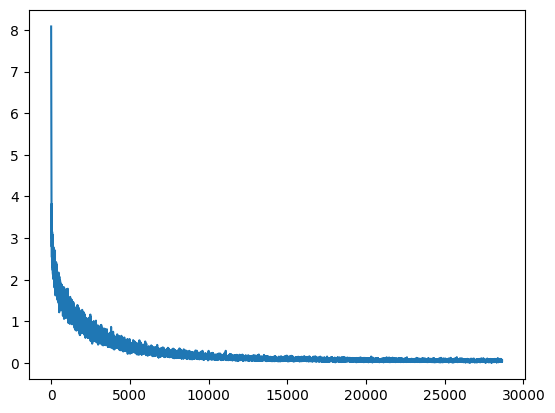

In [40]:
plt.figure()
plt.plot([x[2] for x in batch_losses])

# Evaluating on some inputs

In [41]:
fra_sentence = "J'ai peur des gros chiens."

In [42]:
eng_sentence = "I am scared of big dogs."

In [71]:
def predict(fra_sentence):
    
    fra_sentence = normalizeString(fra_sentence)
    fra_tensor = encodeSentences([fra_sentence], lang = fra)

    hidden = encoder.initHidden(1)
    encoder_outputs, encoder_hidden = encoder(fra_tensor, hidden)

    outputs, hidden = decoder(None, encoder_hidden, encoder_outputs)

    outputs = outputs[0]

    val, inds = outputs.topk(k = 1, dim = 1)
    preds = inds.squeeze(dim = -1)

    english_translation = [eng.index2word[x.item()] for x in preds]
    english_sentence = english_translation[:english_translation.index("<EOS>")]
    english_sentence = " ".join(english_sentence)
    
    return english_sentence

In [72]:
fra_sentence = "J'ai peur des gros chiens."
predict(fra_sentence)

'i am afraid of dogs'

In [91]:
for i in range(10):
    fra_sentence, eng_sentence = random.sample(pairs, 1)[0]
    translation = predict(fra_sentence)
    
    print("French Sentence: ", fra_sentence)
    print("English Sentence: ", eng_sentence)
    print("Predicted English Sentence Translation: ", translation)
    print()

French Sentence:  nous sommes pretes
English Sentence:  we re ready
Predicted English Sentence Translation:  we re ready

French Sentence:  en ce moment je n etudie pas
English Sentence:  i am not studying now
Predicted English Sentence Translation:  i m not studying now

French Sentence:  il est biologiste
English Sentence:  he is a biologist
Predicted English Sentence Translation:  he is a biologist

French Sentence:  c est un homme sur qui on peut compter
English Sentence:  he is a man you can rely upon
Predicted English Sentence Translation:  he is a man you can rely upon

French Sentence:  je n en suis pas certain
English Sentence:  i am not certain about that
Predicted English Sentence Translation:  i m not sure

French Sentence:  il est probable qu il gagne la partie
English Sentence:  he is likely to win the game
Predicted English Sentence Translation:  he is likely to win the game

French Sentence:  tu es un sacre menteur
English Sentence:  you re such a liar
Predicted English